---

## 1. LIBRERÍAS


In [380]:
import os
import json
import time
import pandas as pd
import ast
import unicodedata
from unidecode import unidecode
# from google.oauth2 import service_account
# from google.cloud import aiplatform
# from google.api_core import exceptions
# from vertexai.generative_models import GenerativeModel, GenerationConfig
# Importamos solo lo que está disponible en tu versión de SDK

In [381]:
import re
import io
import csv
import numpy as np
from tqdm import tqdm
import zipfile

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Deep Learning & Generative AI
# import torch
# import tensorflow as tf
# import transformers
# import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
# import nltk
# import spacy

# Data Handling
# import openpyxl
# from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build

# Other utilities
import requests
from tenacity import retry
from google.cloud import bigquery

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

---

## 2. CARGA DE DATOS

Cargamos las conversaciones de Conecta+ desde archivos históricos y el ZIP más reciente del sistema.

#### CONECTA+

In [382]:
RUTA_HISTORICO = "df_resultados.csv"
conecta_2_evaluados = pd.read_csv(RUTA_HISTORICO, sep=',')

conecta_2_evaluados.conversation_id = conecta_2_evaluados.conversation_id.astype(int)

In [383]:
def parse_csv_with_multiline_fields(file_path):
    """
    Parse CSV file that has newlines within quoted fields.
    Handles CSV-escaped quotes (doubled quotes: "").
    
    Uses a character-by-character state machine approach:
    - Tracks quote state to know when we're inside/outside quoted fields
    - Handles escaped quotes ("" becomes ")
    - Accumulates lines until complete record is found
    """
    records = []
    current_record = []
    current_field = []
    in_quotes = False
    header = None
    prev_char = ''

    with open(file_path, 'r', encoding='utf-8') as f:
        char_iter = iter(lambda: f.read(1), '')

        for char in char_iter:
            if char == '"':
                # Check if this is an escaped quote (doubled: "")
                if prev_char == '"' and in_quotes:
                    # This is an escaped quote - add one quote to field
                    current_field.append('"')
                    prev_char = ''  # Reset to avoid triple-quote issues
                    continue
                else:
                    # Toggle quote state
                    in_quotes = not in_quotes
                    prev_char = char
                    continue

            if not in_quotes:
                if char == ',':
                    # End of field
                    current_record.append(''.join(current_field))
                    current_field = []
                elif char == '\n':
                    # End of record
                    if current_field or current_record:
                        current_record.append(''.join(current_field))
                        current_field = []

                        if header is None:
                            header = current_record
                        else:
                            if len(current_record) == len(header):
                                records.append(current_record)
                        current_record = []
                else:
                    current_field.append(char)
            else:
                # Inside quotes - add everything including newlines
                current_field.append(char)

            prev_char = char

        # Handle last field/record
        if current_field or current_record:
            current_record.append(''.join(current_field))
            if len(current_record) == len(header):
                records.append(current_record)

    df = pd.DataFrame(records, columns=header)
    return df

In [384]:
# --- Constantes ---
ARCHIVOS_OBJETIVO = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
    'tbl_preguntas_conversacion_conecta2.csv',
    'tbl_preguntas_encuesta_chat_ia_conecta2.csv'
]

# --- FUNCIÓN DE CARGA MEJORADA PARA MANEJAR RESPUESTAS CON NEWLINES ---
def parse_preguntas_csv_from_zip(zip_ref, filename='tbl_preguntas_conversacion_conecta2.csv'):
    """
    Hybrid approach: Use csv.reader (handles most quotes correctly) then merge continuation rows.
    
    Some rows have improperly quoted multiline fields that csv.reader splits incorrectly.
    We detect these by checking if a row starts with valid numeric ID+FK.
    """
    with zip_ref.open(filename, 'r') as f:
        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
        reader = csv.reader(text_stream)
        raw_rows = list(reader)
    
    header = raw_rows[0]
    expected_cols = len(header)
    
    # Merge fragmented rows
    reconstructed_rows = []
    current_row = None
    
    for i, row in enumerate(raw_rows[1:], 1):
        # Check if this is the start of a new valid record
        is_new_record = False
        
        if len(row) >= 2:
            try:
                int(row[0])  # Valid ID
                int(row[1])  # Valid FK
                is_new_record = True
            except ValueError:
                is_new_record = False
        
        if is_new_record:
            # Save previous row if exists
            if current_row is not None:
                reconstructed_rows.append(current_row)
            current_row = row[:]
        else:
            # Continuation row - merge into last field of current row
            if current_row is not None and len(row) > 0:
                if len(current_row) > 0:
                    # Join the continuation data with newline
                    current_row[-1] += '\n' + ','.join(row)
    
    # Don't forget the last row
    if current_row is not None:
        reconstructed_rows.append(current_row)
    
    # Post-process: ensure all rows have exactly expected_cols columns
    final_rows = []
    for row in reconstructed_rows:
        # Handle rows that were split incorrectly by csv.reader
        # Expected structure: [ID, FK, pregunta, respuesta, calificacion, comentario]
        
        if len(row) == 4:
            # [ID, FK, pregunta, respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL at the end
            last_col = row[3]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    row = row[:3] + [parts[0] + '"', '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    row = row[:3] + [parts[0] + '"', '', '']
                else:
                    row = row + ['', '']
            else:
                row = row + ['', '']
        
        elif len(row) == 5:
            # [ID, FK, pregunta, partial_respuesta, more_respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL
            last_col = row[4]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', '']
                else:
                    # Merge columns 3 and 4 into respuesta
                    merged_respuesta = row[3] + row[4]
                    row = row[:3] + [merged_respuesta, '', '']
            else:
                # Merge columns 3 and 4 into respuesta
                merged_respuesta = row[3] + row[4]
                row = row[:3] + [merged_respuesta, '', '']
        
        elif len(row) < expected_cols:
            # Pad with empty strings for any other case
            row = row + [''] * (expected_cols - len(row))
        
        elif len(row) > expected_cols:
            # Too many columns - merge extras into respuesta (index 3)
            num_extra = len(row) - expected_cols
            respuesta_parts = row[3:3+num_extra+1]
            merged_respuesta = ','.join(respuesta_parts)
            row = row[:3] + [merged_respuesta] + row[3+num_extra+1:]
        
        final_rows.append(row[:expected_cols])
    
    # Create DataFrame
    df = pd.DataFrame(final_rows, columns=header)
    df = df.replace('NULL', pd.NA)
    df = df.replace('', pd.NA)
    df['id_tbl_preguntas_conversacion_conecta2'] = pd.to_numeric(df['id_tbl_preguntas_conversacion_conecta2'], errors='coerce')
    df['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(df['fk_tbl_conversaciones_conecta2'], errors='coerce')
    
    return df

def cargar_dataframes_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP con manejo especial para tbl_preguntas_conversacion_conecta2.csv
    que contiene newlines sin escapar en el campo respuesta.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for archivo_base in archivos_objetivo:
            archivo_encontrado = next((f for f in zip_ref.namelist() 
                                      if f.startswith(archivo_base.replace('.csv', ''))), None)
            
            if not archivo_encontrado:
                print(f"Advertencia: No se encontró '{archivo_base}'. DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"Procesando: '{archivo_encontrado}'...")
            
            try:
                # Special handling for preguntas file
                if 'preguntas_conversacion' in archivo_base:
                    df = parse_preguntas_csv_from_zip(zip_ref, archivo_encontrado)
                    print(f"  ✓ Cargadas {len(df):,} filas con {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                else:
                    # Standard CSV reading for other files
                    with zip_ref.open(archivo_encontrado, 'r') as f:
                        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
                        df = pd.read_csv(text_stream)
                        df = df.replace('NULL', pd.NA)
                        print(f"  ✓ Cargadas {len(df):,} filas")
                
                dataframes[archivo_base] = df
                
            except Exception as e:
                print(f"Error al procesar '{archivo_encontrado}': {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes

In [385]:
# --- FUNCIONES PARA LEER ARCHIVOS JSON ---

def cargar_dataframes_json_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP que contiene archivos JSON.
    
    Los archivos JSON tienen estructura:
    {
        "SELECT * FROM tabla_name": [
            {"campo1": valor1, "campo2": valor2, ...},
            ...
        ]
    }
    
    Mapea los nombres CSV a patrones JSON y extrae los datos.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar todos los archivos en el ZIP
        archivos_disponibles = zip_ref.namelist()
        print(f"📦 Archivos encontrados en ZIP: {len(archivos_disponibles)}")
        
        # --- AÑADIDO PARA MOSTRAR NOMBRES ---
        print("   Nombres de los archivos:")
        for i, nombre_archivo in enumerate(archivos_disponibles, 1):
            print(f"   {i}. {nombre_archivo}")
        # ------------------------------------
        
        for archivo_base in archivos_objetivo:
            # Mapear nombre CSV a patrón JSON
            # Ej: 'tbl_conversaciones_conecta2.csv' -> buscar archivo que contenga 'tbl_conversaciones_conecta2' y termine en '.json'
            tabla_nombre = archivo_base.replace('.csv', '')
            
            # Buscar archivo JSON que coincida
            archivo_encontrado = None
            for archivo in archivos_disponibles:
                if tabla_nombre in archivo and archivo.endswith('.json'):
                    archivo_encontrado = archivo
                    break
            
            if not archivo_encontrado:
                print(f"⚠️  Advertencia: No se encontró '{archivo_base}' (buscando patrón '{tabla_nombre}.json'). DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"📄 Procesando: '{archivo_encontrado}'...")
            
            try:
                # Leer archivo JSON del ZIP
                with zip_ref.open(archivo_encontrado, 'r') as f:
                    data = json.load(f)
                    
                    # La estructura es: {"SELECT * FROM tabla": [{registro1}, {registro2}, ...]}
                    # Extraer la lista de registros (primer valor del diccionario)
                    if isinstance(data, dict):
                        # Obtener el primer (y único) valor del diccionario
                        records = list(data.values())[0]
                        
                        # Convertir a DataFrame
                        df = pd.DataFrame(records)
                        
                        # Reemplazar null por pd.NA
                        df = df.replace({None: pd.NA, 'null': pd.NA, 'NULL': pd.NA})
                        
                        print(f"  ✓ Cargadas {len(df):,} filas")
                        if 'fk_tbl_conversaciones_conecta2' in df.columns:
                            print(f"    {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                        
                        dataframes[archivo_base] = df
                    else:
                        print(f"  ⚠️  Formato JSON inesperado (esperaba dict, recibí {type(data)})")
                        dataframes[archivo_base] = pd.DataFrame()
                
            except Exception as e:
                print(f"  ❌ Error al procesar '{archivo_encontrado}': {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes


def detectar_tipo_zip(zip_path):
    """
    Detecta si el ZIP contiene archivos CSV o JSON.
    
    Returns:
        str: 'csv' o 'json'
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        archivos = zip_ref.namelist()
        
        # Contar archivos CSV y JSON
        csv_count = sum(1 for f in archivos if f.endswith('.csv'))
        json_count = sum(1 for f in archivos if f.endswith('.json'))
        
        if json_count > csv_count:
            return 'json'
        else:
            return 'csv'


def cargar_dataframes_auto(zip_path, archivos_objetivo):
    """
    Función wrapper que detecta automáticamente el tipo de archivo (CSV o JSON)
    y llama a la función de carga apropiada.
    """
    tipo = detectar_tipo_zip(zip_path)
    print(f"🔍 Tipo de archivo detectado: {tipo.upper()}")
    
    if tipo == 'json':
        return cargar_dataframes_json_zip(zip_path, archivos_objetivo)
    else:
        return cargar_dataframes_zip(zip_path, archivos_objetivo)

### 2.1b Soporte para archivos JSON

A partir de noviembre 2025, los archivos ZIP pueden venir en formato JSON en lugar de CSV.

**Estructura de archivos JSON:**
```json
{
  "SELECT * FROM tabla_name": [
    {"campo1": valor1, "campo2": valor2, ...},
    ...
  ]
}
```

**Funcionalidades añadidas:**
- `cargar_dataframes_json_zip()`: Lee archivos JSON del ZIP y los convierte a DataFrames
- `detectar_tipo_zip()`: Detecta automáticamente si el ZIP contiene CSV o JSON
- `cargar_dataframes_auto()`: Wrapper que selecciona la función de carga apropiada

Esto permite que el notebook funcione con ambos formatos sin cambios manuales.

In [386]:
# --- Cargar DataFrames desde ZIP ---
ZIP_PATH = '20251127.zip'

# Usar función automática que detecta CSV o JSON
dataframes = cargar_dataframes_auto(ZIP_PATH, ARCHIVOS_OBJETIVO)

# Asignar a variables individuales
conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']
preguntas_conversacion_conecta = dataframes['tbl_preguntas_conversacion_conecta2.csv']
preguntas = dataframes['tbl_preguntas_encuesta_chat_ia_conecta2.csv']

print(f"\n=== DataFrames cargados ===")
print(f"conversaciones_conecta: {len(conversaciones_conecta):,} filas")
print(f"encuesta_chat_ia_conecta: {len(encuesta_chat_ia_conecta):,} filas")
print(f"preguntas_conversacion_conecta: {len(preguntas_conversacion_conecta):,} filas")

🔍 Tipo de archivo detectado: CSV
Procesando: 'tbl_conversaciones_conecta2.csv'...
  ✓ Cargadas 41,521 filas
Procesando: 'tbl_encuesta_chat_ia_conecta2.csv'...
  ✓ Cargadas 29,453 filas
Procesando: 'tbl_preguntas_conversacion_conecta2.csv'...
  ✓ Cargadas 71,308 filas con 41,417 conversaciones únicas
Procesando: 'tbl_preguntas_encuesta_chat_ia_conecta2.csv'...
  ✓ Cargadas 12 filas

=== DataFrames cargados ===
conversaciones_conecta: 41,521 filas
encuesta_chat_ia_conecta: 29,453 filas
preguntas_conversacion_conecta: 71,308 filas


## 2.2 Post-procesamiento: Limpieza de Datos

Después de cargar los datos del CSV, aplicamos dos funciones de limpieza para corregir inconsistencias en las columnas `calificacion` y `comentario`:

### Problemas detectados:
1. **Columna `calificacion`**: Contiene 718 valores únicos cuando solo debería tener `'Mal'`, `'Bien'`, o `NA`
   - Los valores inválidos son texto que debería estar en la columna `respuesta`
   
2. **Columna `comentario`**: Algunos registros terminan con el patrón `",NULL,NULL"` que indica que datos de `respuesta` y `calificacion` se filtraron incorrectamente

### Solución:
- `limpiar_calificacion()`: Verifica valores válidos y mueve texto inválido a `respuesta`
- `limpiar_comentario()`: Detecta el patrón y redistribuye los valores a las columnas correctas

In [387]:
# --- Post-procesamiento: Limpieza de columnas calificacion y comentario ---

def limpiar_calificacion(df):
    """
    Verifica que la columna 'calificacion' solo contenga valores válidos: 'Mal', 'Bien', o NA.
    Si encuentra un valor inválido, lo agrega al final de 'respuesta' y marca calificacion como NA.
    """
    valores_validos = {'Mal', 'Bien'}
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        calificacion_actual = row['calificacion']
        
        # Si calificacion no es NA y no está en valores válidos
        if pd.notna(calificacion_actual) and calificacion_actual not in valores_validos:
            # Agregar el valor inválido al final de respuesta
            respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
            df.at[idx, 'respuesta'] = f"{respuesta_actual} {calificacion_actual}".strip()
            
            # Marcar calificacion como NA
            df.at[idx, 'calificacion'] = pd.NA
            filas_corregidas += 1
    
    print(f"✓ Limpieza de calificacion: {filas_corregidas:,} valores inválidos movidos a respuesta")
    return df

def limpiar_comentario(df):
    """
    Detecta el patrón ",NULL,NULL" al final de la columna 'comentario' que indica
    que parte de respuesta/calificacion se filtró incorrectamente.
    Extrae esos valores y los asigna a las columnas correctas.
    """
    patron_comentario = r'(.*?),([^,]+),([^,]+)$'
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        comentario_actual = row['comentario']
        
        # Si comentario no es NA y contiene el patrón ",xxx,xxx"
        if pd.notna(comentario_actual) and comentario_actual.count(',') >= 2:
            match = re.match(patron_comentario, comentario_actual)
            
            if match:
                parte_comentario = match.group(1).strip()
                posible_calificacion = match.group(2).strip()
                resto = match.group(3).strip()
                
                # Verificar si posible_calificacion es un valor válido
                if posible_calificacion in {'Mal', 'Bien', 'NULL'}:
                    # Agregar parte_comentario a respuesta si no está vacío
                    if parte_comentario:
                        respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
                        df.at[idx, 'respuesta'] = f"{respuesta_actual} {parte_comentario}".strip()
                    
                    # Actualizar calificacion si es válida
                    if posible_calificacion != 'NULL' and pd.isna(row['calificacion']):
                        df.at[idx, 'calificacion'] = posible_calificacion
                    
                    # El resto va a comentario
                    df.at[idx, 'comentario'] = resto if resto != 'NULL' else pd.NA
                    filas_corregidas += 1
    
    print(f"✓ Limpieza de comentario: {filas_corregidas:,} valores con patrón ',xxx,xxx' corregidos")
    return df

# Aplicar las funciones de limpieza
print("\\n=== Aplicando post-procesamiento de limpieza ===\\")
preguntas_conversacion_conecta = limpiar_calificacion(preguntas_conversacion_conecta)
preguntas_conversacion_conecta = limpiar_comentario(preguntas_conversacion_conecta)

# Verificar resultado
print(f"\\n📊 Valores únicos en 'calificacion' después de limpieza: {preguntas_conversacion_conecta['calificacion'].nunique()}\\")

\n=== Aplicando post-procesamiento de limpieza ===\
✓ Limpieza de calificacion: 1,169 valores inválidos movidos a respuesta
✓ Limpieza de comentario: 0 valores con patrón ',xxx,xxx' corregidos
\n📊 Valores únicos en 'calificacion' después de limpieza: 2\


In [388]:
conversaciones_conecta.fecha_hora_inicio = pd.to_datetime(conversaciones_conecta.fecha_hora_inicio)

In [389]:
# Verificar estructura de conversaciones_conecta
print("=== conversaciones_conecta ===")
print(f"Shape: {conversaciones_conecta.shape}")
print(f"\nColumnas:")
print(conversaciones_conecta.columns.tolist())
print(f"\nPrimeras filas:")
conversaciones_conecta.head()

=== conversaciones_conecta ===
Shape: (41521, 6)

Columnas:
['id_tbl_conversaciones_conecta2', 'fecha_hora_inicio', 'fecha_hora_fin', 'correo', 'comentarios', 'motivo_experto']

Primeras filas:


,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto
0,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN
1,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN
2,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NaN,NaN
3,4,2025-08-23 16:37:06,2025-08-23 16:38:11,phdacost@davivienda.com,NaN,NaN
4,5,2025-08-23 16:36:18,2025-08-23 16:37:19,johan.rincon@davivienda.com,NaN,NaN


In [390]:
def calcula_incio_semana(num_dia_incio_semana, df, columna_fecha):
  df = df.copy()
  week_start_day = num_dia_incio_semana # Thursday (Monday=0, Sunday=6)

  # Calcula para cada una de las fechas cual es el dia correspondiente a *week_start_day* Ej. si el dia es Jueves y la fecha es 20250101 el jueves fue 20250102
  df['custom_week_start'] = df['fecha_hora_inicio'].dt.normalize() - pd.to_timedelta(df['fecha_hora_inicio'].dt.weekday, unit='D') + pd.to_timedelta(week_start_day, unit='D')

  # Asigna el dia de incio de la "semana" a cada fecha dependiendo si la fecha analizada es anterior o posterior a la *custom_week_start*
  df['custom_week_start'] = np.where(
      df['custom_week_start'] > df['fecha_hora_inicio'],
      df['custom_week_start'] - pd.to_timedelta(7, unit='D'),
      df['custom_week_start']
  )

  return df["custom_week_start"]

In [391]:
# --- Guardar DataFrames en carpeta con nombre del ZIP ---
nombre_zip = os.path.splitext(os.path.basename(ZIP_PATH))[0]
output_dir = os.path.abspath(
    os.path.join(
        os.getcwd(),
        "../Archivos/Conversaciones_Conecta2",
        nombre_zip
    )
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Carpeta creada: {output_dir}")
    # Guardar cada DataFrame
    conversaciones_conecta.to_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'), index=False)
    encuesta_chat_ia_conecta.to_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'), index=False)
    preguntas_conversacion_conecta.to_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'), index=False)
    print("Archivos guardados correctamente.")
else:
    print(f"La carpeta '{output_dir}' ya existe. No se sobrescriben los archivos.")

# --- Cargar los DataFrames desde la carpeta generada ---
df_conversaciones = pd.read_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'))
df_encuesta = pd.read_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'))
df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


Carpeta creada: c:\Users\gabrieva\Visual_Studio_Code_Files\Archivos\Conversaciones_Conecta2\20251127
Archivos guardados correctamente.


In [392]:
# Cambia 'NULL' por np.nan en la columna 'respuesta'
preguntas_conversacion_conecta['respuesta'] = preguntas_conversacion_conecta['respuesta'].replace('NULL', pd.NA)

#### CONECTA1

In [393]:
# RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0.csv"
# consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')

#### GENESYS

In [394]:
RUTA_GENESYS =  "bq-results-20251120-174905-1763660955332.csv"
experto_conecta2 = pd.read_csv(RUTA_GENESYS, sep=',')

#### USUARIOS

In [395]:
RUTA_USUARIOS = "regional_concat.csv"
regional_concat = pd.read_csv(RUTA_USUARIOS, sep=',')   

In [396]:
# ===== CARGAR TRAZAS DE LANGFUSE =====
print("=" * 80)
print("CARGANDO TRAZAS DE LANGFUSE")
print("=" * 80)

import glob

langfuse_files = sorted(glob.glob("langfuse_traces_20251112_203906*.csv"))
print(f"\nArchivos encontrados: {len(langfuse_files)}")

langfuse_traces = []
for file in langfuse_files:
    df_temp = pd.read_csv(file)
    langfuse_traces.append(df_temp)
    print(f"  ✓ {os.path.basename(file)}: {len(df_temp):,} trazas")

df_langfuse = pd.concat(langfuse_traces, ignore_index=True)
print(f"\n✓ Total trazas cargadas: {len(df_langfuse):,}")
print(f"✓ Conversaciones únicas: {df_langfuse['sessionId'].nunique():,}")

# Filtrar únicamente trazas cuyo name contenga 'main_graph'
original_count = len(df_langfuse)


display(df_langfuse[df_langfuse.id == 'b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4'])

df_langfuse = df_langfuse[
    df_langfuse["name"].astype(str).str.contains("main_graph", case=False, na=False)
].copy()
filtered_count = len(df_langfuse)
ratio = (filtered_count / original_count * 100) if original_count else 0
print(f"✓ Trazas con 'main_graph' en name: {filtered_count:,} ({ratio:.1f}% del total)")
print(f"✓ Conversaciones únicas (filtradas): {df_langfuse['sessionId'].nunique():,}")

df_langfuse["timestamp"] = pd.to_datetime(
    df_langfuse["timestamp"], format="mixed", errors="coerce"
)

df_langfuse.head()

CARGANDO TRAZAS DE LANGFUSE

Archivos encontrados: 2
  ✓ langfuse_traces_20251112_203906 (1).csv: 101,812 trazas
  ✓ langfuse_traces_20251112_203906.csv: 101,812 trazas

✓ Total trazas cargadas: 203,624
✓ Conversaciones únicas: 37,426


,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId
24718,b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4,2025-11-05 22:10:04.865000+00:00,RunnableSequence,"{'document': '¿Cada cuanto tiempo sale la campaña de renovación de cupos?\nLa renovación de cupos es bimestral, recuerda que en la campaña el cliente puede estar marcado como:Renovación con Documentos.Renovación Automática Aprobada.Renovación Automática Negada. Hay bimestre donde encontraremos en la base clientes con Renovación Automática Aprobada y Aumento de Cupo, esto quiere decir que el cliente ha sido beneficiado con un aumento en su cupo de corto plazo y que puede disponer de él inmediatamente.', 'question': 'proceso para la renovacion de tarjetas cafeteras'}",5,NaN,"{'query': 'proceso para la renovacion de tarjetas cafeteras', 'document_index': 2, 'grader_evaluation': True}",[],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4,0.345,0.0,"['62881b93-c5ae-46e9-bdbc-e05fce62a786', '8a4de2fe-1e06-4dbc-a858-2612be98a2cb', '9959205a-d1fe-424c-b6e8-ca0901180ca3', 'f1e8f990-db77-4763-9a22-119c5fc44122']",[],cmglidbeg0008b5zo6fpcsxal,2025-11-05T22:10:04.661Z,False,2025-11-05T22:10:05.100Z,NaN,NaN,NaN,NaN
126530,b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4,2025-11-05 22:10:04.865000+00:00,RunnableSequence,"{'document': '¿Cada cuanto tiempo sale la campaña de renovación de cupos?\nLa renovación de cupos es bimestral, recuerda que en la campaña el cliente puede estar marcado como:Renovación con Documentos.Renovación Automática Aprobada.Renovación Automática Negada. Hay bimestre donde encontraremos en la base clientes con Renovación Automática Aprobada y Aumento de Cupo, esto quiere decir que el cliente ha sido beneficiado con un aumento en su cupo de corto plazo y que puede disponer de él inmediatamente.', 'question': 'proceso para la renovacion de tarjetas cafeteras'}",5,NaN,"{'query': 'proceso para la renovacion de tarjetas cafeteras', 'document_index': 2, 'grader_evaluation': True}",[],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4,0.345,0.0,"['62881b93-c5ae-46e9-bdbc-e05fce62a786', '8a4de2fe-1e06-4dbc-a858-2612be98a2cb', '9959205a-d1fe-424c-b6e8-ca0901180ca3', 'f1e8f990-db77-4763-9a22-119c5fc44122']",[],cmglidbeg0008b5zo6fpcsxal,2025-11-05T22:10:04.661Z,False,2025-11-05T22:10:05.100Z,NaN,NaN,NaN,NaN


✓ Trazas con 'main_graph' en name: 73,054 (35.9% del total)
✓ Conversaciones únicas (filtradas): 36,488


id                        timestamp  \
0   32340caf-f61f-46ea-aaac-49c3de70c25c 2025-11-13 00:16:23.770000+00:00   
4   47f0383f-74f9-451c-98ed-ccea33e213b5 2025-11-12 23:50:11.750000+00:00   
8   c74c6740-d4ca-4e06-8e7d-0d4a9226bc54 2025-11-12 23:43:38.551000+00:00   
9   8b182f88-0be0-4a00-9fe4-ef28433de806 2025-11-12 23:28:08.954000+00:00   
13  985bb38d-de46-4454-abf1-3d416334d118 2025-11-12 23:27:07.196000+00:00   

                                               name  \
0   069dc723-fd1e-49f5-a8d7-83a1fbfd3a3e_main_graph   
4   dd74944e-428e-44f7-a853-1e43ac4c1638_main_graph   
8   f0c11944-32f5-4fec-8adf-63ba2b7a2e8c_main_graph   
9   17b2b95c-1dbf-4a20-857c-4d5d7e669b4b_main_graph   
13  c46f2fa0-adab-41b6-ab73-ee52c1968f60_main_graph   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

---

## 3. PREPARACIÓN Y TRANSFORMACIÓN DE DATOS

Consolidamos las diferentes fuentes de datos:
- Conversaciones de Conecta 2.0
- Encuestas de satisfacción
- Datos de usuarios por regional
- Historial de escalamiento a expertos (Genesys)

In [397]:
# print(f"\n=== DataFrames cargados ===")
print(f"conversaciones_conecta: {len(conversaciones_conecta):,} filas")
print(f"encuesta_chat_ia_conecta: {len(encuesta_chat_ia_conecta):,} filas")
print(f"preguntas_conversacion_conecta: {len(preguntas_conversacion_conecta):,} filas")

conversaciones_conecta: 41,521 filas
encuesta_chat_ia_conecta: 29,453 filas
preguntas_conversacion_conecta: 71,308 filas


In [398]:
preguntas_conversacion_conecta.comentario.unique()

array([<NA>,
       ' por la App o en línea. 😊\nSi quieres conocer más detalles sobre las características, beneficios y tarifas, puedes consultar los siguientes enlaces.\n📄 **Información adicional disponible:**\n• Detalles sobre la Cuenta de Ahorros Tradicional y sus beneficios: [https://www.davivienda.com/wps/portal/personas/nuevo/personas/tasasytarifas/!ut/p/z1/04_Sj9CPykssy0xPLMnMz0vMAfIjo8ziTdw9fQxdzQIcXY3NjAwcPUzMjCwswgwNzA30w8EKjC0CTfy8nIx8g90sjQ0cfQ2CnR0t_Q393Y30o4jRb4ADOBoQpx-Pgij8xofrR4GV4PMBPgUGbuZQBXgsKcgNDY0wyPQEAKDJNcw!/dz/d5/L2dBISEvZ0FBIS9nQSEh/](https://www.davivienda.com/wps/portal/personas/nuevo/personas/tasasytarifas/!ut/p/z1/04_Sj9CPykssy0xPLMnMz0vMAfIjo8ziTdw9fQxdzQIcXY3NjAwcPUzMjCwswgwNzA30w8EKjC0CTfy8nIx8g90sjQ0cfQ2CnR0t_Q393Y30o4jRb4ADOBoQpx-Pgij8xofrR4GV4PMBPgUGbuZQBXgsKcgNDY0wyPQEAKDJNcw!/dz/d5/L2dBISEvZ0FBIS9nQSEh/)\n• Información sobre el servicio "Bolsillo" para ahorro programado: [https://sites.google.com/davivienda.com/conecta/personas/captaci%C3%B3n/ahor

In [399]:
conversaciones_conecta.comentarios.unique()

array([nan])

In [400]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

In [401]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 71308


In [402]:
regional_concat.drop_duplicates(subset=['Correo electrónico'], keep='first', inplace=True)

In [403]:
regional_correos = regional_concat['Correo electrónico'].str.strip().str.lower()

pre_filtro = df_merged_1.copy()
mask_in = pre_filtro['correo'].str.strip().str.lower().isin(regional_correos)

df_excluidas_regional = pre_filtro.loc[~mask_in].copy()
# df_merged_1 = pre_filtro.loc[mask_in].copy()

print("Antes del filtro:", len(pre_filtro))
print("Después del filtro:", len(df_merged_1))

df_merged_1 = df_merged_1.merge(regional_concat, left_on='correo', right_on='Correo electrónico', how='left')

Antes del filtro: 71308
Después del filtro: 71308


In [404]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'])


In [405]:
df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

# Convierte a datetime y detecta errores
fecha_hora_fin_dt = pd.to_datetime(df_merged_final.fecha_hora_fin, errors='coerce')

Filas tras segundo merge: 71308


In [406]:
initial_shape = df_merged_final.shape
print(f"Shape inicial: {initial_shape}")

df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'], errors='coerce')
df_merged_final['fecha_hora_fin'] = pd.to_datetime(df_merged_final['fecha_hora_fin'], errors='coerce')

# usa inicio cuando fin llega vacío pero inicio es válido
fill_mask = df_merged_final['fecha_hora_fin'].isna() & df_merged_final['fecha_hora_inicio'].notna()
df_merged_final.loc[fill_mask, 'fecha_hora_fin'] = df_merged_final.loc[fill_mask, 'fecha_hora_inicio']

# elimina solo filas donde ambas fechas siguen vacías
drop_mask = df_merged_final['fecha_hora_inicio'].isna() & df_merged_final['fecha_hora_fin'].isna()
df_invalid_fechas = df_merged_final[drop_mask].copy()
df_merged_final = df_merged_final[~drop_mask].copy()

print(f"Filas eliminadas por ambas fechas vacías: {len(df_invalid_fechas)}")
print(f"Shape final: {df_merged_final.shape}")


Shape inicial: (71308, 28)
Filas eliminadas por ambas fechas vacías: 0
Shape final: (71308, 28)


In [407]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date

In [408]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date

fecha_corte = pd.to_datetime("2025-09-30").date()
cond_keep = (
    ((df_merged_final["fecha"] <= fecha_corte) & (df_merged_final["REGIONAL"] == "ANTIOQUIA"))
    | (df_merged_final["fecha"] > fecha_corte)
)

df_filtrados = df_merged_final.loc[cond_keep].copy()
df_descartados = df_merged_final.loc[~cond_keep].copy()

In [409]:
df_merged_final['correo'] = df_merged_final['correo'].str.strip().str.lower()
regional_concat['Correo electrónico'] = regional_concat['Correo electrónico'].str.strip().str.lower()

# Cuenta conversaciones únicas por correo
convs_por_usuario = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='conversaciones_unicas')
)

# Merge con regional_concat (left join), incluyendo todas las columnas de regional_concat
usuarios_conversaciones = regional_concat.merge(
    convs_por_usuario,
    left_on='Correo electrónico',
    right_on='correo',
    how='left'
)

# Llena NaN con 0 (usuarios sin conversaciones)
usuarios_conversaciones['conversaciones_unicas'] = usuarios_conversaciones['conversaciones_unicas'].fillna(0).astype(int)

# Resultado: usuarios_conversaciones tiene todas las columnas de regional_concat + conversaciones_unicas
usuarios_conversaciones.to_csv('conteo_conversaciones_usuario.csv', index=False)

In [410]:
# Set de correos de regional_concat
correos_regional = set(regional_concat['Correo electrónico'])

# Filtra df_merged_final para correos que NO están en regional_concat
df_no_regional = df_merged_final[~df_merged_final['correo'].isin(correos_regional)]

# Cuenta conversaciones únicas de estos usuarios
convs_unicas_no_regional = df_no_regional['fk_tbl_conversaciones_conecta2'].nunique()

print(f"Conversaciones únicas de usuarios NO presentes en regional_concat: {convs_unicas_no_regional}")

Conversaciones únicas de usuarios NO presentes en regional_concat: 1797


In [411]:
# Agregar columna flg_experto en genesys
experto_conecta2['flg_experto'] = np.where(experto_conecta2['ESTADO_INTERACCION'].notna(), 1, 0)

# Realizar el merge incluyendo todas las columnas de genesys
df_merged_final = df_merged_final.merge(
    experto_conecta2,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='NRO_IP_USUARIO',
    how='left',
    suffixes=('', '_genesys')
)

# Asegurar que flg_experto sea 0 si hay nulos
df_merged_final['flg_experto'] = df_merged_final['flg_experto'].fillna(0).astype(int)

In [412]:
def normalizar_texto(texto):
    """
    Normaliza un texto: sin espacios, sin mayúsculas, sin acentos
    """
    if pd.isna(texto) or texto == '':
        return ''
    
    texto = str(texto)
    texto = unidecode(texto)
    texto = texto.lower().strip()
    texto = re.sub(r'\s+', '', texto)
    
    return texto


def extraer_ultima_pregunta_human(input_str):
    """
    Extrae el contenido del último mensaje de tipo 'human' del campo input
    Maneja casos donde los mensajes pueden ser listas o diccionarios
    """
    try:
        # El input puede ser un string que representa un diccionario
        if isinstance(input_str, str):
            # Usar ast.literal_eval en lugar de eval para mayor seguridad
            import ast
            input_dict = ast.literal_eval(input_str)
        else:
            input_dict = input_str
        
        # Obtener la lista de mensajes
        messages = input_dict.get('messages', [])
        
        # Filtrar solo mensajes tipo 'human'
        human_messages = []
        
        for msg in messages:
            # ✅ CORRECCIÓN: Verificar si msg es un diccionario
            if isinstance(msg, dict):
                if msg.get('type') == 'human':
                    human_messages.append(msg)
            
            # ✅ NUEVO: Manejar caso donde msg es una lista
            elif isinstance(msg, list):
                # Si es una lista, puede tener formato ['user', 'texto']
                if len(msg) >= 2:
                    if msg[0] in ['user', 'human']:
                        # Crear un diccionario simulado
                        human_messages.append({'type': 'human', 'content': msg[1]})
        
        # Obtener el último mensaje human
        if human_messages:
            ultimo_human = human_messages[-1]
            content = ultimo_human.get('content', '')
            
            # Si el content empieza con "pregunta:", extraer solo esa parte
            if isinstance(content, str):
                if content.startswith('pregunta:'):
                    content = content.replace('pregunta:', '').strip()
                
                return content
            
            return str(content)
        
        return ''
    
    except Exception as e:
        print(f"Error al extraer pregunta: {e}")
        print(f"Tipo de input: {type(input_str)}")
        if isinstance(input_str, str) and len(input_str) < 500:
            print(f"Contenido: {input_str[:200]}...")
        return ''

In [413]:
print("SHAPE ANTES DEL FILTRO",df_merged_final.shape)
df_merged_final = df_merged_final[pd.to_datetime(df_merged_final.fecha) >= pd.to_datetime('2025-10-13')]
print("CANTIDAD DE REGISTROS POSTERIORES AL 13 DE OCTUBRE",df_merged_final.shape)

SHAPE ANTES DEL FILTRO (71320, 45)
CANTIDAD DE REGISTROS POSTERIORES AL 13 DE OCTUBRE (48890, 45)


In [414]:
df_merged_final["pregunta_normalizada"] = (
    df_merged_final["pregunta"].apply(normalizar_texto)
)

In [415]:
df_langfuse["ultima_pregunta_human"] = df_langfuse["input"].apply(extraer_ultima_pregunta_human)

In [416]:
# ===== IDENTIFICAR PATRONES DE ERROR =====
print("="*80)
print("DETECCIÓN DE ERRORES EN TRAZAS")
print("="*80)

# Función para extraer statusCode y mensaje de error del output
def extract_error_info(output_text):
    """
    Extrae el código de estado y mensaje de error del campo output.
    Detecta dos tipos de errores:
    1. Errores HTTP: BadRequestError: Error code: XXX - {...}
    2. Errores de ejecución: ExceptionError: mensaje...
    """
    if pd.isna(output_text):
        return None, None
    
    text = str(output_text)
    
    # Si es un JSON de conversación normal (no error), retornar None
    if text.strip().startswith("{'project':") or text.strip().startswith('{"project":'):
        return None, None
    
    # TIPO 1: Errores HTTP con código explícito
    if 'Error code:' in text:
        # Extraer código numérico
        code_match = re.search(r'Error code: (\d+)', text)
        status_code = int(code_match.group(1)) if code_match else None
        
        # Clasificar tipo de error según el mensaje
        text_lower = text.lower()
        if 'content management policy' in text_lower or 'content_filter' in text_lower:
            error_type = 'Content Policy (400)'
        elif 'rate limit' in text_lower or 'quota exceeded' in text_lower:
            error_type = 'Rate Limit (429)'
        elif 'gateway cannot authenticate' in text_lower:
            error_type = 'Gateway Auth (500)'
        elif 'internal server error' in text_lower:
            error_type = 'Internal Server (500)'
        elif 'bad gateway' in text_lower:
            error_type = 'Bad Gateway (502)'
        elif 'service unavailable' in text_lower:
            error_type = 'Service Unavailable (503)'
        elif 'gateway timeout' in text_lower:
            error_type = 'Gateway Timeout (504)'
        else:
            error_type = f'HTTP Error {status_code}' if status_code else 'Unknown HTTP Error'
        
        return status_code, error_type
    
    # TIPO 2: Errores de ejecución de Python (sin código HTTP)
    text_lower = text.lower()
    
    if 'recursionerror' in text_lower or 'recursion limit' in text_lower:
        return None, 'Recursion Error'
    elif 'timeout' in text_lower and 'timed out' in text_lower:
        return None, 'Timeout'
    elif text.startswith('Exception:') or text.startswith('Error:'):
        return None, 'Execution Error'
    elif 'traceback' in text_lower:
        return None, 'Exception'
    
    # Si no empieza con JSON de conversación pero tampoco es error conocido,
    # podría ser output válido de paso intermedio (advisor_expert_escalation, etc.)
    return None, None

# Extraer información de error
df_langfuse[['statusCode', 'error_type']] = df_langfuse['output'].apply(
    lambda x: pd.Series(extract_error_info(x))
)

df_langfuse['has_error'] = df_langfuse['error_type'].notna()

DETECCIÓN DE ERRORES EN TRAZAS


In [417]:
df_langfuse["ultima_pregunta_norm"] = df_langfuse["ultima_pregunta_human"].apply(normalizar_texto)

langfuse_valid = df_langfuse[df_langfuse["ultima_pregunta_norm"] != ""].copy()
preguntas_validas = df_merged_final.copy()

langfuse_valid["timestamp"] = pd.to_datetime(
    langfuse_valid["timestamp"],
    errors="coerce",
    utc=True,
)
langfuse_valid["fecha"] = (
    langfuse_valid["timestamp"]
    .dt.tz_localize(None)
    .dt.normalize()
)

preguntas_validas["fecha"] = pd.to_datetime(
    preguntas_validas["fecha"],
    errors="coerce",
).dt.normalize()

dedupe_keys = ["ultima_pregunta_norm", "fecha"]
langfuse_valid["_dup_rank"] = (
    langfuse_valid.sort_values("timestamp")
    .groupby(dedupe_keys)["timestamp"]
    .rank(method="first")
)

langfuse_primary = langfuse_valid[langfuse_valid["_dup_rank"] == 1].copy()
langfuse_duplicates = langfuse_valid[langfuse_valid["_dup_rank"] > 1].copy()

preguntas_validas = (
    preguntas_validas
    .sort_values(["fecha_hora_inicio", "id_tbl_preguntas_conversacion_conecta2"])
    .drop_duplicates(["pregunta_normalizada", "fecha"], keep="first")
)

df_cruce_langfuse = preguntas_validas.merge(
    langfuse_primary,
    left_on=["pregunta_normalizada", "fecha"],
    right_on=["ultima_pregunta_norm", "fecha"],
    how="inner",
    suffixes=("_bd", "_langfuse"),
    validate="one_to_one",
)

df_cruce_langfuse = (
    df_cruce_langfuse
    .sort_values("timestamp")
    .drop_duplicates("id_tbl_preguntas_conversacion_conecta2", keep="first")
)

In [418]:
df_merged_final_copado = df_merged_final.copy()
# df_merged_final = df_merged_final_copado.copy()

#### Filtrado de Datos

In [419]:
convs_en_cruce = set(df_cruce_langfuse['fk_tbl_conversaciones_conecta2'].dropna().astype(int))

respuesta_valida = (
    df_merged_final['respuesta']
    .fillna('')
    .astype(str)
    .str.strip()
    .ne('')
)

conv_stats = (
    df_merged_final.assign(respuesta_valida=respuesta_valida)
    .groupby('fk_tbl_conversaciones_conecta2', as_index=False)
    .agg(
        total_interacciones=('respuesta_valida', 'size'),
        interacciones_validas=('respuesta_valida', 'sum')
    )
)

conv_stats['interacciones_nulas'] = conv_stats['total_interacciones'] - conv_stats['interacciones_validas']
conv_stats['en_cruce'] = conv_stats['fk_tbl_conversaciones_conecta2'].isin(convs_en_cruce)

motivo_experto_flags = (
    df_merged_final.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto']
    .apply(lambda s: s.notna().any())
    .reset_index(name='tiene_motivo_experto')
)

conv_stats = conv_stats.merge(motivo_experto_flags, on='fk_tbl_conversaciones_conecta2', how='left')
conv_stats['tiene_motivo_experto'] = conv_stats['tiene_motivo_experto'].fillna(False)

cond_all_valid = conv_stats['interacciones_validas'] == conv_stats['total_interacciones']
cond_all_null_no_langfuse = (conv_stats['interacciones_validas'] == 0) & (~conv_stats['en_cruce'])
cond_all_null_con_langfuse = (conv_stats['interacciones_validas'] == 0) & conv_stats['en_cruce']
cond_mixta_sin_motivo = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & (~conv_stats['tiene_motivo_experto'])
    & (~conv_stats['en_cruce'])
)
cond_mixta_con_cruce = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & conv_stats['en_cruce']
)
cond_mixta_otras = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & (~cond_mixta_sin_motivo)
    & (~cond_mixta_con_cruce)
)

conv_stats['grupo'] = np.select(
    [
        cond_all_valid,
        cond_all_null_no_langfuse,
        cond_all_null_con_langfuse,
        cond_mixta_sin_motivo,
        cond_mixta_con_cruce,
        cond_mixta_otras
    ],
    [
        'Todas válidas',
        'Todas nulas sin Langfuse',
        'Todas nulas con Langfuse',
        'Mixta sin motivo experto',
        'Mixta con cruce Langfuse',
        'Mixta con motivo experto'
    ],
    default='Otras'
)

conv_stats['razon_exclusion'] = np.select(
    [cond_all_null_no_langfuse, cond_mixta_sin_motivo],
    ['Todas nulas sin Langfuse', 'Mixta sin motivo experto'],
    default=None
)
conv_stats['excluir'] = conv_stats['razon_exclusion'].notna()

resumen_grupos = (
    conv_stats
    .groupby('grupo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .rename('conversaciones')
    .reset_index()
)

total_conversaciones = conv_stats['fk_tbl_conversaciones_conecta2'].nunique()
resumen_grupos['porcentaje'] = (
    resumen_grupos['conversaciones'] / total_conversaciones * 100
).round(2)

conversaciones_a_conservar = conv_stats.loc[
    ~conv_stats['excluir'],
    'fk_tbl_conversaciones_conecta2'
]

df_merged_final_filtrado = df_merged_final[
    df_merged_final['fk_tbl_conversaciones_conecta2'].isin(conversaciones_a_conservar)
].copy()

df_merged_final = df_merged_final_filtrado

print('Conversaciones totales:', total_conversaciones)
print('Conversaciones excluidas:', conv_stats['excluir'].sum())
display(resumen_grupos.sort_values('conversaciones', ascending=False))
print('Conversaciones retenidas:', conversaciones_a_conservar.nunique())
print('Filas retenidas:', len(df_merged_final))
df_merged_final.head()

Conversaciones totales: 28590
Conversaciones excluidas: 872


,grupo,conversaciones,porcentaje
5,Todas válidas,24092,84.27
0,Mixta con cruce Langfuse,2384,8.34
1,Mixta con motivo experto,895,3.13
4,Todas nulas sin Langfuse,472,1.65
2,Mixta sin motivo experto,400,1.40
3,Todas nulas con Langfuse,347,1.21


Conversaciones retenidas: 27718
Filas retenidas: 47218


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,calificacion_pregunta_12,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada
22430,22433,12851,PASO A PASO DESBLOQUEO ATM,"Para desbloquear tu cuenta en caso de bloqueo ATM (Código 05) causado por ingresar 3 veces de forma errada la clave de la tarjeta débito en cajeros propios, puedes hacerlo fácilmente desde la App Davivienda siguiendo estos pasos:\n\n1. Ingresa a Mis cuentas"" en el menú principal de la app.\n2. Elige la cuenta que deseas desbloquear y da clic en la pestaña ""Servicios"".\n3. Selecciona la opción ""Desbloquear cuentas"".\n4. Aparecerá un mensaje indicando que tu cuenta está bloqueada. Da clic en ""Desbloquear"".\n5. Por seguridad, realiza el proceso de autenticación para confirmar el desbloqueo.\n6. ¡Listo! La cuenta ha sido desbloqueada.\n7. Para finalizar, da clic en ""Aceptar"".\nEste proceso es rápido y seguro para que puedas volver a usar tu tarjeta sin inconvenientes. Puedes consultar más detalles y el paso a paso visual en esta presentación: [Paso a paso App Davivienda](https://docs.google.com/presentation/d/1qddR0mbBFASBt6e52keF1DRE0vRBn4Gihlbmyj71THE/present?slide=id.g801de01369_0_727) 👏🔒\nSi tienes alguna inquietud adicional, estoy aquí para ayudarte 😊""",<NA>,<NA>,12851,2025-10-13 06:11:02,2025-10-14 07:34:20,ljgomez@proveedores.davivienda.com,NaN,NaN,ljgomez@proveedores.davivienda.com,Asesor,Leidy Jesus Gomez Quintero,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pasoapasodesbloqueoatm
22431,22434,12852,como se solicita un adelanto de nomina por la app,"Para solicitar un adelanto de nómina por la App Davivienda, debes seguir estos pasos:\n\n1. Ingresa a la App Davivienda con tu número de documento y clave virtual.\n2. En el menú Mis productos"" selecciona ""Solicitar productos"" y luego haz clic en ""Cuentas"".\n3. Elige la opción ""Cuenta Nómina"".\n4. Lee los beneficios y características del producto.\n5. Ingresa la información de tu empresa: el nombre o NIT y selecciónala de la lista desplegable, luego haz clic en Continuar.\n6. Puedes adquirir un cupo de Adelanto de Nómina y/o seguro de vida voluntario, selecciona lo que desees y da clic en Continuar.\n7. Acepta los Términos y Condiciones y continúa.\n8. Recibirás un código de confirmación en tu celular para la firma digital de los documentos asociados a la solicitud. Ingresa el código y continúa.\n9. La apertura del producto será exitosa y deberás notificar a tu empresa el número de la cuenta.\nRecuerda que este servicio está disponible si trabajas en una empresa con convenio de nómina tradicional o en una empresa del grupo Bolívar con subproducto empleado Davivienda y cumples con las condiciones del producto. 🏦📱\nSi quieres ver más detalles, puedes consultar la información en este [enlace de referencia](https://docs.google.com/presentation/d/1emLgDsD2jq0506DUW0ZlDchZp_JdjTQsGn7cNeLXvMc/edit?slide=id.g1ea8d8819db_0_703#slide=id.g1ea8d8819db_0_703).\nSi tienes alguna inquietud adicional, estoy aquí para ayudarte 😊""",<NA>,<NA>,12852,2025-10-13 07:49:26,2025-10-13 08:19:17,andrea.florez@proveedores.davivienda.com,NaN,NaN,andrea.florez

In [420]:
df_merged_final.comentarios.value_counts()

Series([], Name: count, dtype: int64)

In [421]:
df_excluidas = conv_stats[conv_stats['excluir']].copy()
df_excluidas['razon'] = df_excluidas['razon_exclusion']

print(
    f"Conversaciones excluidas: {df_excluidas.shape[0]} "
    f"({(df_excluidas.shape[0] / conv_stats['fk_tbl_conversaciones_conecta2'].nunique() * 100):.2f}%)"
)

display(
    df_excluidas.groupby('razon')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .rename('conversaciones')
    .to_frame()
    .assign(
        porcentaje=lambda d: (
            d['conversaciones'] / df_excluidas['fk_tbl_conversaciones_conecta2'].nunique() * 100
        ).round(2)
    )
)

conv_ids_excluidas = df_excluidas['fk_tbl_conversaciones_conecta2']

df_merged_final_excluidas = df_merged_final_copado[
    df_merged_final_copado['fk_tbl_conversaciones_conecta2'].isin(conv_ids_excluidas)
].copy()

df_merged_final_excluidas.head()

Conversaciones excluidas: 872 (3.05%)


,conversaciones,porcentaje
razon,,
Mixta sin motivo experto,400,45.87
Todas nulas sin Langfuse,472,54.13


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,calificacion_pregunta_12,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada
22687,22690,13023,Dame las caracteristicas de un credito en UVR?,"Lo siento, no encontré información específica sobre este tema. ¿Puedes reformular tu pregunta o ser más específico sobre lo que necesitas? 😊",<NA>,<NA>,13023,2025-10-14 08:39:53,2025-10-14 08:42:27,manuel.munozr@proveedores.davivienda.com,NaN,NaN,manuel.munozr@proveedores.davivienda.com,Asesor,Manuel Munoz Rubio,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,damelascaracteristicasdeuncreditoenuvr?
22688,22691,13023,Que es un credito en uvr?,<NA>,<NA>,<NA>,13023,2025-10-14 08:39:53,2025-10-14 08:42:27,manuel.munozr@proveedores.davivienda.com,NaN,NaN,manuel.munozr@proveedores.davivienda.com,Asesor,Manuel Munoz Rubio,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,queesuncreditoenuvr?
22813,22816,13095,como hacer una auteticacion de cedulas nuevas?,<NA>,<NA>,<NA>,13095,2025-10-14 09:06:04,2025-10-14 09:06:04,damartin@davivienda.com,NaN,NaN,damartin@davivienda.com,DIRECTOR ADMINISTRATIVO OFICINA 0589,NaN,OF. CARMEN DE BOLIVAR SUC. BOLIVAR,CARIBE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,comohacerunaauteticaciondecedulasnuevas?
23399,23402,13431,NECESITO EL FORMATO PARA LA SOLCIITUD DE CREDITO HIPOTECARIO PARA COLO0MBIANOS EN EL EXTERIOR,<NA>,<NA>,<NA>,13431,2025-10-14 10:18:13,2025-10-14 10:18:13,jhenifer.gutierrez@davivienda.com,NaN,NaN,jhenifer.gutierrez@davivienda.com,SUPERNUMERARIO T.F 1219,NaN,OF. GESTION HUMANA SUC. RISARALDA,EJE CAFETERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,necesitoelformatoparalasolciituddecreditohipotecarioparacolo0mbianosenelexterior
23449,23452,13460,consulta credito cancelado concasa,<NA>,<NA>,<NA>,13460,2025-10-14 10:24:31,2025-10-14 10:24:31,jftabare@davivienda.com,NaN,NaN,jftabare@davivienda.com,DIRECTOR ADMINISTRATIVO OFICINA 1262,NaN,OF. DOS QUEBRADAS SUC. RISARALDA,EJE CAFETERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,consultacreditocanceladoconcasa


# Análisis de Conversaciones Conecta 2.0

**Objetivo**: Evaluar el desempeño del asistente virtual Conecta analizando patrones de respuesta, factores que generan respuestas nulas, y comportamiento de usuarios.

**Período analizado**: Septiembre - Octubre 2025

---


## 4. ANÁLISIS EXPLORATORIO (EDA)

Exploramos patrones y características clave de las conversaciones.

---

### 4.1. Análisis de Fallas de IA (Trazas Langfuse)

**Objetivo**: Identificar y clasificar errores atribuibles al sistema de IA mediante análisis de trazas de ejecución de Langfuse.

#### [LANGFUSE] ERRORES QUE CRUZAN CONECTA+

In [422]:
# Resumen de errores
print(f"\nTrazas con error: {df_langfuse['has_error'].sum():,} ({df_langfuse['has_error'].sum()/len(df_langfuse)*100:.2f}%)")

if df_langfuse['has_error'].sum() > 0:
    print(f"\nDistribución por tipo de error:")
    print(df_langfuse['error_type'].value_counts())
    
    print(f"\nDistribución por statusCode (solo errores HTTP):")
    status_counts = df_langfuse[df_langfuse['statusCode'].notna()]['statusCode'].value_counts().sort_index()
    if len(status_counts) > 0:
        print(status_counts)
    else:
        print("  No hay errores HTTP (todos son errores de ejecución)")
else:
    print("\n  ✓ No se detectaron errores en las trazas")

def _normalize_text(value):
    if pd.isna(value):
        return ''
    text = str(value).strip().lower()
    text = unicodedata.normalize('NFKD', text)
    return ''.join(ch for ch in text if not unicodedata.combining(ch))

errores = df_langfuse[df_langfuse['has_error']]
session_ids_con_error = errores['sessionId'].dropna().unique()

print()

print(f"SessionId únicos con error: {len(session_ids_con_error):,}")
print(session_ids_con_error)

sesiones_con_error_multi = (
    errores.groupby('sessionId')['sessionId']
    .count()
    .loc[lambda s: s > 1]
)

print(f"\nConversaciones con más de un error: {len(sesiones_con_error_multi):,}")
print(sesiones_con_error_multi.head())


Trazas con error: 880 (1.20%)

Distribución por tipo de error:
error_type
HTTP Error 401          680
Content Policy (400)    200
Name: count, dtype: int64

Distribución por statusCode (solo errores HTTP):
statusCode
400.0    200
401.0    680
Name: count, dtype: int64

SessionId únicos con error: 440
['6410f8d5-dc3b-41e3-bc39-cb6d01421a48'
 '01ad44ab-4366-47eb-96db-11f704d8beba'
 'f04a7d2c-ea51-473a-b885-8ba62c3fee15'
 '8eb8c1bf-e350-40e2-b0b0-bf3e80219a11'
 '3a02acec-9bad-46f2-a377-dfb11239b39c'
 '8e88f3ac-d179-4cc9-bce5-b36c0a56c639'
 '56351080-2087-42ba-965b-a1458137faef'
 'dd9fbec5-8684-43de-8363-1f7b95a1c800'
 'd29d44b1-f694-44e4-8245-a7b0dbcfba1f'
 '5c2f5882-6d09-49c2-9196-1ec8304032c8'
 '09fa0899-c8f8-4171-8bc7-0958bf713e5b'
 '6888e7e4-ed34-43ec-acd2-b149dacb0034'
 '8cc1340f-b3f5-4e8b-9036-9b248392bfb0'
 '9c8ac627-1f05-4e32-b8fe-1c7c5df01324'
 '9b98a323-8692-45bd-874d-f7d34d8bdeb0'
 'e8f13c67-7acf-4e60-8306-e1e6188ffe31'
 '4442f23f-3c4c-456c-820b-0a1529d07f4a'
 '82116833-dec9-4

In [423]:
errores_langfuse = df_langfuse[df_langfuse['has_error']]
errores_cruce = df_cruce_langfuse[df_cruce_langfuse['has_error']]

ids_langfuse = set(errores_langfuse['sessionId'].dropna().unique())
ids_cruce = set(errores_cruce['sessionId'].dropna().unique())

print("Sesiones únicas Langfuse:", len(ids_langfuse))
print("Sesiones únicas Cruce:", len(ids_cruce))
print("Coinciden:", len(ids_langfuse & ids_cruce))
print("Solo Langfuse:", len(ids_langfuse - ids_cruce))
print("Solo Cruce:", len(ids_cruce - ids_langfuse))

faltantes = errores_langfuse[errores_langfuse['sessionId'].isin(ids_langfuse - ids_cruce)].copy()

Sesiones únicas Langfuse: 440
Sesiones únicas Cruce: 395
Coinciden: 395
Solo Langfuse: 45
Solo Cruce: 0


In [424]:
print("CANTIDAD TRAZAS CON ERROR Y CON RESPUESTA NULL:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())].shape)
df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())].sessionId.nunique()
df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())]

CANTIDAD TRAZAS CON ERROR Y CON RESPUESTA NULL:
(1, 74)


id_tbl_preguntas_conversacion_conecta2  fk_tbl_conversaciones_conecta2  \
13272                                   37117                           21483   

                                                             pregunta  \
13272  como hacer usos de mios davipuntos, por ejemplo en rapicredito   

      respuesta calificacion comentario  id_tbl_conversaciones_conecta2  \
13272      <NA>         <NA>       <NA>                           21483   

        fecha_hora_inicio      fecha_hora_fin  \
13272 2025-10-24 17:24:28 2025-10-24 17:24:28   

                                    correo  comentarios motivo_experto  \
13272  mcfloaya@proveedores.davivienda.com          NaN            NaN   

                        Correo electrónico Nombre Posición  \
13272  mcfloaya@proveedores.davivienda.com          Asesor   

                          Nombre Nombre Departamento     REGIONAL  \
13272  Maria Camila Florez Ayala                 NaN  CALL CENTER   

      calificacion_pregunta_1 calificacion_pregunta_2 calificacion_pregunta_3  \
13272                     NaN                     NaN                     NaN   

      calificacion_pregunta_4 calificacion_pregunta_5 calificacion_pregunta_6  \
13272                     NaN                     NaN                     NaN   

      calificacion_pregunta_7 calificacion_pregunta_8 calificacion_pregunta_9  \
13272                     NaN                     NaN                     NaN   

      calificacion_pregunta_10 calificacion_pregunta_12      fecha  \
13272                      NaN                      NaN 2025-10-24   

      NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS  INTERACCION_ABANDONADA  \
13272                                      NaN                     NaN   

      HORA_INICIO_CONVERSACION HORA_FIN_CONVERSACION  \
13272                      NaN                   NaN   

       TIEMPO_INTERACCION_AGENTE  TIEMPO_RESPUESTA_AGENTE  \
13272                        NaN                      NaN   

      COD_MOTIVO_LLAMADA_CLIENTE CAMPO_INFORMACION_INTERACCION  NRO_CLIENTE  \
13272                        NaN                           NaN          NaN   

      CANAL_ORIGEN  NRO_IP_USUARIO ESTADO_INTERACCION TRANSCRIPCION_CLIENTE  \
13272          NaN             NaN                NaN                   NaN   

      TRANSCRIPCION_ASESOR PERIODO  flg_experto  \
13272                  NaN     NaN            0   

                                        pregunta_normalizada  \
13272  comohacerusosdemiosdavipuntos,porejemploenrapicredito   

                                         id                        timestamp  \
13272  972e0293-6957-4330-a649-5934ef726d91 2025-10-24 22:24:29.187000+00:00   

                                                  name  \
13272  ab2b0765-114c-41c3-a352-b21be4db3803_main_graph   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [425]:
conteo_respuestas = df_cruce_langfuse.loc[df_cruce_langfuse.has_error, 'respuesta'].value_counts()
display(conteo_respuestas)
print(f"Total: {conteo_respuestas.sum():,}")

# print(df_cruce_langfuse[(df_cruce_langfuse.has_error) & (~df_cruce_langfuse.respuesta.isna())].sessionId.nunique())

respuesta
Lo siento, no encontré información específica sobre este tema. ¿Puedes reformular tu pregunta o ser más específico sobre lo que necesitas? 😊    394
Name: count, dtype: int64

Total: 394


In [426]:
df_cruce_langfuse[df_cruce_langfuse.has_error == True].motivo_experto.value_counts()    

print("CANTIDAD CONVERSACIONES CON ERROR Y CON MOTIVO EXPERTO:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error == True) & (df_cruce_langfuse.motivo_experto.notna())].sessionId.nunique())

print()

print("CANTIDAD CONVERSACIONES CON ERROR Y SIN MOTIVO EXPERTO:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error == True) & (df_cruce_langfuse.motivo_experto.isna())].sessionId.nunique())

CANTIDAD CONVERSACIONES CON ERROR Y CON MOTIVO EXPERTO:
104

CANTIDAD CONVERSACIONES CON ERROR Y SIN MOTIVO EXPERTO:
291


In [427]:
# EJEMPLO: CONVERSACIÓN CON ERROR, PERO QUE NO REPORTA SUGERENCIA EXPERTO (MOTIVO EXPERTO VACÍO)
df_cruce_langfuse[df_cruce_langfuse.fk_tbl_conversaciones_conecta2 == 13582]

id_tbl_preguntas_conversacion_conecta2  fk_tbl_conversaciones_conecta2  \
1136                                   23674                           13582   
1137                                   23680                           13582   

                          pregunta  \
1136         Tope para pago por qr   
1137  Tope maximo para pago por qr   

                                                                                                                                         respuesta  \
1136  Lo siento, no encontré información específica sobre este tema. ¿Puedes reformular tu pregunta o ser más específico sobre lo que necesitas? 😊   
1137  Lo siento, no encontré información específica sobre este tema. ¿Puedes reformular tu pregunta o ser más específico sobre lo que necesitas? 😊   

     calificacion comentario  id_tbl_conversaciones_conecta2  \
1136         <NA>       <NA>                           13582   
1137         <NA>       <NA>                           13582   

       fecha_hora_inicio      fecha_hora_fin  \
1136 2025-10-14 10:54:49 2025-10-15 10:29:47   
1137 2025-10-14 10:54:49 2025-10-15 10:29:47   

                                   correo  comentarios motivo_experto  \
1136  acsantod@proveedores.davivienda.com          NaN            NaN   
1137  acsantod@proveedores.davivienda.com          NaN            NaN   

                       Correo electrónico Nombre Posición  \
1136  acsantod@proveedores.davivienda.com          Asesor   
1137  acsantod@proveedores.davivienda.com          Asesor   

                                     Nombre Nombre Departamento     REGIONAL  \
1136  Andrea Carolina Santodomingo Martinez                 NaN  CALL CENTER   
1137  Andrea Carolina Santodomingo Martinez                 NaN  CALL CENTER   

     calificacion_pregunta_1 calificacion_pregunta_2 calificacion_pregunta_3  \
1136                     NaN                     NaN                     NaN   
1137                     NaN                     NaN                     NaN   

     calificacion_pregunta_4 calificacion_pregunta_5 calificacion_pregunta_6  \
1136                     NaN                     NaN                     NaN   
1137                     NaN                     NaN                     NaN   

     calificacion_pregunta_7 calificacion_pregunta_8 calificacion_pregunta_9  \
1136                     NaN                     NaN                     NaN   
1137                     NaN                     NaN                     NaN   

     calificacion_pregunta_10 calificacion_pregunta_12      fecha  \
1136                      NaN                      NaN 2025-10-14   
1137                      NaN                      NaN 2025-10-14   

     NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS  INTERACCION_ABANDONADA  \
1136                                      NaN                     NaN   
1137                                      NaN                     NaN   

     HORA_INICIO_CONVERSACION HORA_FIN_CONVERSACION  \
1136                      NaN                   NaN   
1137                      NaN                   NaN   

      TIEMPO_INTERACCION_AGENTE  TIEMPO_RESPUESTA_AGENTE  \
1136                        NaN                      NaN   
1137                        NaN                      NaN   

     COD_MOTIVO_LLAMADA_CLIENTE CAMPO_INFORMACION_INTERACCION  NRO_CLIENTE  \
1136                        NaN                           NaN          NaN   
1137                        NaN                           NaN          NaN   

     CANAL_ORIGEN  NRO_IP_USUARIO ESTADO_INTERACCION TRANSCRIPCION_CLIENTE  \
1136          NaN             NaN                NaN                   NaN   
1137          NaN             NaN                NaN                   NaN   

     TRANSCRIPCION_ASESOR PERIODO  flg_experto     pregunta_normalizada  \
1136                  NaN     NaN            0        topeparapagoporqr   
1137                  NaN     NaN            0  topemaximoparapagoporqr   

                      

#### [LANGFUSE] ERRORES QUE NO CRUZAN CONECTA+

In [428]:
errores_langfuse = df_langfuse[df_langfuse['has_error']]
errores_cruce = df_cruce_langfuse[df_cruce_langfuse['has_error']]

ids_langfuse = set(errores_langfuse['sessionId'].dropna().unique())
ids_cruce = set(errores_cruce['sessionId'].dropna().unique())

faltantes_en_cruce = sorted(ids_langfuse - ids_cruce)
sobran_en_cruce = sorted(ids_cruce - ids_langfuse)

print(f"IDs faltantes en df_cruce_langfuse: {len(faltantes_en_cruce)}")
print(faltantes_en_cruce)

IDs faltantes en df_cruce_langfuse: 45
['0a33a145-0f55-4e95-b402-4ccdd8894c0a', '146c03a5-c4d8-4110-8512-294a90d53f32', '206faa0b-cf8f-4363-a929-8a7d9f8cd846', '20e3bed6-ef22-4353-a267-fcdc722fc378', '25d6d940-7cd6-4d31-a247-59c16a1aa673', '3a02acec-9bad-46f2-a377-dfb11239b39c', '4c1a687b-133d-43d9-b882-f14e7fcdd40d', '508dde41-3ce2-445d-bb75-3826541db10e', '56351080-2087-42ba-965b-a1458137faef', '5bbfb88e-cad5-432e-9267-c2eed39dbb1d', '5d8bf0e0-07f6-47b0-906c-7056c296f734', '5f300984-8f49-4d28-a3fc-fe3b8a27f8de', '5fa6ac36-185c-41f4-b844-6b44b30f0832', '62ab405a-7c73-4447-9253-5c9347d17980', '67c263b5-9afe-43c1-a1d4-5301fea18cc0', '7fbee215-25fd-4904-b202-f7c78c17bd94', '83512e13-c5af-4f2e-9ed8-94baa53848e1', '84cc3bcc-80d5-4877-8fdd-67e93145a30c', '89a026d4-1cf9-41c2-a02b-49b67d07be47', '8eb8c1bf-e350-40e2-b0b0-bf3e80219a11', '93d8580b-cb4a-44aa-8e02-2f6c6969da2c', '9985d013-20ac-4219-9f4e-74c5bfd768ef', '9c1d6b6c-b24f-4145-b330-827657a7456c', '9fcdef7a-0398-4804-90ba-b0ff40aad83f', 

In [429]:
# EJEMPLO: TRAZA DE LANGFUSE CON ERROR, PERO QUE NO TIENE CRUCE CON CONECTA. 
df_langfuse[df_langfuse.sessionId == '0a33a145-0f55-4e95-b402-4ccdd8894c0a']

id                        timestamp  \
58993   06ce37ae-cd5e-40ac-8a28-d27b670e7671 2025-10-24 20:04:29.952000+00:00   
160805  06ce37ae-cd5e-40ac-8a28-d27b670e7671 2025-10-24 20:04:29.952000+00:00   

                                                   name  \
58993   0a33a145-0f55-4e95-b402-4ccdd8894c0a_main_graph   
160805  0a33a145-0f55-4e95-b402-4ccdd8894c0a_main_graph   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### 4.1 Análisis de Respuestas Nulas

Identificamos conversaciones donde Conecta no proporcionó respuesta y analizamos los patrones asociados.

In [430]:
# df_merged_final_excluidas

In [431]:
df_merged_final = df_merged_final[~df_merged_final.REGIONAL.isna()]

In [432]:
df_merged_final_cop = df_merged_final.copy()

In [433]:
df_autog = df_merged_final.copy()
df_autog["fecha"] = pd.to_datetime(df_autog["fecha"], errors="coerce")

def resumen_autogestion(df, flag_column, titulo):
    df_semana = (
        df.assign(
            week_start=lambda d: d["fecha"].dt.normalize()
            - pd.to_timedelta(d["fecha"].dt.weekday, unit="D")
        )
        .groupby(["week_start", "fk_tbl_conversaciones_conecta2"])
        .agg(
            indicador=(
                flag_column,
                lambda s: s.sum() if flag_column == "flg_experto" else s.notna().any(),
            )
        )
        .reset_index()
    )

    df_semana["clasificacion"] = np.where(
        df_semana["indicador"] > 0, "Experto", "Conecta Retuvo"
    )

    resumen = (
        df_semana.groupby("week_start")["clasificacion"]
        .value_counts()
        .unstack(fill_value=0)
        .rename_axis(index="fecha")
        .reindex(columns=["Conecta Retuvo", "Experto"], fill_value=0)
        .reset_index()
        .sort_values("fecha")
    )

    resumen["Grand Total"] = resumen["Conecta Retuvo"] + resumen["Experto"]
    resumen["Autogestión"] = (
        resumen["Conecta Retuvo"] / resumen["Grand Total"] * 100
    ).round(2)

    print(titulo)
    display(resumen)

resumen_autogestion(df_autog, "flg_experto", "Autogestión CONFIRMADA:")
resumen_autogestion(df_autog, "motivo_experto", "Autogestión ÁCIDA:")

Autogestión CONFIRMADA:


clasificacion,fecha,Conecta Retuvo,Experto,Grand Total,Autogestión
0,2025-10-13,4394,537,4931,89.11
1,2025-10-20,3241,446,3687,87.90
2,2025-10-27,4768,571,5339,89.31
3,2025-11-03,3168,500,3668,86.37
4,2025-11-10,3952,625,4577,86.34
5,2025-11-17,2378,239,2617,90.87
6,2025-11-24,2006,0,2006,100.00


Autogestión ÁCIDA:


clasificacion,fecha,Conecta Retuvo,Experto,Grand Total,Autogestión
0,2025-10-13,3676,1255,4931,74.55
1,2025-10-20,2683,1004,3687,72.77
2,2025-10-27,3996,1343,5339,74.85
3,2025-11-03,2659,1009,3668,72.49
4,2025-11-10,3279,1298,4577,71.64
5,2025-11-17,1680,937,2617,64.20
6,2025-11-24,1214,792,2006,60.52


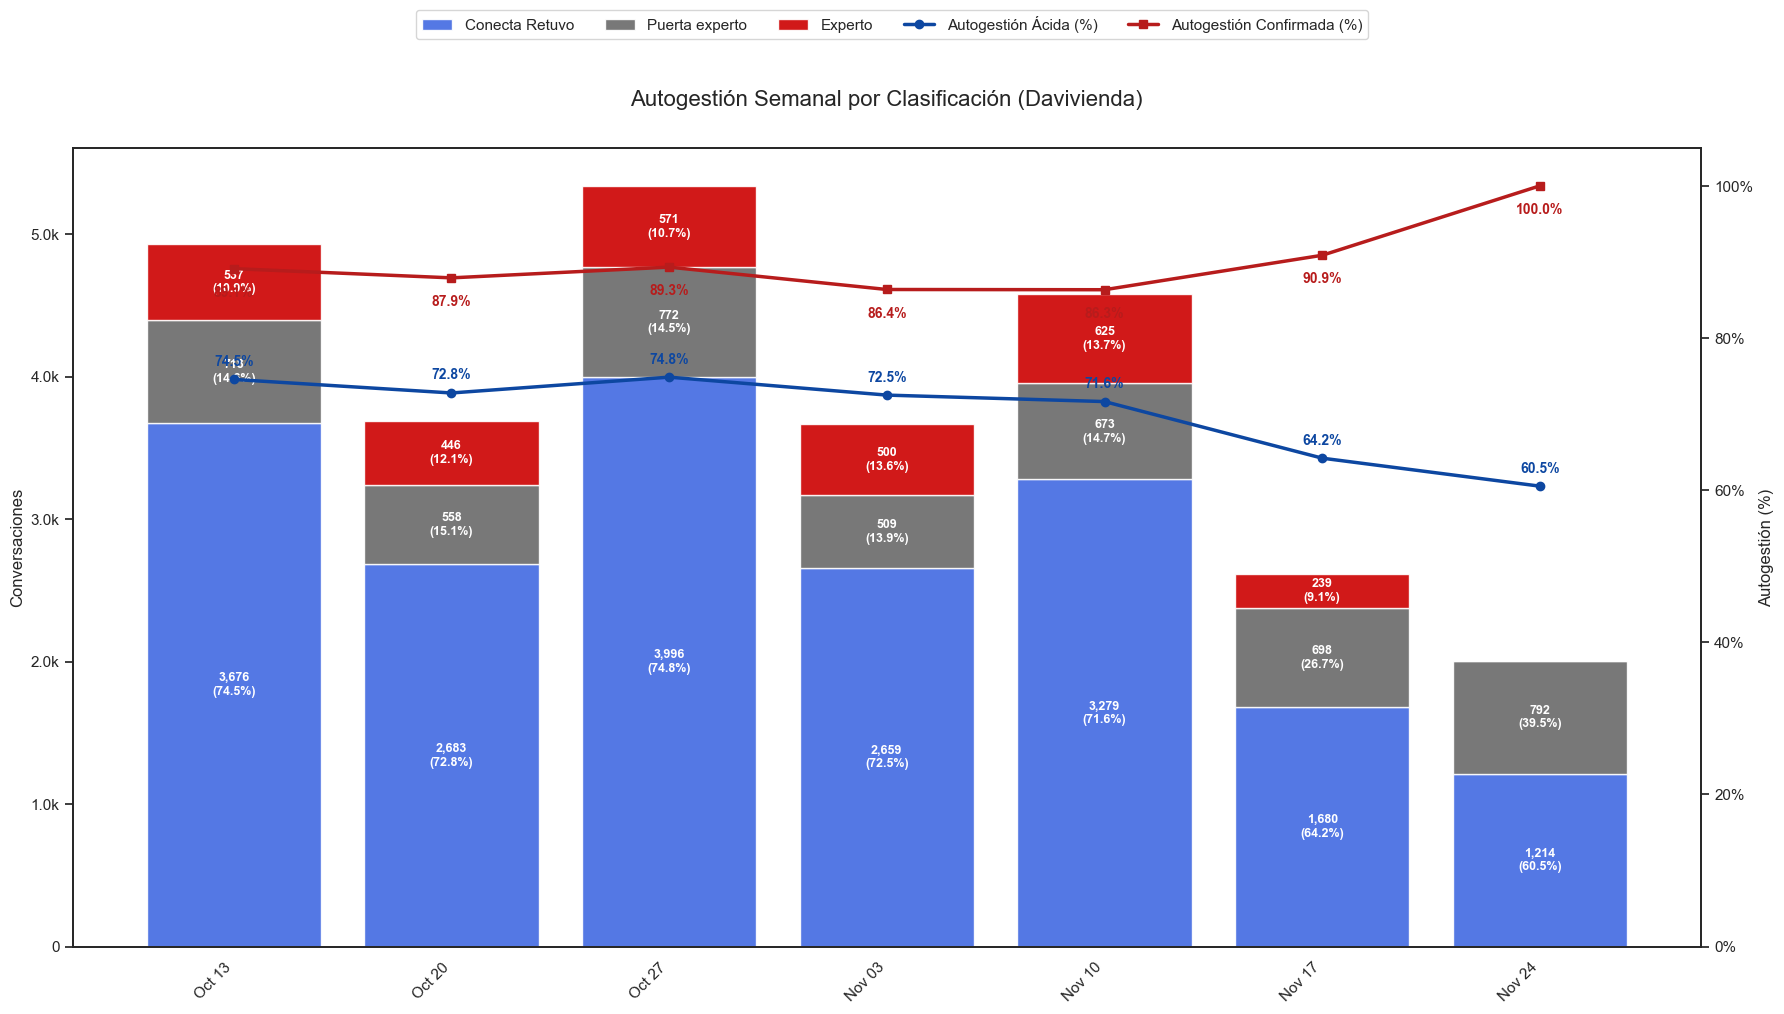

In [434]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

df_autog = df_merged_final.copy()
df_autog["fecha"] = pd.to_datetime(df_autog["fecha"], errors="coerce")

# 1. Agrupar por conversación para definir la nueva clasificación
df_conv_clasif = (
    df_autog.groupby(["fk_tbl_conversaciones_conecta2"])
    .agg(
        week_start=("fecha", lambda d: (d.min().normalize() - pd.to_timedelta(d.min().weekday(), unit="D"))),
        motivo_experto_flag=("motivo_experto", lambda s: s.notna().any()),
        flg_experto_sum=("flg_experto", "sum"),
    )
    .reset_index()
)

# 2. Aplicar la lógica de 3 grupos
df_conv_clasif["clasificacion"] = np.select(
    [
        ~df_conv_clasif["motivo_experto_flag"],
        df_conv_clasif["motivo_experto_flag"] & (df_conv_clasif["flg_experto_sum"] == 0),
        df_conv_clasif["motivo_experto_flag"] & (df_conv_clasif["flg_experto_sum"] >= 1),
    ],
    ["Conecta Retuvo", "Puerta experto", "Experto"],
    default="Otro",
)

# 3. Resumir por semana
resumen_semanal = (
    df_conv_clasif.groupby(["week_start", "clasificacion"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values("week_start")
)

# Asegurar que todas las columnas existan
for col in ["Conecta Retuvo", "Puerta experto", "Experto"]:
    if col not in resumen_semanal.columns:
        resumen_semanal[col] = 0

resumen_semanal["total_conversaciones"] = (
    resumen_semanal["Conecta Retuvo"]
    + resumen_semanal["Puerta experto"]
    + resumen_semanal["Experto"]
)
# --- Calcular ambas métricas de autogestión ---
resumen_semanal["autogestion_acida"] = (
    resumen_semanal["Conecta Retuvo"] / resumen_semanal["total_conversaciones"] * 100
).round(2)
resumen_semanal["autogestion_confirmada"] = (
    (resumen_semanal["Conecta Retuvo"] + resumen_semanal["Puerta experto"]) / resumen_semanal["total_conversaciones"] * 100
).round(2)


# --- Inicio del Gráfico ---
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18, 10))

x = np.arange(len(resumen_semanal))
bar_labels = ["Conecta Retuvo", "Puerta experto", "Experto"]
# --- Paleta de colores Davivienda ---
color_map = {
    "Conecta Retuvo": "#4169E1",  # Azul Rey
    "Puerta experto": "#696969",  # Gris Oscuro
    "Experto": "#CC0000",         # Rojo
}
line_color_acida = "#0D47A1" # Azul oscuro
line_color_confirmada = "#B71C1C" # Rojo oscuro

# --- Gráfico de Barras Apiladas ---
bottom = np.zeros(len(resumen_semanal))
bar_containers = []
for label in bar_labels:
    values = resumen_semanal[label].to_numpy()
    bars = ax.bar(x, values, bottom=bottom, label=label, color=color_map[label], alpha=0.9)
    bar_containers.append((bars, values))
    bottom += values

# Anotaciones dentro de las barras
totals = resumen_semanal['total_conversaciones'].to_numpy()
for bars, values in bar_containers:
    for idx, bar in enumerate(bars):
        height = values[idx]
        if height > 0 and totals[idx] > 0:
            pct = height / totals[idx] * 100
            ax.annotate(
                f'{height:,.0f}\n({pct:.1f}%)',
                (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center', va='center', color='white', fontsize=9, fontweight='bold'
            )

# --- Formato Eje X ---
ax.set_xticks(x)
ax.set_xticklabels(resumen_semanal['week_start'].dt.strftime('%b %d'), rotation=45, ha='right', fontsize=11)
ax.set_xlabel('') # Eliminar etiqueta del eje X

# --- Formato Eje Y Izquierdo ---
ax.set_ylabel('Conversaciones', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v/1000:.1f}k' if v >= 1000 else f'{v:,.0f}'))
ax.grid(False) # Eliminar grid

# --- Eje Y Derecho para las líneas ---
ax2 = ax.twinx()
# Línea 1: Autogestión Ácida
ax2.plot(
    x,
    resumen_semanal["autogestion_acida"],
    color=line_color_acida,
    marker='o',
    linewidth=2.5,
    label='Autogestión Ácida (%)'
)
# Línea 2: Autogestión Confirmada
ax2.plot(
    x,
    resumen_semanal["autogestion_confirmada"],
    color=line_color_confirmada,
    marker='s', # Cuadrado para diferenciar
    linewidth=2.5,
    label='Autogestión Confirmada (%)'
)

# Anotaciones en la línea Ácida
for xi, yi in zip(x, resumen_semanal["autogestion_acida"]):
    ax2.annotate(
        f'{yi:.1f}%', (xi, yi), textcoords='offset points',
        xytext=(0, 10), ha='center', color=line_color_acida, fontsize=10, fontweight='bold'
    )

# Anotaciones en la línea Confirmada
for xi, yi in zip(x, resumen_semanal["autogestion_confirmada"]):
    ax2.annotate(
        f'{yi:.1f}%', (xi, yi), textcoords='offset points',
        xytext=(0, -20), ha='center', color=line_color_confirmada, fontsize=10, fontweight='bold'
    )


# --- Formato Eje Y Derecho ---
ax2.set_ylabel('Autogestión (%)', fontsize=12)
ax2.set_ylim(0, 105)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v:.0f}%'))
ax2.grid(False) # Eliminar grid

# --- Leyenda y Título ---
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    handles1 + handles2, labels1 + labels2,
    loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5, fontsize=11
)

plt.title("Autogestión Semanal por Clasificación (Davivienda)", fontsize=16, pad=30)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar para que el título y leyenda no se corten
plt.show()


In [435]:
resumen_semanal

clasificacion,week_start,Conecta Retuvo,Experto,Puerta experto,total_conversaciones,autogestion_acida,autogestion_confirmada
0,2025-10-13,3676,537,718,4931,74.55,89.11
1,2025-10-20,2683,446,558,3687,72.77,87.90
2,2025-10-27,3996,571,772,5339,74.85,89.31
3,2025-11-03,2659,500,509,3668,72.49,86.37
4,2025-11-10,3279,625,673,4577,71.64,86.34
5,2025-11-17,1680,239,698,2617,64.20,90.87
6,2025-11-24,1214,0,792,2006,60.52,100.00


In [436]:
# Exportar los datos del gráfico a un archivo CSV
output_filename = 'resumen_semanal_autogestion.csv'
resumen_semanal.to_csv(output_filename, index=False, sep=';', decimal='.')

print(f"Los datos del gráfico se han exportado a '{output_filename}'")

Los datos del gráfico se han exportado a 'resumen_semanal_autogestion.csv'


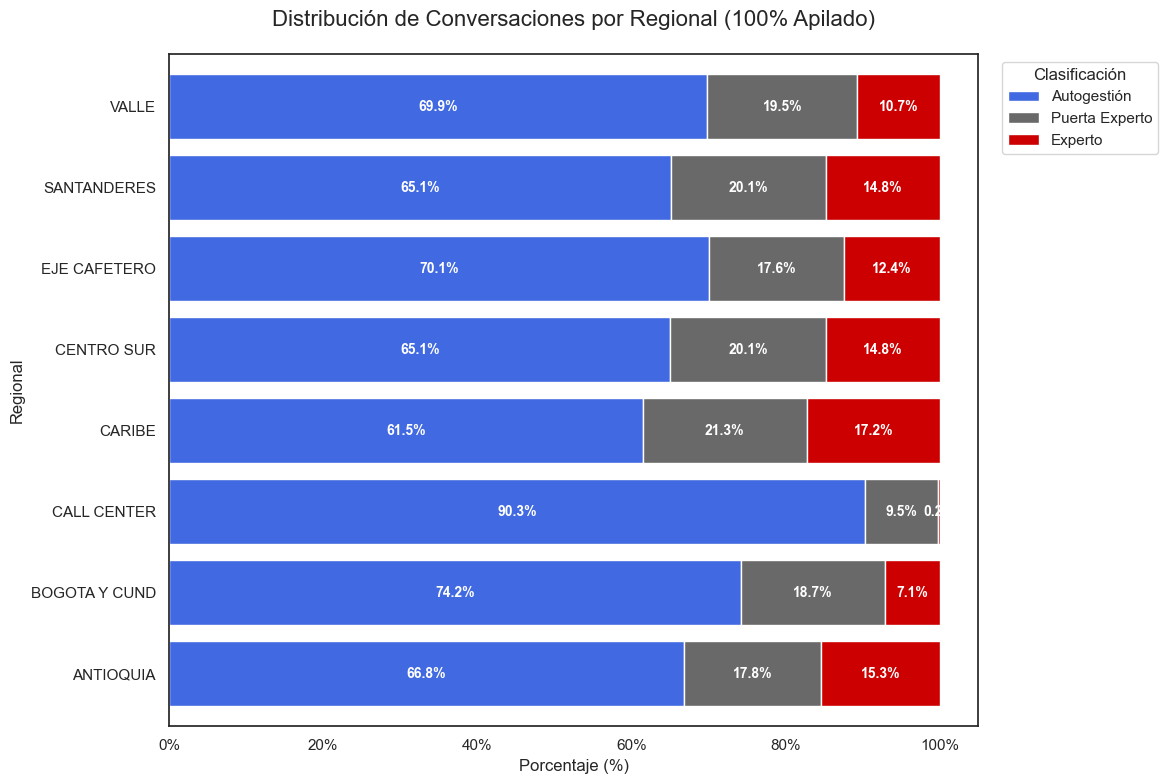

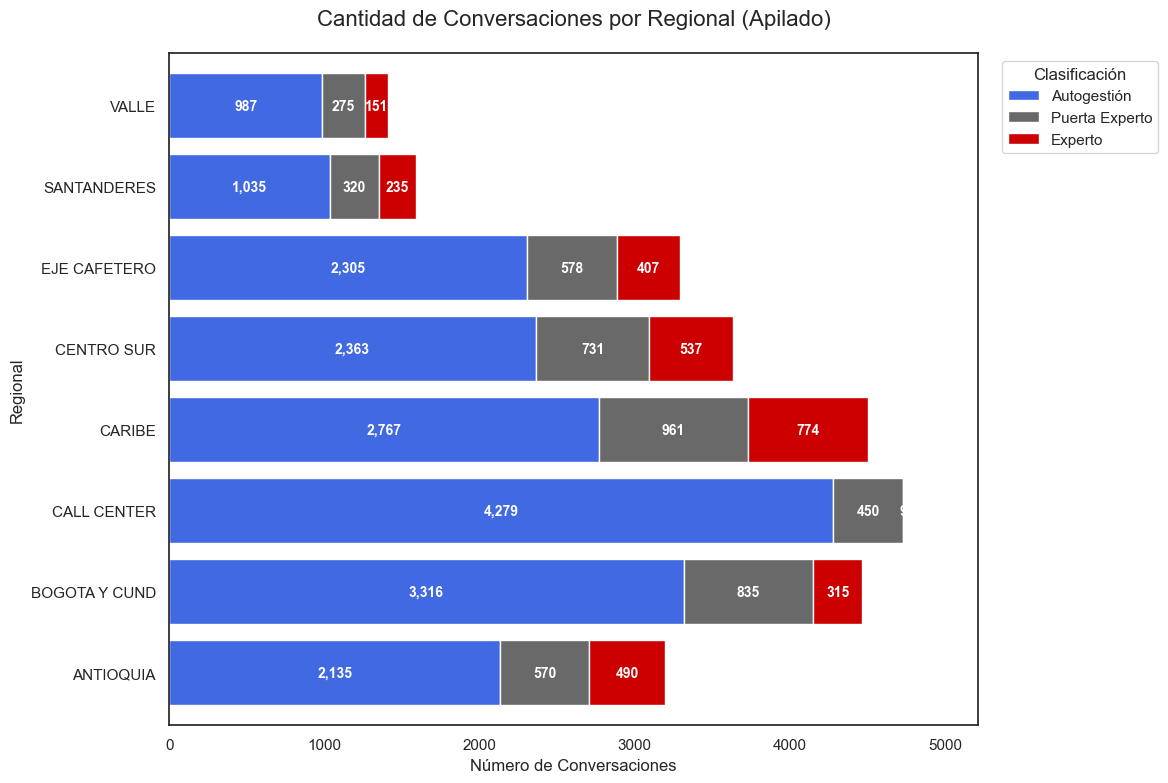

In [437]:
# --- Preparación de Datos para Gráficos ---

# 1. Agrupar por conversación para obtener el estado final
df_conv_estado = df_merged_final.groupby('fk_tbl_conversaciones_conecta2').agg(
    flg_experto_final=('flg_experto', 'max'),
    motivo_experto_presente=('motivo_experto', lambda x: x.notna().any()),
    regional=('REGIONAL', 'first')
).reset_index()

# 2. Aplicar la lógica de clasificación
def clasificar_conversacion(row):
    if row['flg_experto_final'] == 1:
        return 'Experto'
    elif row['flg_experto_final'] == 0 and row['motivo_experto_presente']:
        return 'Puerta Experto'
    else: # flg_experto_final == 0 and not motivo_experto_presente
        return 'Autogestión'

df_conv_estado['clasificacion'] = df_conv_estado.apply(clasificar_conversacion, axis=1)

# 3. Crear tabla de contingencia (crosstab) para los conteos
conteo_regional = pd.crosstab(df_conv_estado['regional'], df_conv_estado['clasificacion'])

# Reordenar columnas para el gráfico
column_order = ['Autogestión', 'Puerta Experto', 'Experto']
conteo_regional = conteo_regional.reindex(columns=column_order, fill_value=0)


# --- Gráfico 1: Barras Horizontales Agrupadas al 100% ---

# Normalizar los datos para obtener porcentajes
conteo_percent = conteo_regional.div(conteo_regional.sum(axis=1), axis=0) * 100

# Paleta de colores
color_map = {
    "Autogestión": "#4169E1",  # Azul Rey
    "Puerta Experto": "#696969",  # Gris Oscuro
    "Experto": "#CC0000",         # Rojo
}

# Crear el gráfico
ax1 = conteo_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map.get(x, '#333333') for x in conteo_percent.columns],
    width=0.8
)

# Añadir anotaciones de porcentaje dentro de las barras
for container in ax1.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax1.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )

ax1.set_title('Distribución de Conversaciones por Regional (100% Apilado)', fontsize=16, pad=20)
ax1.set_xlabel('Porcentaje (%)')
ax1.set_ylabel('Regional')
ax1.legend(title='Clasificación', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Gráfico 2: Barras Horizontales Apiladas con Cantidades ---

# Crear el gráfico de conteos apilado
ax2 = conteo_regional.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map.get(x, '#333333') for x in conteo_regional.columns],
    width=0.8
)

# Añadir anotaciones de conteo dentro de las barras
for container in ax2.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax2.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )

ax2.set_title('Cantidad de Conversaciones por Regional (Apilado)', fontsize=16, pad=20)
ax2.set_xlabel('Número de Conversaciones')
ax2.set_ylabel('Regional')
ax2.legend(title='Clasificación', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.margins(x=0.1) # Añadir margen para que las etiquetas no se corten
ax2.margins(x=0.1) # Añadir margen para que las etiquetas no se corten
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

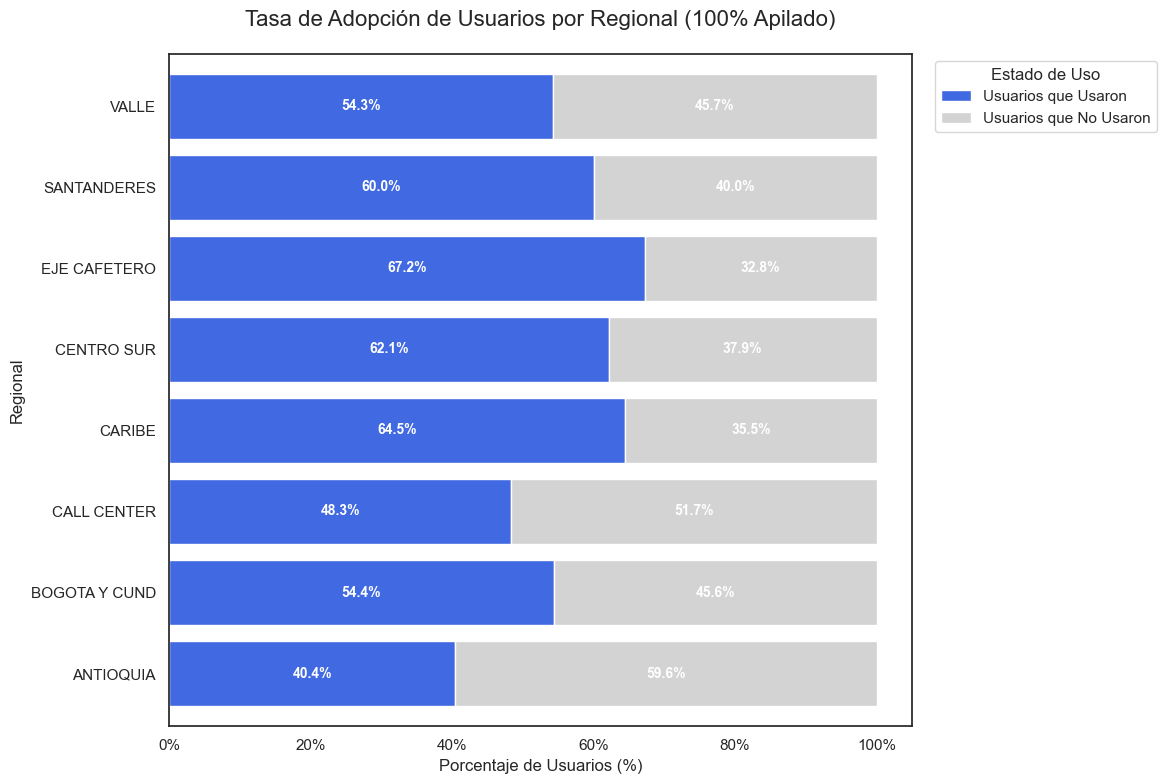

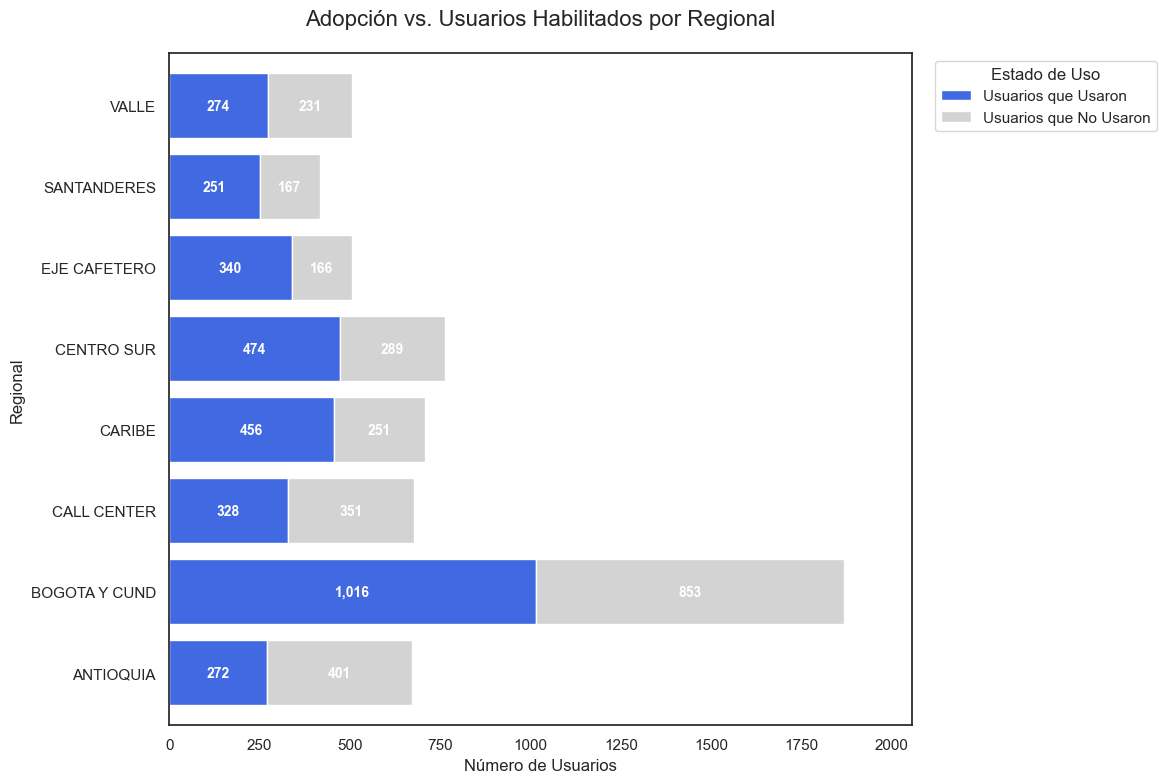

Los datos de adopción de usuarios por regional se han exportado a 'adopcion_usuarios_regional.csv'


,REGIONAL,Usuarios Habilitados,Usuarios que Usaron,Usuarios que No Usaron,Tasa_Adopcion_%
0,ANTIOQUIA,673,272,401,40.42
1,BOGOTA Y CUND,1869,1016,853,54.36
2,CALL CENTER,679,328,351,48.31
3,CARIBE,707,456,251,64.50
4,CENTRO SUR,763,474,289,62.12
5,EJE CAFETERO,506,340,166,67.19
6,SANTANDERES,418,251,167,60.05
7,VALLE,505,274,231,54.26


In [438]:
# --- Preparación de Datos para Gráfico de Adopción de Usuarios ---

# 1. Contar usuarios únicos que usaron la herramienta por regional
usuarios_activos = df_merged_final.groupby('REGIONAL')['correo'].nunique().reset_index()
usuarios_activos.rename(columns={'correo': 'Usuarios que Usaron'}, inplace=True)

# 2. Contar total de usuarios habilitados por regional
usuarios_habilitados = regional_concat.groupby('REGIONAL')['Correo electrónico'].nunique().reset_index()
usuarios_habilitados.rename(columns={'Correo electrónico': 'Usuarios Habilitados'}, inplace=True)

# 3. Unir ambos dataframes
df_adopcion = pd.merge(usuarios_habilitados, usuarios_activos, on='REGIONAL', how='left')
df_adopcion['Usuarios que Usaron'] = df_adopcion['Usuarios que Usaron'].fillna(0).astype(int)

# 4. Calcular usuarios que no han usado la herramienta
df_adopcion['Usuarios que No Usaron'] = df_adopcion['Usuarios Habilitados'] - df_adopcion['Usuarios que Usaron']

# 5. Preparar DataFrame para los gráficos
conteo_adopcion = df_adopcion.set_index('REGIONAL')[['Usuarios que Usaron', 'Usuarios que No Usaron']]


# --- Gráfico 1: Adopción de Usuarios por Regional (100% Apilado) ---

# Normalizar para obtener porcentajes
conteo_adopcion_percent = conteo_adopcion.div(conteo_adopcion.sum(axis=1), axis=0) * 100

# Paleta de colores
color_map_adopcion = {
    "Usuarios que Usaron": "#4169E1",  # Azul Rey
    "Usuarios que No Usaron": "#D3D3D3", # Gris Claro
}

ax1 = conteo_adopcion_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map_adopcion.get(x) for x in conteo_adopcion_percent.columns],
    width=0.8
)

# Anotaciones de porcentaje
for container in ax1.containers:
    for bar in container:
        width = bar.get_width()
        if width > 5:  # Solo mostrar etiqueta si el espacio es suficiente
            ax1.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}%',
                ha='center', va='center', color='white', fontsize=10, fontweight='bold'
            )

ax1.set_title('Tasa de Adopción de Usuarios por Regional (100% Apilado)', fontsize=16, pad=20)
ax1.set_xlabel('Porcentaje de Usuarios (%)')
ax1.set_ylabel('Regional')
ax1.legend(title='Estado de Uso', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Gráfico 2: Cantidad de Usuarios por Regional (Apilado) ---

ax2 = conteo_adopcion.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map_adopcion.get(x) for x in conteo_adopcion.columns],
    width=0.8
)

# Anotaciones de conteo
for container in ax2.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax2.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',
                ha='center', va='center', color='white', fontsize=10, fontweight='bold'
            )

ax2.set_title('Adopción vs. Usuarios Habilitados por Regional', fontsize=16, pad=20)
ax2.set_xlabel('Número de Usuarios')
ax2.set_ylabel('Regional')
ax2.legend(title='Estado de Uso', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.margins(x=0.1)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Exportar datos a CSV ---
df_export_adopcion = df_adopcion.copy()
df_export_adopcion['Tasa_Adopcion_%'] = (df_export_adopcion['Usuarios que Usaron'] / df_export_adopcion['Usuarios Habilitados'] * 100).round(2)

output_filename_adopcion = 'adopcion_usuarios_regional.csv'
df_export_adopcion.to_csv(output_filename_adopcion, index=False, sep=';', decimal='.')

print(f"Los datos de adopción de usuarios por regional se han exportado a '{output_filename_adopcion}'")
display(df_export_adopcion)

In [439]:
# --- Exportar datos de los gráficos a CSV ---

# Combinar conteos y porcentajes en un solo DataFrame
df_exportacion_regional = conteo_regional.copy()
df_exportacion_regional = df_exportacion_regional.join(conteo_percent.rename(columns=lambda x: f"{x}_%"))

# Añadir una columna con el total de conversaciones por regional
df_exportacion_regional['Total_Conversaciones'] = df_exportacion_regional[['Autogestión', 'Puerta Experto', 'Experto']].sum(axis=1)

# Resetear el índice para que 'regional' sea una columna
df_exportacion_regional = df_exportacion_regional.reset_index()

# Reordenar columnas para mayor claridad
column_order_export = [
    'regional',
    'Autogestión',
    'Puerta Experto',
    'Experto',
    'Total_Conversaciones',
    'Autogestión_%',
    'Puerta Experto_%',
    'Experto_%'
]
df_exportacion_regional = df_exportacion_regional[column_order_export]


# Guardar en archivo CSV
output_filename_regional = 'distribucion_regional.csv'
df_exportacion_regional.to_csv(output_filename_regional, index=False, sep=';', decimal='.')

print(f"Los datos de los gráficos por regional se han exportado a '{output_filename_regional}'")
display(df_exportacion_regional)

Los datos de los gráficos por regional se han exportado a 'distribucion_regional.csv'


clasificacion,regional,Autogestión,Puerta Experto,Experto,Total_Conversaciones,Autogestión_%,Puerta Experto_%,Experto_%
0,ANTIOQUIA,2135,570,490,3195,66.823161,17.840376,15.336463
1,BOGOTA Y CUND,3316,835,315,4466,74.249888,18.696820,7.053292
2,CALL CENTER,4279,450,9,4738,90.312368,9.497678,0.189954
3,CARIBE,2767,961,774,4502,61.461573,21.346068,17.192359
4,CENTRO SUR,2363,731,537,3631,65.078491,20.132195,14.789314
5,EJE CAFETERO,2305,578,407,3290,70.060790,17.568389,12.370821
6,SANTANDERES,1035,320,235,1590,65.094340,20.125786,14.779874
7,VALLE,987,275,151,1413,69.851380,19.462137,10.686483


### 5.1 Comparación Langfuse vs Conversaciones BD

Comparación diaria entre:
- **Trazas Langfuse** (`sessionId`): Ejecuciones registradas del sistema de IA
- **Conversaciones BD** (`fk_tbl_conversaciones_conecta2`): Interacciones almacenadas en base de datos

Objetivo: Identificar correlación entre ambas fuentes y detectar posibles gaps en trazabilidad.

In [440]:
# ===== COMPARACIÓN DIARIA: LANGFUSE VS BD =====
print("="*80)
print("COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD")
print("="*80)

# 1. Preparar datos de Langfuse (por día)
df_langfuse_dia = df_langfuse.copy()
df_langfuse_dia['fecha'] = df_langfuse_dia['timestamp'].dt.date

langfuse_por_dia = df_langfuse_dia.groupby('fecha').agg(
    sessionId_unicos=('sessionId', 'nunique'),
    trazas_totales=('sessionId', 'size'),
    sesiones_con_error=('has_error', 'sum')
).reset_index()

print(f"\n📊 Rango de fechas en Langfuse:")
print(f"  Desde: {langfuse_por_dia['fecha'].min()}")
print(f"  Hasta: {langfuse_por_dia['fecha'].max()}")
print(f"  Total días: {len(langfuse_por_dia)}")

# 2. Preparar datos de BD (por día)
df_bd_dia = df_merged_final.copy()
df_bd_dia['fecha'] = df_bd_dia['fecha_hora_inicio'].dt.date

bd_por_dia = df_bd_dia.groupby('fecha').agg(
    conversaciones_totales=('fk_tbl_conversaciones_conecta2', 'nunique'),
    interacciones_totales=('fk_tbl_conversaciones_conecta2', 'size'),
    conversaciones_con_respuesta=('respuesta', lambda x: x.notna().sum()),
    conversaciones_sin_respuesta=('respuesta', lambda x: x.isna().sum())
).reset_index()

# Calcular conversaciones únicas con/sin respuesta a nivel de conversación
conversaciones_por_estado = df_bd_dia.groupby(['fk_tbl_conversaciones_conecta2', 'fecha']).agg(
    tiene_respuesta=('respuesta', lambda x: x.notna().any())
).reset_index()

conv_con_respuesta = conversaciones_por_estado[conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()
conv_sin_respuesta = conversaciones_por_estado[~conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()

bd_por_dia = bd_por_dia.merge(
    conv_con_respuesta.reset_index(name='conv_unicas_con_respuesta'),
    on='fecha',
    how='left'
).merge(
    conv_sin_respuesta.reset_index(name='conv_unicas_sin_respuesta'),
    on='fecha',
    how='left'
)

bd_por_dia['conv_unicas_con_respuesta'] = bd_por_dia['conv_unicas_con_respuesta'].fillna(0).astype(int)
bd_por_dia['conv_unicas_sin_respuesta'] = bd_por_dia['conv_unicas_sin_respuesta'].fillna(0).astype(int)

print(f"\n📊 Rango de fechas en BD:")
print(f"  Desde: {bd_por_dia['fecha'].min()}")
print(f"  Hasta: {bd_por_dia['fecha'].max()}")
print(f"  Total días: {len(bd_por_dia)}")

# 3. Merge de ambos dataframes por fecha
comparacion = pd.merge(
    langfuse_por_dia,
    bd_por_dia,
    on='fecha',
    how='outer',
    suffixes=('_langfuse', '_bd')
)

# Rellenar NaN con 0 para días sin datos
comparacion = comparacion.fillna(0)

# Calcular diferencias y ratios
comparacion['diff_conversaciones'] = comparacion['conversaciones_totales'] - comparacion['sessionId_unicos']
comparacion['ratio_langfuse_bd'] = np.where(
    comparacion['conversaciones_totales'] > 0,
    comparacion['sessionId_unicos'] / comparacion['conversaciones_totales'],
    0
)

# Ordenar por fecha
comparacion = comparacion.sort_values('fecha')

print(f"\n📈 Resumen comparativo:")
print(f"  Días con datos en ambas fuentes: {(comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] > 0).sum()}")
print(f"  Días solo en Langfuse: {((comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] == 0)).sum()}")
print(f"  Días solo en BD: {((comparacion['sessionId_unicos'] == 0) & (comparacion['conversaciones_totales'] > 0)).sum()}")

print(f"\n📊 Totales generales:")
print(f"  SessionId únicos (Langfuse): {comparacion['sessionId_unicos'].sum():,.0f}")
print(f"  Conversaciones únicas (BD): {comparacion['conversaciones_totales'].sum():,.0f}")
print(f"  Diferencia: {comparacion['diff_conversaciones'].sum():,.0f}")
print(f"  Ratio promedio Langfuse/BD: {comparacion['ratio_langfuse_bd'].mean():.2%}")

# Mostrar primeras y últimas filas
print(f"\n📋 Primeras 10 filas de comparación:")
print(comparacion.head(10).to_string(index=False))

print(f"\n📋 Últimas 10 filas de comparación:")
print(comparacion.tail(10).to_string(index=False))

COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD

📊 Rango de fechas en Langfuse:
  Desde: 2025-10-11
  Hasta: 2025-11-13
  Total días: 34

📊 Rango de fechas en BD:
  Desde: 2025-10-13
  Hasta: 2025-11-27
  Total días: 46

📈 Resumen comparativo:
  Días con datos en ambas fuentes: 0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
Name: sessionId_unicos, dtype: bool
  Días solo en Langfuse: 2
  Días solo en BD: 14

📊 Totales generales:
  SessionId únicos (Langfuse)

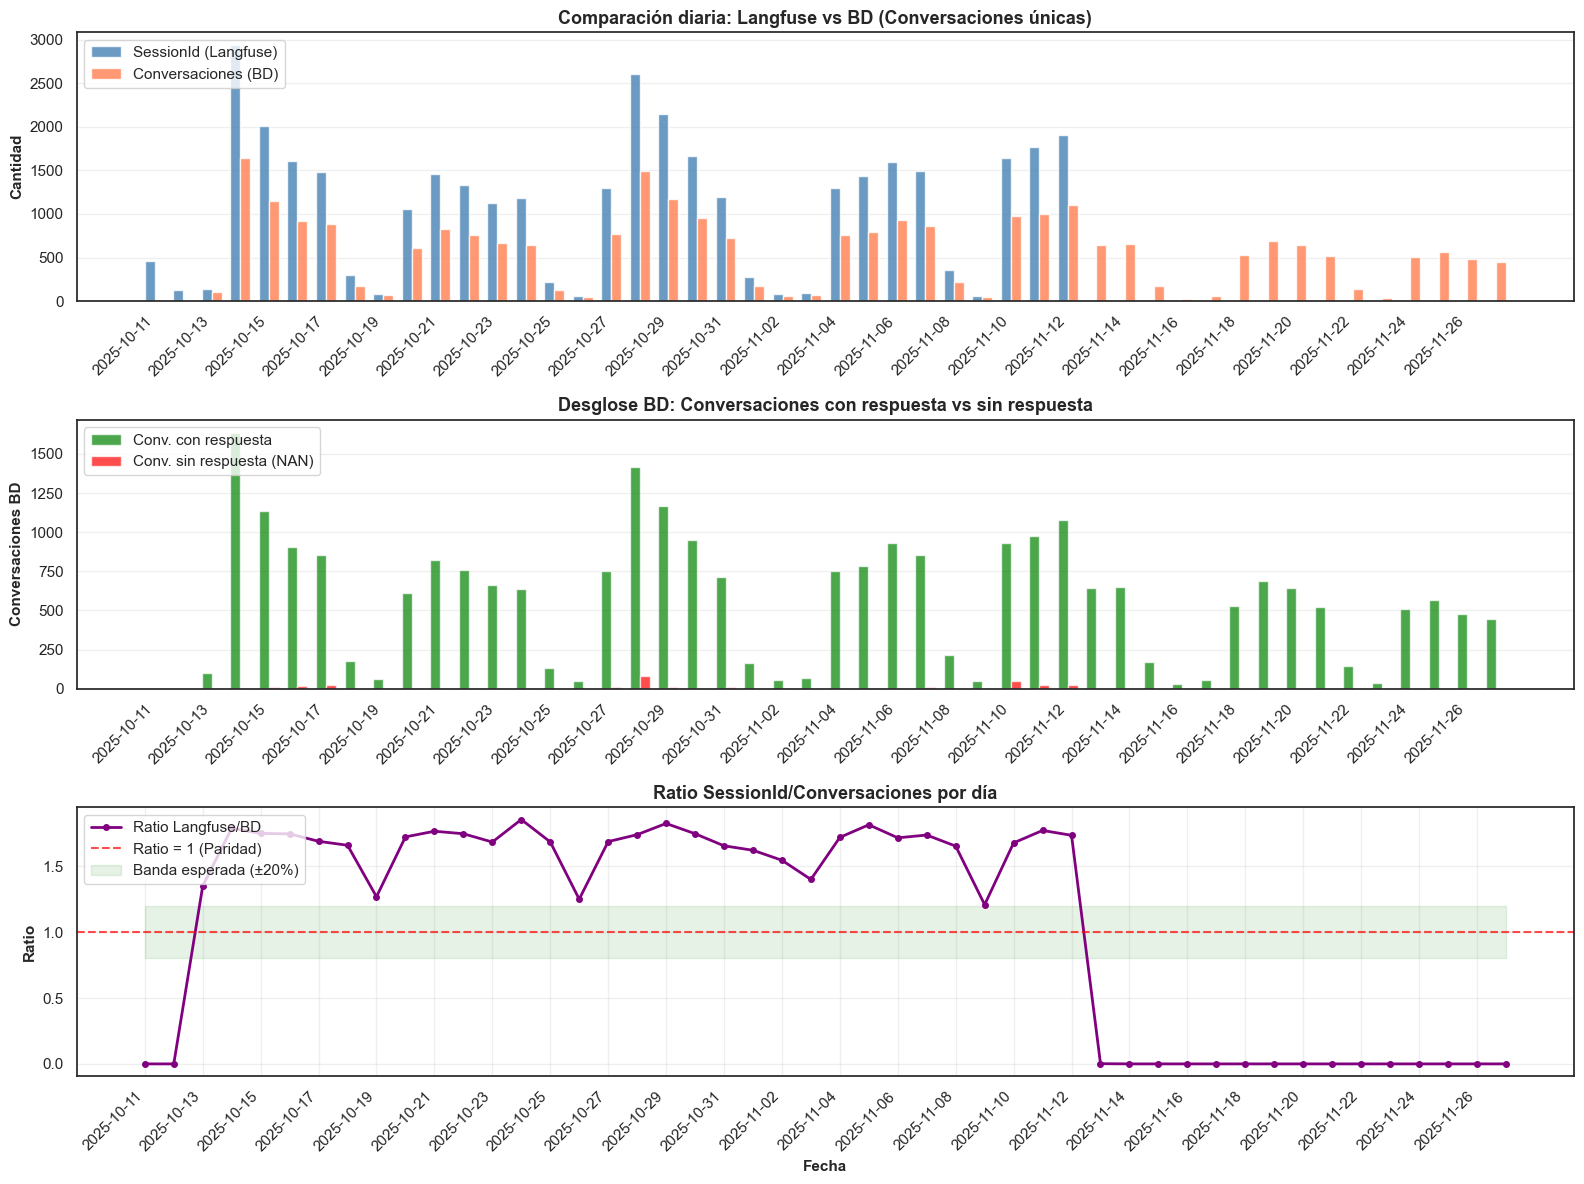


📊 Análisis del Ratio Langfuse/BD:
  Promedio: 106.69%
  Mediana: 163.70%
  Desviación estándar: 81.02%
  Mínimo: 0.00%
  Máximo: 185.47%


In [441]:
# ===== VISUALIZACIÓN COMPARATIVA =====

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Filtrar solo fechas con datos en al menos una fuente
comparacion_plot = comparacion[(comparacion['sessionId_unicos'] > 0) | (comparacion['conversaciones_totales'] > 0)].copy()

# Gráfico 1: Comparación de volúmenes totales
ax1 = axes[0]
width = 0.35
x = np.arange(len(comparacion_plot))

bars1 = ax1.bar(x - width/2, comparacion_plot['sessionId_unicos'], width, 
                label='SessionId (Langfuse)', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparacion_plot['conversaciones_totales'], width,
                label='Conversaciones (BD)', color='coral', alpha=0.8)

ax1.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
ax1.set_title('Comparación diaria: Langfuse vs BD (Conversaciones únicas)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Mostrar solo cada N fechas para evitar saturación
step = max(1, len(comparacion_plot) // 20)
ax1.set_xticks(x[::step])
ax1.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 2: Desglose BD (Con respuesta vs Sin respuesta)
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, comparacion_plot['conv_unicas_con_respuesta'], width,
                label='Conv. con respuesta', color='green', alpha=0.7)
bars4 = ax2.bar(x + width/2, comparacion_plot['conv_unicas_sin_respuesta'], width,
                label='Conv. sin respuesta (NAN)', color='red', alpha=0.7)

ax2.set_ylabel('Conversaciones BD', fontsize=11, fontweight='bold')
ax2.set_title('Desglose BD: Conversaciones con respuesta vs sin respuesta', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(x[::step])
ax2.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 3: Ratio Langfuse/BD
ax3 = axes[2]
line = ax3.plot(x, comparacion_plot['ratio_langfuse_bd'], 
                marker='o', color='purple', linewidth=2, markersize=4, label='Ratio Langfuse/BD')
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Ratio = 1 (Paridad)')
ax3.fill_between(x, 0.8, 1.2, color='green', alpha=0.1, label='Banda esperada (±20%)')

ax3.set_ylabel('Ratio', fontsize=11, fontweight='bold')
ax3.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax3.set_title('Ratio SessionId/Conversaciones por día', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(axis='both', alpha=0.3)
ax3.set_xticks(x[::step])
ax3.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Estadísticas del ratio
print(f"\n📊 Análisis del Ratio Langfuse/BD:")
print(f"  Promedio: {comparacion_plot['ratio_langfuse_bd'].mean():.2%}")
print(f"  Mediana: {comparacion_plot['ratio_langfuse_bd'].median():.2%}")
print(f"  Desviación estándar: {comparacion_plot['ratio_langfuse_bd'].std():.2%}")
print(f"  Mínimo: {comparacion_plot['ratio_langfuse_bd'].min():.2%}")
print(f"  Máximo: {comparacion_plot['ratio_langfuse_bd'].max():.2%}")

In [442]:
import nltk

# Descargar la lista de stopwords en español la primera vez que se usa
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

from nltk.corpus import stopwords

# --- FUNCIÓN DE NORMALIZACIÓN ---
def normalizar_pregunta(texto):
    """
    Aplica una serie de pasos de limpieza y normalización a un texto.
    """
    # 1. Convertir a minúsculas
    texto = texto.lower()
    
    # 2. Eliminar acentos
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    
    # 3. Eliminar signos de puntuación y caracteres especiales
    texto = re.sub(r'[^\w\s]', '', texto)
    
    # 4. Eliminar stopwords
    stop_words = set(stopwords.words('spanish'))
    palabras = texto.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    texto = ' '.join(palabras_filtradas)
    
    # 5. Eliminar espacios extra (ya se maneja con el split/join, pero es una buena práctica)
    texto = ' '.join(texto.split())
    
    return texto

# --- APLICAR LA NORMALIZACIÓN Y CONTAR ---
df = df_merged_final.copy()

# Aplicamos la función a nuestra columna de preguntas
df['pregunta_normalizada'] = df['pregunta'].apply(normalizar_pregunta)

# ¡Aquí está la magia! Contamos las ocurrencias de las preguntas ya normalizadas
conteo_preguntas = df['pregunta_normalizada'].value_counts()

print("--- DataFrame con preguntas normalizadas ---")
print("\n" + "="*40 + "\n")
print("--- Conteo de las preguntas más frecuentes ---")
display(conteo_preguntas)

--- DataFrame con preguntas normalizadas ---


--- Conteo de las preguntas más frecuentes ---


pregunta_normalizada
simulador cdt                           267
modulo embargos                         105
necesito experto                         67
tasas tarifas                            67
levantamiento hipoteca                   66
                                       ... 
vin vehiculo particular                   1
prenda vehiculo particular                1
levantamiento prenda vehiculo pn          1
base sobrante libranzas                   1
realiza activacion zona bre b portal      1
Name: count, Length: 34568, dtype: int64

In [443]:
conteo_preguntas.head(20)

pregunta_normalizada
simulador cdt               267
modulo embargos             105
necesito experto             67
tasas tarifas                67
levantamiento hipoteca       66
sobrante libranza            66
qr interoperable             64
radicar derecho peticion     59
derecho peticion             52
novedades express            51
conecta credito              50
vehiculo                     47
si                           41
cuanto cuota credito         40
bloqueo k                    40
chat asesor                  39
base colombia                39
formato visita ocular        37
simulador vivienda           36
sapli cartera                36
Name: count, dtype: int64

## Clasificación IA (Gestionada vs. NO Gestionada)

In [ ]:
import os
import json
import pandas as pd
import time
from dotenv import load_dotenv

# ===== CONFIGURACIÓN: ELEGIR MÉTODO DE AUTENTICACIÓN =====
# Cambiar a False para usar Service Account con Vertex AI
USE_API_KEY = True  # True = API Key | False = Service Account

print("="*80)
print("CONFIGURACIÓN DE AUTENTICACIÓN PARA GEMINI")
print("="*80)

if USE_API_KEY:
    # ===== OPCIÓN 1: API KEY CON GOOGLE.GENERATIVEAI =====
    print("🔑 Método seleccionado: API Key (google.generativeai)")
    
    import google.generativeai as genai
    
    # Cargar API Key desde .env
    load_dotenv()
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    
    if not GOOGLE_API_KEY:
        raise RuntimeError("❌ ERROR: GOOGLE_API_KEY no encontrado en archivo .env")
    
    # Configurar Gemini con API Key
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel('gemini-2.0-flash-exp')
    
    print(f"✅ API Key configurada (longitud: {len(GOOGLE_API_KEY)} caracteres)")
    print(f"✅ Modelo: gemini-2.0-flash-exp")
    
else:
    # ===== OPCIÓN 2: SERVICE ACCOUNT CON VERTEX AI =====
    print("🔐 Método seleccionado: Service Account (Vertex AI)")
    
    from google.oauth2 import service_account
    from google.api_core import exceptions
    import vertexai
    from vertexai.generative_models import GenerativeModel
    
    # Nombre del archivo de la cuenta de servicio
    SERVICE_ACCOUNT_FILE = 'comusoporte-desarrollo-319e345bb885.json'
    
    # Cargar credenciales
    try:
        credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
        print(f"✅ Credenciales cargadas desde: {SERVICE_ACCOUNT_FILE}")
    except FileNotFoundError:
        raise RuntimeError(f"❌ ERROR: Archivo '{SERVICE_ACCOUNT_FILE}' no encontrado en el directorio actual")
    
    # Extraer project_id del archivo JSON
    with open(SERVICE_ACCOUNT_FILE, 'r') as f:
        project_id = json.load(f).get('project_id')
    
    if not project_id:
        raise RuntimeError("❌ ERROR: 'project_id' no encontrado en el archivo de la cuenta de servicio")
    
    # Región de Google Cloud
    GCP_REGION = 'us-central1'
    
    # Inicializar Vertex AI
    vertexai.init(project=project_id, location=GCP_REGION, credentials=credentials)
    print(f"✅ Vertex AI inicializado: proyecto '{project_id}', región '{GCP_REGION}'")
    
    # Crear modelo
    MODEL_ID = 'gemini-2.0-flash-001'
    model = GenerativeModel(MODEL_ID)
    print(f"✅ Modelo: {MODEL_ID}")

print("="*80)
print(f"Método activo: {'API Key' if USE_API_KEY else 'Service Account'}")
print("="*80)

In [445]:
SYSTEM_PROMPT = """Eres analista de control de calidad del asistente virtual de Banco Davivienda.

Tu tarea es etiquetar la siguiente interacción en EXACTAMENTE una de las siguientes categorías.
Las categorías permitidas son: 'Pregunta valida', 'Sin información', 'Pregunta no valida', o 'Solicitud Paso Experto'.

Reglas de Etiquetado:
1. 'Pregunta valida': la consulta del usuario está relacionada con productos bancarios, procesos de Davivienda, O temas OPERACIONALES relevantes para Davivienda y la respuesta del bot es pertinente y útil. 
2. 'Sin información': La respuesta del bot indica explicitamente que NO tiene información (p. ej., "Lo siento, no encontré..."). Priorizar esta sobre 'Pregunta valida'.
3. 'Pregunta no valida': la consulta es ambigua o NO está relacionada con el contexto bancario o OPERACIONAL DE Davivienda (ej: clima, política), o el enunciado está vacío/incompleto. 
4. 'Solicitud Paso Experto': Petición directa de hablar con un asesor, humano o ejecutivo.

Devuelve JSON con las claves:
- conversation_id (número entero de la conversación).
- category (una de las categorías válidas).
- rationale (breve explicación en español sobre la decisión).

Instrucciones adicionales:
- Prioriza 'Sin información' cuando el bot exprese que no tiene datos, incluso si la pregunta fue válida.
- Etiqueta como 'Solicitud Paso Experto' cualquier petición directa de escalar a un humano aunque la respuesta no lo conceda.
- Usa 'Pregunta no valida' si la pregunta está vacía, contiene caracteres irrelevantes o trata temas ajenos al contexto operativo de Davivienda.
- En los demás casos utiliza 'Pregunta valida' siempre que la respuesta responda a la pregunta.

IMPORTANTE: TU RESPUESTA DEBE SER ÚNICAMENTE EL OBJETO JSON COMPLETO. 
NO AÑADAS NINGÚN BLOQUE DE CÓDIGO (NO USES ```JSON) NI TEXTO EXPLICATIVO."""

VALID_CATEGORIES = {
    'Pregunta valida', 'Sin información', 'Pregunta no valida', 'Solicitud Paso Experto',
}

CATEGORY_ALIASES = {
    'pregunta válida': 'Pregunta valida', 'pregunta valida': 'Pregunta valida', 
    'pregunta no válida': 'Pregunta no valida', 'sin informacion': 'Sin información', 
    'sin información': 'Sin información', 'solicitud paso experto': 'Solicitud Paso Experto',
}


def safe_strip(val):
    if pd.isna(val):
        return ''
    return str(val).strip()

def build_prompt(row):
    conversation_id = int(row.get('fk_tbl_conversaciones_conecta2'))
    pregunta = safe_strip(row.get('pregunta'))
    respuesta = safe_strip(row.get('respuesta'))
    if not pregunta:
        pregunta = '[pregunta vacía]'
    if not respuesta:
        respuesta = '[respuesta vacía]'
    return (
        f"{SYSTEM_PROMPT}\n\n"
        f"ID conversacion: {conversation_id}\n"
        f"Pregunta del usuario: {pregunta}\n"
        f"Respuesta del agente: {respuesta}\n\n"
        'Devuelve solo el JSON requerido.'
    )
    
def parse_gemini_json(text):
    cleaned = text.strip()
    if cleaned.startswith('```'):
        cleaned = cleaned[3:]
        cleaned = cleaned.lstrip()
        if cleaned.lower().startswith('json'):
            cleaned = cleaned[4:].lstrip()
        if cleaned.endswith('```'):
            cleaned = cleaned[:-3]
    if cleaned.lower().startswith('json'):
        cleaned = cleaned[4:].lstrip()
    return json.loads(cleaned)

def classify_with_gemini(row, max_retries=3, base_sleep_seconds=2.0, quota_cooldown_seconds=45):
    prompt = ''.join(build_prompt(row))
    last_error = None
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
        except exceptions.ResourceExhausted as exc:
            wait_time = max(quota_cooldown_seconds, base_sleep_seconds * (attempt + 1) * 5)
            print(f'Límite de cuota alcanzado; esperando {wait_time:.0f}s antes de reintentar...')
            time.sleep(wait_time)
            last_error = exc
            continue
        except exceptions.GoogleAPICallError as exc:
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error de la API ({exc.__class__.__name__}); reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            last_error = exc
            continue

        candidate_text = ''
        if response.candidates:
            first_candidate = response.candidates[0]
            for part in first_candidate.content.parts:
                if getattr(part, 'text', None):
                    candidate_text += part.text
        candidate_text = candidate_text.strip()
        if not candidate_text:
            last_error = ValueError('Respuesta sin texto interpretable del modelo.')
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Sin texto interpretable; reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            continue
        try:
            parsed = parse_gemini_json(candidate_text)
            category_raw = (parsed.get('category') or '').strip()
            category = CATEGORY_ALIASES.get(category_raw.lower(), category_raw)
            if category not in VALID_CATEGORIES:
                raise KeyError(f'Categoría no válida recibida: {category_raw}')
            return {
                'conversation_id': int(parsed.get('conversation_id', row.get('fk_tbl_conversaciones_conecta2'))),
                'category': category,
                'rationale': (parsed.get('rationale') or '').strip(),
            }
        except (json.JSONDecodeError, KeyError, AttributeError) as exc:
            last_error = exc
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error interpretando respuesta (intento {attempt + 1}/{max_retries}): {exc}. Reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
    raise ValueError(f'No se pudo interpretar la respuesta de Gemini tras {max_retries} intentos. Último error: {last_error}')

In [446]:
# MAX_INTERACTIONS = None  # Cambia a None para clasificar todo el dataset (incrementa el costo).
# subset = df_nuevos if MAX_INTERACTIONS is None else df_nuevos.head(MAX_INTERACTIONS)

# print(f'Clasificando {subset.shape[0]} interacciones...')

# resultados = []
# for index, row in enumerate(subset.to_dict(orient='records'), start=1):
#     resultado = classify_with_gemini(row)
#     resultados.append(resultado)
#     if index % 25 == 0:
#         print(f'{index} interacciones clasificadas...')

# clasificacion = pd.DataFrame(resultados)

In [447]:
# resultados_previos_cop = resultados_previos

In [451]:
conecta_2_evaluados

,conversation_id,grupo_principal,subgrupo,flg_experto_flag,motivo_experto_flag,motivo_experto_unicos,REGIONAL,calificacion_pregunta_1_mean,calificacion_pregunta_2_mean,fecha,filas_por_conversacion,correo
0,2731,Gestionada Conecta,Conecta Retuvo,0,0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1,jainer.blanco@davivienda.com
1,2732,Gestionada Conecta,Conecta Retuvo,0,0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1,jainer.blanco@davivienda.com
2,2736,Gestionada Conecta,Conecta Retuvo,0,0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1,luiperez@davivienda.com
3,2737,Gestionada Conecta,Conecta Retuvo,0,0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1,eduard.blandon@davivienda.com
4,2742,Gestionada Conecta,Conecta Retuvo,0,0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1,luisa.suarez@davivienda.com
...,...,...,...,...,...,...,...,...,...,...,...,...
23298,29083,Gestionada Conecta,Ofreció PE,0,1,Usuario,ANTIOQUIA,NaN,NaN,2025-11-06 00:00:00,2,bescobar@davivienda.com
23299,29085,Gestionada Conecta,Conecta Retuvo,0,0,NaN,CARIBE,NaN,NaN,2025-11-06 00:00:00,2,jialvare@davivienda.com
23300,29086,Gestionada Conecta,Conecta Retuvo,0,0,NaN,SANTANDERES,NaN,NaN,2025-11-06 00:00:00,1,salgomezn@davivienda.com
23301,29088,Gestionada Conecta,Conecta Retuvo,0,0,NaN,VALLE,NaN,NaN,2025-11-06 00:00:00,1,lgrodrig@davivienda.com


In [456]:
df_nuevos[df_nuevos.respuesta.isna()].NRO_IP_USUARIO.unique()

array([   nan, 29264., 29280., 29303., 29347., 29352., 29359., 29367.,
       29379., 29385., 29429., 29453., 29480., 29479., 29490., 29499.,
       29559., 29568., 29600., 29619., 29678., 29688., 29749., 29814.,
       29951., 29978., 29987., 30042., 30066., 30082., 30106., 30129.,
       30183., 30304., 30327., 30376., 30445., 30514., 30535., 30573.,
       30614., 30639., 30640., 30686., 30834., 30878., 30899., 30950.,
       30974., 30984., 30990., 31001., 31246., 31338., 31427., 31450.,
       31472., 31468., 31486., 31551., 31565., 31625., 31630., 31699.,
       31731., 31745., 31757., 31788., 31825., 31949., 31952., 31954.,
       31957., 31969., 31988., 32021., 32083., 32105., 32132., 32265.,
       32372., 32393., 32413., 32490., 32521., 32530., 32583., 32686.,
       32815., 32824., 32837., 32838., 32865., 32940., 32964., 33021.,
       33034., 33044., 33110., 33117., 33197., 33340., 33343., 33363.,
       33371., 33377., 33404., 33444., 33494., 33592., 33611., 33682.,
      

In [ ]:
# Obtén los IDs ya evaluados en resultados
ids_ya_analizados = conecta_2_evaluados.conversation_id.unique()

df_nuevos = df_merged_final[
    ~df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)]

In [449]:
print("CANTIDAD DE INTERACCIONES NUEVAS A EVALUAR: ",len(df_nuevos))

CANTIDAD DE INTERACCIONES NUEVAS A EVALUAR:  19357


In [178]:
df_nuevos.fk_tbl_conversaciones_conecta2.nunique()

8237

In [450]:
df_merged_final.fk_tbl_conversaciones_conecta2.nunique()

26825

In [180]:
from concurrent.futures import ThreadPoolExecutor

# Si existe resultados_paralelo_parcial.csv, excluye también esos IDs
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    ids_ya_procesados = set()

# Filtra las filas pendientes en df_nuevos
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]

print(f"Pendientes por evaluar: {len(pendientes)}")

Ya procesados previamente: 8237
Pendientes por evaluar: 0


In [181]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# --- IDs ya evaluados ---
ids_ya_analizados = set(conecta_2_evaluados.conversation_id.unique())

# --- Excluir ya procesados si existe archivo parcial ---
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    resultados_previos = pd.DataFrame()
    ids_ya_procesados = set()

# --- Filtra los pendientes para excluir los ya evaluados y procesados ---
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]
print(f"Pendientes por analizar tras excluir previos: {len(pendientes)}")

# --- Funciones de procesamiento ---
def split_dataframe(df, n):
    return np.array_split(df, n)

def process_rows(rows, subset_idx=None):
    print(f"Subset {subset_idx} iniciado con {len(rows)} filas")
    resultados = []
    for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
        resultados.append(classify_with_gemini(row))
    return resultados

num_workers = 4  # Ajusta según tu CPU y cuota API
subsets = split_dataframe(pendientes, num_workers)

# --- Mantén los resultados previos y agrega solo los nuevos ---
resultados_paralelo = resultados_previos.to_dict(orient='records') if not resultados_previos.empty else []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(process_rows, subset, idx)
        for idx, subset in enumerate(subsets)
    ]
    for i, future in enumerate(futures, 1):
        subset_result = future.result()
        resultados_paralelo.extend(subset_result)
        # Guarda incrementalmente, sin perder los previos
        pd.DataFrame(resultados_paralelo).to_csv('resultados_paralelo_parcial.csv', index=False)
        print(f"Guardado parcial tras subset {i}: {len(resultados_paralelo)} filas")

# resultados_paralelo contiene todos los resultados nuevos y previos

clasificacion_total_parcial = pd.DataFrame(resultados_paralelo)
clasificacion_total_parcial.to_csv('resultados_clasificacion_total_parcial.csv', index=False)

Ya procesados previamente: 8237
Pendientes por analizar tras excluir previos: 0


c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Subset 0 iniciado con 0 filas
Subset 1 iniciado con 0 filas
Subset 2 iniciado con 0 filas


Subset 1: 0it [00:00, ?it/s]
Subset 0: 0it [00:00, ?it/s]

Subset 3 iniciado con 0 filas






Subset 3: 0it [00:00, ?it/s]
Subset 2: 0it [00:00, ?it/s]


Guardado parcial tras subset 1: 13716 filas
Guardado parcial tras subset 2: 13716 filas
Guardado parcial tras subset 3: 13716 filas
Guardado parcial tras subset 4: 13716 filas


In [182]:
df_nuevos_cop = df_nuevos.copy()
clasificacion_total = pd.DataFrame(resultados_paralelo) 

In [183]:
if clasificacion_total.empty:
    print("No se obtuvieron nuevos resultados de clasificación.")
    clasificacion_total = conecta_2_evaluados.copy()

In [184]:
# El cumcount debe numerar las interacciones dentro de cada conversación
missing_mask = ~df_nuevos_cop['fk_tbl_conversaciones_conecta2'].isin(clasificacion_total['conversation_id'])
if missing_mask.any():
    df_defaults = (
        df_nuevos_cop.loc[missing_mask, ['fk_tbl_conversaciones_conecta2']]
        .rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    )
    df_defaults['category'] = 'Pregunta valida'
    df_defaults['rationale'] = 'Pregunta generica'
    clasificacion_total = pd.concat([clasificacion_total, df_defaults], ignore_index=True)

clasificacion_total['merge_idx'] = clasificacion_total.groupby('conversation_id').cumcount()
df_nuevos_cop['merge_idx'] = df_nuevos_cop.groupby('fk_tbl_conversaciones_conecta2').cumcount()

auditoria = clasificacion_total.merge(
    df_nuevos_cop[['fk_tbl_conversaciones_conecta2', 'fecha_hora_inicio','pregunta', 'respuesta', 'flg_experto', 'motivo_experto', 'REGIONAL','merge_idx', 'calificacion_pregunta_1', 'calificacion_pregunta_2','calificacion_pregunta_10','correo']],
    left_on=['conversation_id', 'merge_idx'],
    right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
    how='left'
)

auditoria['fecha'] = pd.to_datetime(auditoria['fecha_hora_inicio']).dt.date
auditoria["fecha_hora_inicio"] = pd.to_datetime(auditoria["fecha_hora_inicio"])
auditoria["fecha"] = auditoria["fecha_hora_inicio"].dt.date

In [185]:
def clasificacion_no_gestionada(group):
    categorias = group['category'].astype(str).str.strip().str.lower()
    # 1. Preguntas temas no bancarios: al menos una 'pregunta no valida' y ninguna 'sin información'
    if (categorias == 'pregunta no valida').any() and not (categorias == 'sin información').any():
        return 'Preguntas temas no bancarios'
    # 2. Al menos una 'sin información'
    if (categorias == 'sin información').any():
        return 'Sin información'
    # 3. Al menos una 'solicitud paso experto' y ninguna 'sin información'
    if (categorias == 'solicitud paso experto').any() and not (categorias == 'sin información').any():
        return 'Usuario solicitó paso a experto'
    # Si no cumple ninguna, es mezcla de categorías no contemplada
    return 'Otro'

def clasificacion_principal(group):
    categorias_no_gestionada = {'Sin información', 'Solicitud Paso Experto', 'Pregunta no valida'}
    if any(group['category'].isin(categorias_no_gestionada)):
        return 'No Gestionada Conecta'
    else:
        return 'Gestionada Conecta'

def clasificacion_gestionada(group):
    if group['motivo_experto'].isna().all():
        return 'Conecta Retuvo'
    if group['motivo_experto'].notna().any():
        return 'Ofreció PE'
    return 'Otro'


In [186]:
resultados = resultados_paralelo

In [187]:
auditoria.fecha = pd.to_datetime(auditoria.fecha)

In [188]:
for cid, group in auditoria.groupby('conversation_id'):
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif10_mean = pd.to_numeric(group['calificacion_pregunta_10'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)
    correo = group['correo']

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_10_mean': calif10_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })
    
df_resultados = pd.DataFrame(resultados)

# Filtra correctamente y haz copia para evitar el warning
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()
no_gestionada.loc[:, 'percent_sobre_NGC'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / ngc_convs * 100
no_gestionada.loc[:, 'percent_sobre_total'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_NGC=('percent_sobre_NGC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in ngc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_NGC']:.2f}% de NGC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_sum'].sum()}")

# Aplica igual para Gestionada Conecta
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()
gestionada.loc[:, 'percent_sobre_GC'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / gc_convs * 100
gestionada.loc[:, 'percent_sobre_total'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_GC=('percent_sobre_GC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in gc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_GC']:.2f}% de GC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

Preguntas temas no bancarios: 362 conversaciones (16.40% de NGC, 4.39% del total) | flg_experto==1: 38.0 | motivo_experto.notna(): 114.0
Sin información: 1466 conversaciones (66.43% de NGC, 17.80% del total) | flg_experto==1: 196.0 | motivo_experto.notna(): 663.0
Usuario solicitó paso a experto: 379 conversaciones (17.17% de NGC, 4.60% del total) | flg_experto==1: 148.0 | motivo_experto.notna(): 334.0

Suma total motivo_experto.notna() en No Gestionada Conecta: 1111.0
Conecta Retuvo: 4788 conversaciones (79.40% de GC, 58.13% del total) | flg_experto==1: 0.0 | motivo_experto.notna(): 0.0
Ofreció PE: 1242 conversaciones (20.60% de GC, 15.08% del total) | flg_experto==1: 743.0 | motivo_experto.notna(): 1242.0


In [189]:
# Agrupar por conversación y aplicar clasificaciones
resultados = []

# Identifica los conversation_id que solo están en conecta_2_evaluados
ids_evaluados = set(conecta_2_evaluados['conversation_id'])
ids_auditoria = set(auditoria['conversation_id'])
solo_evaluados = ids_evaluados - ids_auditoria

# Primero, agrega los registros originales de conecta_2_evaluados para los que no están en auditoria
for _, row in conecta_2_evaluados[conecta_2_evaluados['conversation_id'].isin(solo_evaluados)].iterrows():
    resultados.append(row.to_dict())

# Luego, concatena y agrupa como antes (esto sobrescribirá los duplicados, pero no los únicos)
# auditoria_full = pd.concat([conecta_2_evaluados, auditoria], ignore_index=True)

for cid, group in auditoria.groupby('conversation_id'):
    # Solo procesa los que no están ya agregados
    if cid in solo_evaluados:
        continue
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif10_mean = pd.to_numeric(group['calificacion_pregunta_10'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_10_mean': calif10_mean,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })

In [190]:
df_resultados = pd.DataFrame(resultados)

In [191]:
# Guarda el DataFrame en la carpeta de salidas
output_path = r'df_resultados_20251114.csv'
df_resultados.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: df_resultados_20251114.csv


In [192]:
# Muestra solo las filas con calificación válida y agrupa por subgrupo y calificación promedio (redondeada para evitar decimales infinitos)
df_validas = df_resultados[~df_resultados['calificacion_pregunta_2_mean'].isna()].copy()
df_validas['calif2_rounded'] = df_validas['calificacion_pregunta_2_mean'].round(2)
pd.crosstab(df_validas['subgrupo'], df_validas['calif2_rounded'])

calif2_rounded,1.0,2.0,3.0,4.0,5.0
subgrupo,,,,,
Conecta Retuvo,211,45,154,195,718
Ofreció PE,581,85,265,138,265
Preguntas temas no bancarios,47,4,26,14,27
Sin información,95,17,44,24,45
Usuario solicitó paso a experto,45,3,17,13,16


In [193]:
# # 1. Crea resumen de df_nuevos
# resumen_nuevos = (
#     df_nuevos
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 2. Crea resumen de df_merged_final
# resumen_merged = (
#     df_merged_final
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 3. Unifica ambos resúmenes (quita duplicados por fk_tbl_conversaciones_conecta2)
# resumen_unificado = pd.concat([resumen_nuevos, resumen_merged], ignore_index=True)
# resumen_unificado = resumen_unificado.sort_values('fk_tbl_conversaciones_conecta2').drop_duplicates('fk_tbl_conversaciones_conecta2', keep='first')

# # 4. Actualiza df_resultados usando el resumen unificado
# mask_na = df_resultados['correo'].isna()
# df_resultados_update = df_resultados.merge(
#     resumen_unificado,
#     left_on='conversation_id',
#     right_on='fk_tbl_conversaciones_conecta2',
#     how='left',
#     suffixes=('', '_res')
# )

# mapping = {
#     'REGIONAL': 'REGIONAL',
#     'calificacion_pregunta_1_mean': 'calificacion_pregunta_1',
#     'calificacion_pregunta_2_mean': 'calificacion_pregunta_2',
#     'fecha': 'fecha_hora_inicio',
#     'filas_por_conversacion': 'filas_por_conversacion',
#     'correo': 'correo',
#     'motivo_experto_count': 'motivo_experto_count'
# }

# for col, res_col in mapping.items():
#     df_resultados.loc[mask_na, col] = df_resultados_update.loc[mask_na, res_col].values

# # 5. Verifica si quedan correos vacíos
# df_resultados[df_resultados.correo.isna()]

In [194]:
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'], format='mixed')

df_resultados_copia = df_resultados.copy()

df_resultados = df_resultados_copia[df_resultados_copia.fecha >= '2025-10-10']

In [195]:
# --- PREPARACIÓN INICIAL (Tu código original) ---
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
df_resultados.calificacion_pregunta_10_mean = df_resultados.calificacion_pregunta_10_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no
df_resultados['calificacion_combinada'] = df_resultados['calificacion_pregunta_2_mean'].fillna(df_resultados['calificacion_pregunta_10_mean'])


total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)
# 1. PRIMERA CLASIFICACIÓN (Sin cambios)
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    
    calif_validas = aud_sub['calificacion_combinada'].dropna()
    total_calificadas = calif_validas.shape[0]
    
    # <-- REQUERIMIENTO: Añadir Mediana
    if total_calificadas > 0:
        promedio_calif = calif_validas.mean()
        mediana_calif = calif_validas.median()
        stats_string = f"Promedio (Media): {promedio_calif:.2f} | Mediana: {mediana_calif:.2f}"
    else:
        stats_string = "Sin calificaciones"

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | {stats_string}"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)]
    
    calif_validas = pd.to_numeric(aud_sub['calificacion_combinada'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]

    # <-- REQUERIMIENTO: Añadir Mediana
    if total_calificadas > 0:
        promedio_calif = calif_validas.mean()
        mediana_calif = calif_validas.median()
        stats_string = f"Promedio (Media): {promedio_calif:.2f} | Mediana: {mediana_calif:.2f}"
    else:
        stats_string = "Sin calificaciones"

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | {stats_string}"
    )
    
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")


print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])

Total conversaciones: 24480
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 20029 conversaciones (81.82% del total) | flg_experto==1: 2131 (8.71% del total)
No Gestionada Conecta: 4451 conversaciones (18.18% del total) | flg_experto==1: 722 (2.95% del total)

Desglose de No Gestionada Conecta


Preguntas temas no bancarios: 1069 conversaciones (24.02% de NGC, 4.37% del total) | flg_experto==1: 136 (0.56% del total) | motivo_experto.notna(): 367 (1.50% del total) | Calificadas: 155 | Promedio (Media): 2.84 | Mediana: 3.00
Sin información: 2711 conversaciones (60.91% de NGC, 11.07% del total) | flg_experto==1: 317 (1.29% del total) | motivo_experto.notna(): 1082 (4.42% del total) | Calificadas: 414 | Promedio (Media): 2.54 | Mediana: 3.00
Usuario solicitó paso a experto: 671 conversaciones (15.08% de NGC, 2.74% del total) | flg_experto==1: 269 (1.10% del total) | motivo_experto.notna(): 585 (2.39% del total) | Calificadas: 173 | Promedio (Media): 2.80 | Mediana: 3.00

Suma total motivo_experto.notna() en No Gestionada Conecta: 2034 (8.31% del total)

Desglose de Gestionada Conecta
Conecta Retuvo: 15526 conversaciones (77.52% de GC, 63.42% del total) | flg_experto==1: 0 (0.00% del total) | motivo_experto.notna(): 0 (0.00% del total) | Calificadas: 1226 | Promedio (Media): 3.80 |

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\736171845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\736171845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\736171845.py:4: SettingWithC

In [196]:
df_merged_final.fk_tbl_conversaciones_conecta2.nunique()    

23687

In [197]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# ==============================================================================
# PASO 1: FILTRAR LA SEMANA A RE-EVALUAR
# ==============================================================================
print("PASO 1: Filtrando interacciones para la semana del 13/10 al 19/10/2025...")

# Asegúrate de que df_merged_final esté disponible y tenga la columna de fecha.
# !!! CAMBIA 'fecha_hora_inicio' si tu columna de fecha se llama diferente !!!
try:
    df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'])
    
    start_date = pd.to_datetime('2025-10-10')
    end_date = pd.to_datetime('2025-10-19 23:59:59') # Incluir todo el día 19

    df_a_reevaluar = df_merged_final[
        (df_merged_final['fecha_hora_inicio'] >= start_date) & 
        (df_merged_final['fecha_hora_inicio'] <= end_date)
    ].copy()

    print(f"✅ Se encontraron {len(df_a_reevaluar)} interacciones para re-evaluar en esa semana.")
    print(f"   Correspondientes a {df_a_reevaluar['fk_tbl_conversaciones_conecta2'].nunique()} conversaciones únicas.")

except KeyError:
    print("❌ ERROR: La columna 'fecha_hora_inicio' no se encuentra en df_merged_final. No se puede continuar.")
    # Detener la ejecución si la columna de fecha no existe
    df_a_reevaluar = pd.DataFrame()


# ==============================================================================
# PASO 2: RE-EVALUAR LAS INTERACCIONES CON IA (Lógica Paralela)
# ==============================================================================
if not df_a_reevaluar.empty:
    print("\nPASO 2: Re-evaluando interacciones con el modelo de IA...")
    
    # Aquí reutilizamos tus funciones de procesamiento paralelo
    def split_dataframe(df, n):
        return np.array_split(df, n)

    def process_rows(rows, subset_idx=None):
        # NOTA: Asegúrate de que la función 'classify_with_gemini' esté definida previamente.
        resultados = []
        for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
            resultados.append(classify_with_gemini(row))
        return resultados

    num_workers = 4  # Ajusta según tu CPU y cuota API
    subsets = split_dataframe(df_a_reevaluar, num_workers)
    
    resultados_paralelo_semana = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_rows, subset, idx) for idx, subset in enumerate(subsets)]
        for future in futures:
            resultados_paralelo_semana.extend(future.result())

    # Este DataFrame contiene las nuevas clasificaciones de IA para cada interacción de la semana
    clasificacion_semana_ia = pd.DataFrame(resultados_paralelo_semana)
    print("✅ Re-evaluación con IA completada.")


# ==============================================================================
# PASO 3: APLICAR LÓGICA DE NEGOCIO Y CLASIFICAR CONVERSACIONES
# ==============================================================================
if not df_a_reevaluar.empty:
    print("\nPASO 3: Aplicando lógica de negocio para clasificar conversaciones...")

    # Crear un DataFrame de auditoría solo para la semana re-evaluada
    clasificacion_semana_ia['merge_idx'] = clasificacion_semana_ia.groupby('conversation_id').cumcount()
    df_a_reevaluar['merge_idx'] = df_a_reevaluar.groupby('fk_tbl_conversaciones_conecta2').cumcount()
    
    auditoria_semana = clasificacion_semana_ia.merge(
        df_a_reevaluar,
        left_on=['conversation_id', 'merge_idx'],
        right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
        how='left'
    )
    auditoria_semana['fecha'] = pd.to_datetime(auditoria_semana['fecha_hora_inicio']).dt.date
    
    # Agrupar y aplicar las funciones de clasificación principal y de subgrupo
    # NOTA: Asegúrate de que todas tus funciones de clasificación estén definidas.
    resultados_semana_final = []
    for cid, group in auditoria_semana.groupby('conversation_id'):
        grupo_principal = clasificacion_principal(group)
        subgrupo = clasificacion_no_gestionada(group) if grupo_principal == 'No Gestionada Conecta' else clasificacion_gestionada(group)
        
        # Extraer el resto de la información como en tu código original
        # ... (código para extraer flags, motivos, calificaciones, etc.) ...
        
        resultados_semana_final.append({
            'conversation_id': cid,
            'grupo_principal': grupo_principal,
            'subgrupo': subgrupo,
            'fecha': group['fecha'].min(),
            # ... Añade aquí todas las demás columnas que necesites (flags, calificaciones, etc.)
        })
        
    df_resultados_semana_recalculada = pd.DataFrame(resultados_semana_final)
    print("✅ Lógica de negocio aplicada. Nuevos resultados para la semana generados.")


# ==============================================================================
# PASO 4: INTEGRAR LOS RESULTADOS CORREGIDOS
# ==============================================================================
if not df_a_reevaluar.empty:
    print("\nPASO 4: Integrando los resultados re-calculados con los datos originales...")

    # Asegurarse de que la columna de fecha en el df_resultados original sea datetime
    df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])
    
    # Filtrar el DataFrame original para excluir la semana que hemos re-calculado
    df_resultados_otras_semanas = df_resultados[
        ~((df_resultados['fecha'] >= start_date) & (df_resultados['fecha'] <= end_date.normalize()))
    ].copy()
    
    # Combinar los resultados de las otras semanas con los nuevos de la semana corregida
    df_resultados_corregido = pd.concat([df_resultados_otras_semanas, df_resultados_semana_recalculada], ignore_index=True)
    
    print(f"✅ Integración completa. El DataFrame 'df_resultados_corregido' está listo para el análisis.")
    print(f"   Total conversaciones en el DataFrame corregido: {df_resultados_corregido['conversation_id'].nunique()}")


# ==============================================================================
# PASO 5: EJECUTAR EL ANÁLISIS SEMANAL FINAL
# ==============================================================================
print("\nPASO 5: Ejecutando el análisis semanal final sobre los datos corregidos...")

# Aquí pegas tu código de análisis semanal, pero asegurándote de que usa 'df_resultados_corregido'
if 'df_resultados_corregido' in locals():
    # El código de análisis semanal que ya tienes (con los gráficos) va aquí.
    # Solo asegúrate de cambiar 'df_resultados' por 'df_resultados_corregido'.
    # Ejemplo:
    
    # analisis_semanal = df_resultados_corregido.groupby(...)
    
    # --- (Pega tu código de análisis semanal aquí, usando df_resultados_corregido) ---
    print("... (Ejecutando tu código de análisis semanal y gráficos) ...")

else:
    print("No se generaron datos corregidos, se ejecutará el análisis sobre los datos originales.")
    # (Opcional) Ejecuta el análisis sobre el df_resultados original si la re-evaluación falló

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\3803007767.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'])


PASO 1: Filtrando interacciones para la semana del 13/10 al 19/10/2025...
✅ Se encontraron 8383 interacciones para re-evaluar en esa semana.
   Correspondientes a 4931 conversaciones únicas.

PASO 2: Re-evaluando interacciones con el modelo de IA...


c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Subset 0:   0%|          | 0/2096 [00:00<?, ?it/s]


Subset 0:   0%|          | 1/2096 [00:11<6:47:10, 11.66s/it]

Subset 0:   0%|          | 3/2096 [00:14<2:03:49,  3.55s/it]

Subset 0:   0%|          | 4/2096 [00:15<1:26:07,  2.47s/it]


Subset 0:   0%|          | 5/2096 [00:15<1:04:26,  1.85s/it]


Subset 0:   0%|          | 6/2096 [00:16<54:44,  1.57s/it]  





Subset 0:   0%|          | 7/2096 [00:18<56:55,  1.64s/it]


Subset 0:   0%|          | 8/2096 [00:19<50:28,  1.45s/it]



Subset 0:   0%|          | 9/2096 [00:21<50:58,  1.47s/it]


Subset 0:   0%|          | 10/2096 [00:22<47:53,  1.38s/it]




Subset 0:   1%|          | 12/2096 [00:23<37:16,  1.07s/it]


Subset 0:   1%|          | 13/2096 [00:24<34:21,  1

✅ Re-evaluación con IA completada.

PASO 3: Aplicando lógica de negocio para clasificar conversaciones...
✅ Lógica de negocio aplicada. Nuevos resultados para la semana generados.

PASO 4: Integrando los resultados re-calculados con los datos originales...
✅ Integración completa. El DataFrame 'df_resultados_corregido' está listo para el análisis.
   Total conversaciones en el DataFrame corregido: 23691

PASO 5: Ejecutando el análisis semanal final sobre los datos corregidos...
... (Ejecutando tu código de análisis semanal y gráficos) ...


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\3803007767.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])


In [199]:
df_resultados_corregido.to_csv("correccion_mensual.csv", index=False)

ANÁLISIS SEMANAL MEJORADO (Estilo Adopción)


c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


Resumen de conversaciones por semana (con datos re-evaluados):
Semana 13/10 al 19/10/2025: Gestionadas: 3627 | No Gestionadas: 1304 | Total: 4931 | Tasa de Gestión: 73.56%
Semana 20/10 al 26/10/2025: Gestionadas: 2921 | No Gestionadas: 769 | Total: 3690 | Tasa de Gestión: 79.16%
Semana 27/10 al 02/11/2025: Gestionadas: 4184 | No Gestionadas: 1158 | Total: 5342 | Tasa de Gestión: 78.32%
Semana 03/11 al 09/11/2025: Gestionadas: 2764 | No Gestionadas: 906 | Total: 3670 | Tasa de Gestión: 75.31%
Semana 10/11 al 16/11/2025: Gestionadas: 3404 | No Gestionadas: 1173 | Total: 4577 | Tasa de Gestión: 74.37%
Semana 17/11 al 23/11/2025: Gestionadas: 1078 | No Gestionadas: 403 | Total: 1481 | Tasa de Gestión: 72.79%

Generando gráficos actualizados...


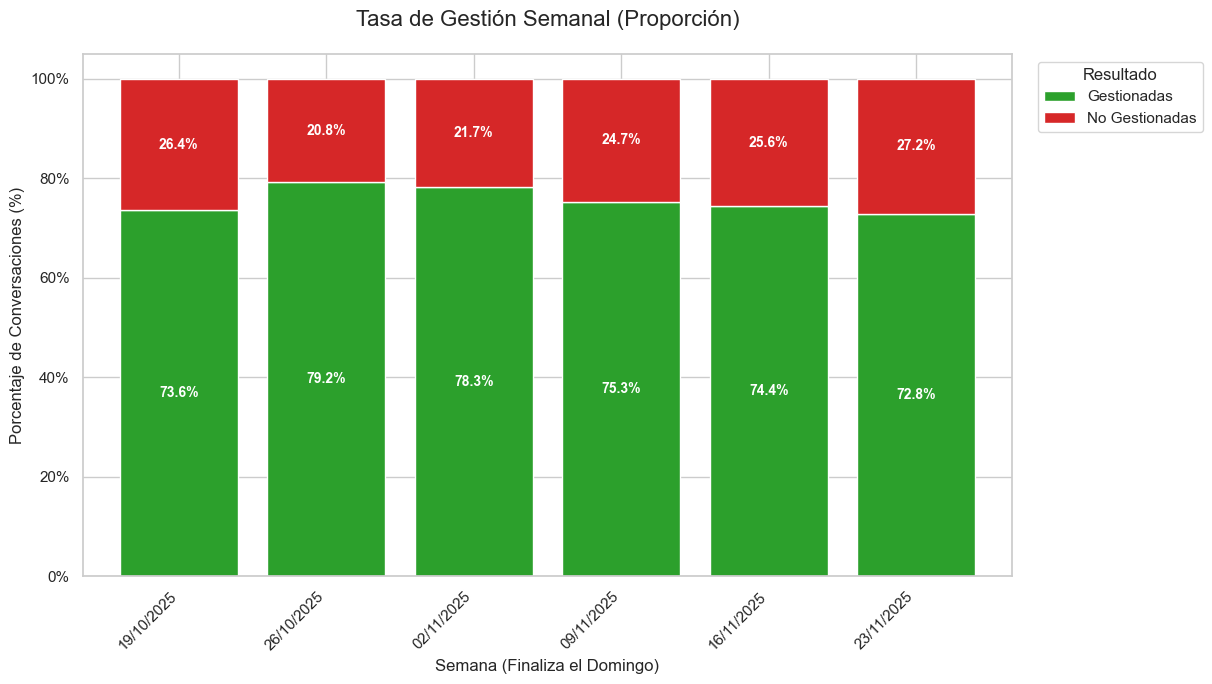

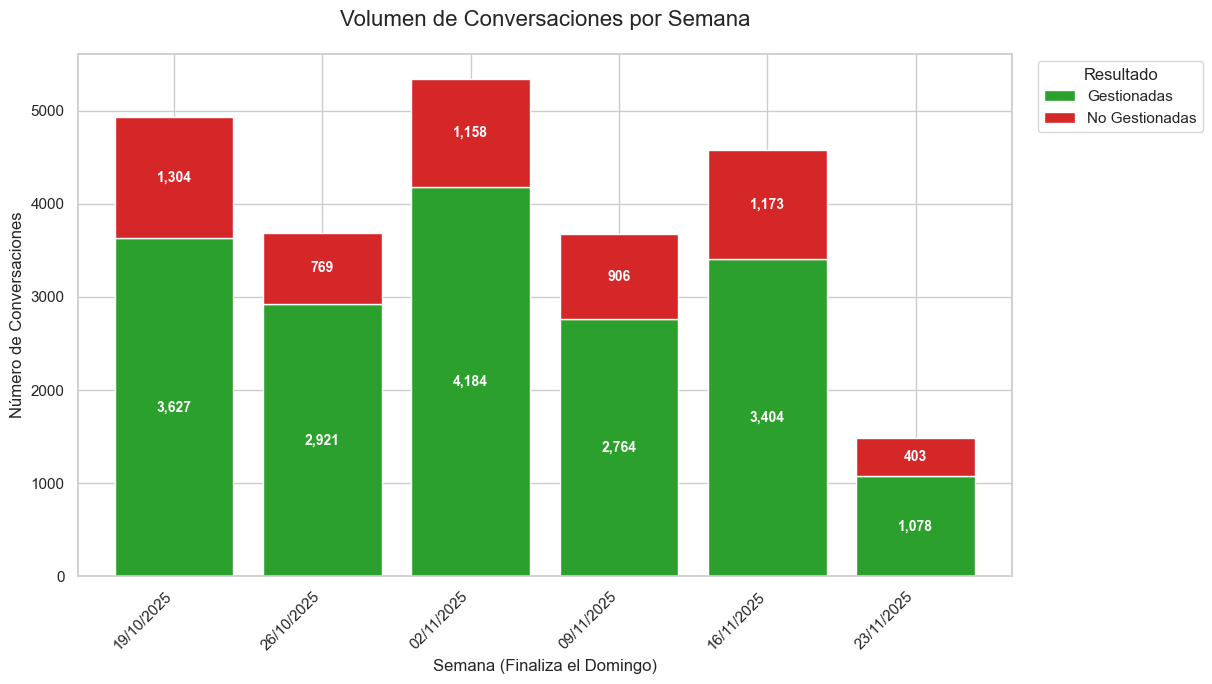


Los datos del análisis semanal se han exportado a 'gestion_semanal_corregido.csv'


grupo_principal,Gestionadas,No Gestionadas,Total,Tasa_Gestion_%
fecha,,,,
2025-10-19,3627,1304,4931,73.56
2025-10-26,2921,769,3690,79.16
2025-11-02,4184,1158,5342,78.32
2025-11-09,2764,906,3670,75.31
2025-11-16,3404,1173,4577,74.37
2025-11-23,1078,403,1481,72.79


In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

print("="*60)
print("ANÁLISIS SEMANAL MEJORADO (Estilo Adopción)")
print("="*60)

# Verificamos que el DataFrame corregido exista antes de proceder
if 'df_resultados_corregido' in locals():
    
    df_analisis = df_resultados_corregido.copy()

    # --- INICIO DEL BLOQUE TRY...EXCEPT CORREGIDO ---
    try:
        df_analisis.loc[:, 'fecha'] = pd.to_datetime(df_analisis['fecha'])

        # --- 1. Preparación de Datos ---
        # Usamos un método de agregación que cuenta directamente los valores en `grupo_principal`
        analisis_semanal = df_analisis.groupby(
            pd.Grouper(key='fecha', freq='W-SUN')
        )['grupo_principal'].value_counts().unstack(fill_value=0)
        
        # Renombrar columnas al estándar deseado
        analisis_semanal = analisis_semanal.rename(columns={
            'Gestionada Conecta': 'Gestionadas',
            'No Gestionada Conecta': 'No Gestionadas'
        })
        
        # Asegurarse de que ambas columnas existan, si no, crearlas con 0
        if 'Gestionadas' not in analisis_semanal:
            analisis_semanal['Gestionadas'] = 0
        if 'No Gestionadas' not in analisis_semanal:
            analisis_semanal['No Gestionadas'] = 0
        
        analisis_semanal['Total'] = analisis_semanal['Gestionadas'] + analisis_semanal['No Gestionadas']
        
        # --- Datos para Gráficos ---
        df_volumen = analisis_semanal[['Gestionadas', 'No Gestionadas']]
        df_porcentaje = df_volumen.div(df_volumen.sum(axis=1), axis=0) * 100

        # --- IMPRESIÓN DE RESUMEN ---
        print("Resumen de conversaciones por semana (con datos re-evaluados):")
        for fecha_fin, row in analisis_semanal.iterrows():
            fecha_ini = fecha_fin - pd.Timedelta(days=6)
            tasa_gestion = (row['Gestionadas'] / row['Total'] * 100) if row['Total'] > 0 else 0
            print(
                f"Semana {fecha_ini.strftime('%d/%m')} al {fecha_fin.strftime('%d/%m/%Y')}: "
                f"Gestionadas: {int(row['Gestionadas'])} | "
                f"No Gestionadas: {int(row['No Gestionadas'])} | "
                f"Total: {int(row['Total'])} | "
                f"Tasa de Gestión: {tasa_gestion:.2f}%"
            )

        # --- 2. GENERACIÓN DE GRÁFICOS ---
        if not analisis_semanal.empty:
            print("\nGenerando gráficos actualizados...")
            sns.set_theme(style="whitegrid")
            color_map_gestion = {"Gestionadas": "#2ca02c", "No Gestionadas": "#d62728"}

            # Gráfico 1: Barras Apiladas al 100% (PROPORCIÓN)
            ax1 = df_porcentaje.plot(kind='bar', stacked=True, figsize=(14, 7), color=[color_map_gestion.get(c) for c in df_porcentaje.columns], width=0.8)
            for container in ax1.containers:
                for bar in container:
                    height = bar.get_height()
                    if height > 5:
                        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1f}%', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            ax1.set_title('Tasa de Gestión Semanal (Proporción)', fontsize=16, pad=20)
            ax1.set_ylabel('Porcentaje de Conversaciones (%)')
            ax1.set_xlabel('Semana (Finaliza el Domingo)')
            ax1.legend(title='Resultado', bbox_to_anchor=(1.02, 1), loc='upper left')
            ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
            ax1.set_xticklabels([idx.strftime('%d/%m/%Y') for idx in df_porcentaje.index], rotation=45, ha='right')
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()

            # Gráfico 2: Barras Apiladas (VOLUMEN ABSOLUTO)
            ax2 = df_volumen.plot(kind='bar', stacked=True, figsize=(14, 7), color=[color_map_gestion.get(c) for c in df_volumen.columns], width=0.8)
            for container in ax2.containers:
                for bar in container:
                    height = bar.get_height()
                    if height > 0:
                        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:,.0f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            ax2.set_title('Volumen de Conversaciones por Semana', fontsize=16, pad=20)
            ax2.set_ylabel('Número de Conversaciones')
            ax2.set_xlabel('Semana (Finaliza el Domingo)')
            ax2.legend(title='Resultado', bbox_to_anchor=(1.02, 1), loc='upper left')
            ax2.set_xticklabels([idx.strftime('%d/%m/%Y') for idx in df_volumen.index], rotation=45, ha='right')
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            plt.show()
            
            # --- 3. EXPORTAR DATOS A CSV ---
            df_export_gestion = analisis_semanal.copy()
            df_export_gestion['Tasa_Gestion_%'] = (df_export_gestion['Gestionadas'] / df_export_gestion['Total'] * 100).round(2)
            output_filename_gestion = 'gestion_semanal_corregido.csv'
            df_export_gestion.to_csv(output_filename_gestion, index=True, sep=';', decimal='.')
            print(f"\nLos datos del análisis semanal se han exportado a '{output_filename_gestion}'")

    # --- ESTOS BLOQUES 'EXCEPT' FALTABAN ---
    except KeyError as e:
        print(f"❌ ERROR: La columna '{e.args[0]}' no se encontró. Verifica los nombres de las columnas.")
    except Exception as e:
        print(f"❌ Ocurrió un error inesperado durante el análisis semanal: {e}")

else:
    print("❌ ERROR: El DataFrame 'df_resultados_corregido' no fue encontrado.")
    
display(df_export_gestion)

In [202]:
import pandas as pd

# ==============================================================================
# INICIO DEL ANÁLISIS DE FUNNEL SOBRE DATOS ACTUALIZADOS
# ==============================================================================

# --- PASO 0: Seleccionar el DataFrame Correcto para el Análisis ---
print("="*60)
print("INICIANDO ANÁLISIS DE FUNNEL SOBRE DATOS ACTUALIZADOS")
print("="*60)

if 'df_resultados_corregido' in locals():
    print("✅ Se encontró 'df_resultados_corregido'. El análisis se ejecutará sobre los datos re-evaluados.")
    # Usamos una copia para cualquier modificación posterior
    df_analisis_final = df_resultados_corregido.copy()
else:
    print("⚠️  ADVERTENCIA: No se encontró 'df_resultados_corregido'.")
    print("   El análisis se ejecutará sobre los datos originales de 'df_resultados'.")
    df_analisis_final = df_resultados.copy()

# --- PREPARACIÓN INICIAL (Usando el DataFrame de análisis final) ---
df_analisis_final['calificacion_pregunta_1_mean'] = df_analisis_final['calificacion_pregunta_1_mean'].astype(float)
df_analisis_final['calificacion_pregunta_2_mean'] = df_analisis_final['calificacion_pregunta_2_mean'].astype(float)
df_analisis_final['calificacion_pregunta_10_mean'] = df_analisis_final['calificacion_pregunta_10_mean'].astype(float)
df_analisis_final['motivo_experto_count'] = df_analisis_final['motivo_experto_flag']
df_analisis_final['calificacion_combinada'] = df_analisis_final['calificacion_pregunta_2_mean'].fillna(df_analisis_final['calificacion_pregunta_10_mean'])

total_convs = df_analisis_final['conversation_id'].nunique()
print("\n" + "="*60)
print(f"Total conversaciones en el análisis: {total_convs}")
print("="*60)

# 1. PRIMERA CLASIFICACIÓN (Funnel)
primeros = df_analisis_final.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {int(row['flg_experto_sum'])} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_analisis_final[df_analisis_final['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
if ngc_convs > 0:
    ngc_sub = no_gestionada.groupby('subgrupo').agg(
        conversaciones=('conversation_id', 'nunique'),
        flg_experto_sum=('flg_experto_flag', 'sum'),
        motivo_experto_count=('motivo_experto_count', 'sum')
    ).reset_index()
    ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
    ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
    
    for _, row in ngc_sub.iterrows():
        conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
        aud_sub = df_analisis_final[df_analisis_final['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
        calif_validas = aud_sub['calificacion_combinada'].dropna()
        total_calificadas = calif_validas.shape[0]
        stats_string = f"Promedio (Media): {calif_validas.mean():.2f} | Mediana: {calif_validas.median():.2f}" if total_calificadas > 0 else "Sin calificaciones"
        print(f"{row['subgrupo']}: {row['conversaciones']} convers. ({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% total) | flg_experto: {int(row['flg_experto_sum'])} | motivo_experto: {int(row['motivo_experto_count'])} | Calif: {total_calificadas} | {stats_string}")
else:
    print("No hay conversaciones en 'No Gestionada Conecta'.")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_analisis_final[df_analisis_final['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
if gc_convs > 0:
    gc_sub = gestionada.groupby('subgrupo').agg(
        conversaciones=('conversation_id', 'nunique'),
        flg_experto_sum=('flg_experto_flag', 'sum'),
        motivo_experto_count=('motivo_experto_count', 'sum')
    ).reset_index()
    gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
    gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100

    for _, row in gc_sub.iterrows():
        conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
        aud_sub = df_analisis_final[df_analisis_final['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
        calif_validas = pd.to_numeric(aud_sub['calificacion_combinada'], errors='coerce').dropna()
        total_calificadas = calif_validas.shape[0]
        stats_string = f"Promedio (Media): {calif_validas.mean():.2f} | Mediana: {calif_validas.median():.2f}" if total_calificadas > 0 else "Sin calificaciones"
        print(f"{row['subgrupo']}: {row['conversaciones']} convers. ({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% total) | flg_experto: {int(row['flg_experto_sum'])} | motivo_experto: {int(row['motivo_experto_count'])} | Calif: {total_calificadas} | {stats_string}")
else:
    print("No hay conversaciones en 'Gestionada Conecta'.")


# 4. DETALLE DE CONVERSACIONES 'OTRO' (MODIFICADO)
print("\n" + "="*60)
print("Detalle de conversaciones clasificadas como 'Otro'")
print("="*60)

# Obtenemos los IDs de las conversaciones 'Otro' desde el análisis actualizado
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].unique().tolist()

if otros_ids:
    print(f"Se encontraron {len(otros_ids)} conversaciones en la categoría 'Otro'. Mostrando detalle...")
    # Suponiendo que 'df_merged_final' tiene todas las interacciones originales
    if 'df_merged_final' in locals():
        # Filtramos el DataFrame maestro de interacciones por los IDs de conversación
        # !!! CAMBIA 'fk_tbl_conversaciones_conecta2' si tu columna ID se llama diferente !!!
        otros_detalle = df_merged_final[df_merged_final['fk_tbl_conversaciones_conecta2'].isin(otros_ids)]
        # Mostramos las columnas relevantes para el análisis manual
        display(otros_detalle[['fk_tbl_conversaciones_conecta2', 'pregunta', 'respuesta', 'flg_experto', 'motivo_experto']])
    else:
        print("\nADVERTENCIA: El DataFrame 'df_merged_final' no está disponible para mostrar el detalle de las conversaciones 'Otro'.")
else:
    print("No se encontraron conversaciones en la categoría 'Otro'.")

INICIANDO ANÁLISIS DE FUNNEL SOBRE DATOS ACTUALIZADOS
✅ Se encontró 'df_resultados_corregido'. El análisis se ejecutará sobre los datos re-evaluados.

Total conversaciones en el análisis: 23691
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 17978 conversaciones (75.89% del total) | flg_experto==1: 1644 (6.94% del total)
No Gestionada Conecta: 5713 conversaciones (24.11% del total) | flg_experto==1: 722 (3.05% del total)

Desglose de No Gestionada Conecta
Preguntas temas no bancarios: 1333 convers. (23.33% de NGC, 5.63% total) | flg_experto: 136 | motivo_experto: 367 | Calif: 153 | Promedio (Media): 2.85 | Mediana: 3.00
Sin información: 3476 convers. (60.84% de NGC, 14.67% total) | flg_experto: 317 | motivo_experto: 1082 | Calif: 411 | Promedio (Media): 2.54 | Mediana: 3.00
Usuario solicitó paso a experto: 904 convers. (15.82% de NGC, 3.82% total) | flg_experto: 269 | motivo_experto: 585 | Calif: 173 | Promedio (Media): 2.80 | Mediana: 3.00

Desglose de Gestionada Conecta
Conecta Re


ANÁLISIS DETALLADO DE 'CALIFICACION_COMBINADA' CON MÉTRICAS DE EXPERTO
Total de registros con calificación válida para analizar: 2734


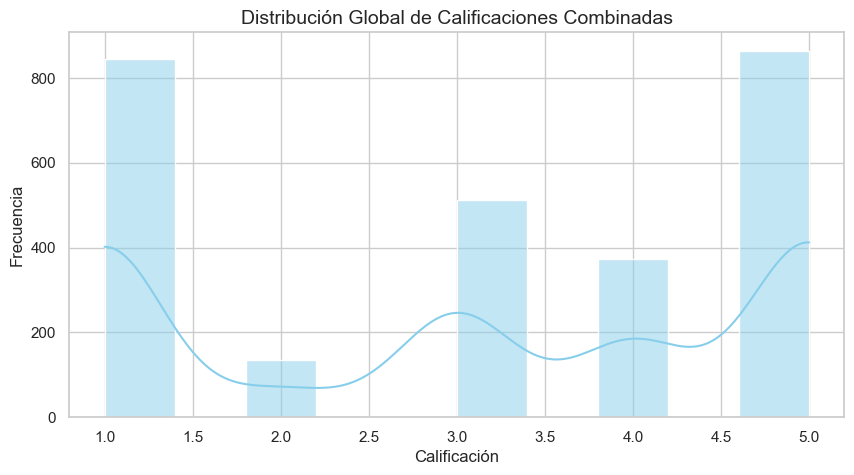


--- Estadísticas Globales ---
count    2734.00
mean        3.10
std         1.64
min         1.00
25%         1.00
50%         3.00
75%         5.00
max         5.00
Name: calificacion_combinada, dtype: float64

################################################################################
ANÁLISIS POR: GRUPO PRINCIPAL
################################################################################

Tabla Estadística Detallada (Grupo Principal):
Nota: 'Tasa_Oferta_Experto' indica el promedio de veces que se ofreció (o % si es 0/1).


,grupo_principal,N_Conversaciones,Calif_Promedio,Calif_Mediana,Calif_Std,Calif_Min,Calif_Max,Total_Oferta_Experto,Tasa_Oferta_Experto,Total_Paso_Experto,Tasa_Paso_Experto
0,Gestionada Conecta,1997,3.262,4.0,1.634,1.0,5.0,1070.0,0.536,691.0,0.346
1,No Gestionada Conecta,737,2.664,3.0,1.567,1.0,5.0,558.0,0.757,315.0,0.427


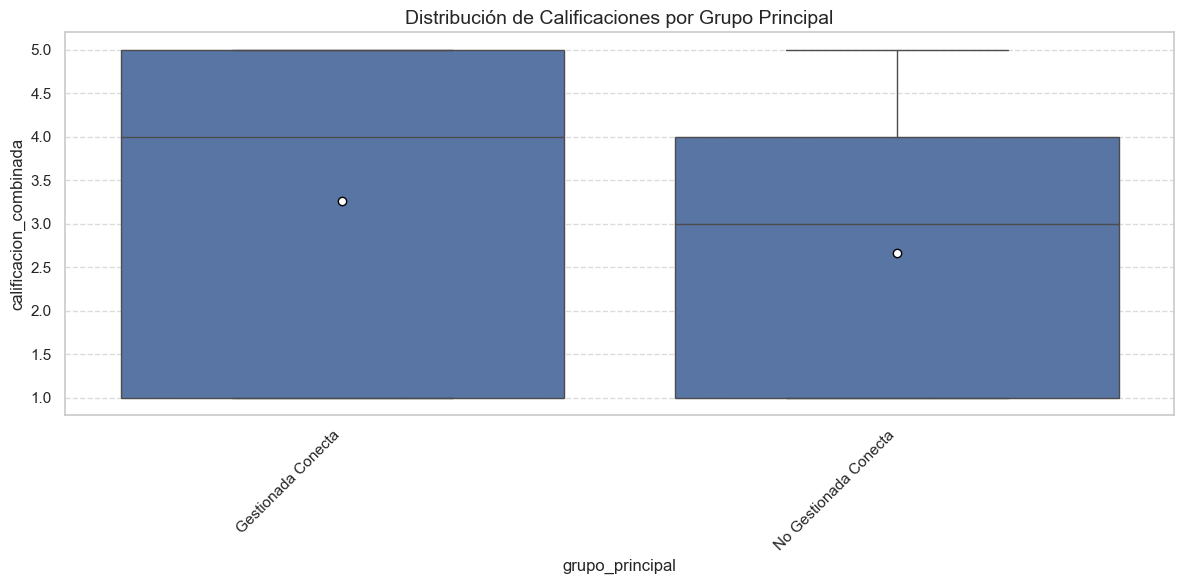

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\2274809849.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


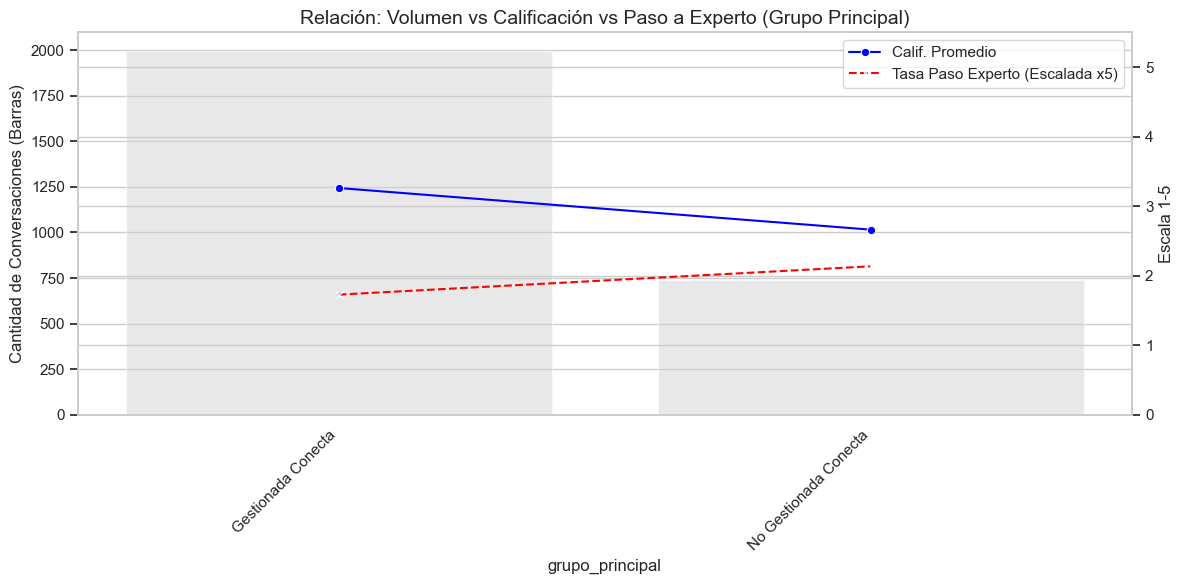


################################################################################
ANÁLISIS POR: GRUPO PRINCIPAL Y SUBGRUPO
################################################################################

Tabla Estadística Detallada (Grupo Principal y Subgrupo):
Nota: 'Tasa_Oferta_Experto' indica el promedio de veces que se ofreció (o % si es 0/1).


,grupo_combo,N_Conversaciones,Calif_Promedio,Calif_Mediana,Calif_Std,Calif_Min,Calif_Max,Total_Oferta_Experto,Tasa_Oferta_Experto,Total_Paso_Experto,Tasa_Paso_Experto
0,Gestionada Conecta -> Conecta Retuvo,927,3.773,5.0,1.537,1.0,5.0,0.0,0.000,0.0,0.000
2,No Gestionada Conecta -> Preguntas temas no ba...,153,2.850,3.0,1.584,1.0,5.0,105.0,0.686,56.0,0.366
1,Gestionada Conecta -> Ofreció PE,1070,2.820,3.0,1.586,1.0,5.0,1070.0,1.000,691.0,0.646
4,No Gestionada Conecta -> Usuario solicitó paso...,173,2.798,3.0,1.621,1.0,5.0,161.0,0.931,107.0,0.618
3,No Gestionada Conecta -> Sin información,411,2.538,3.0,1.529,1.0,5.0,292.0,0.710,152.0,0.370


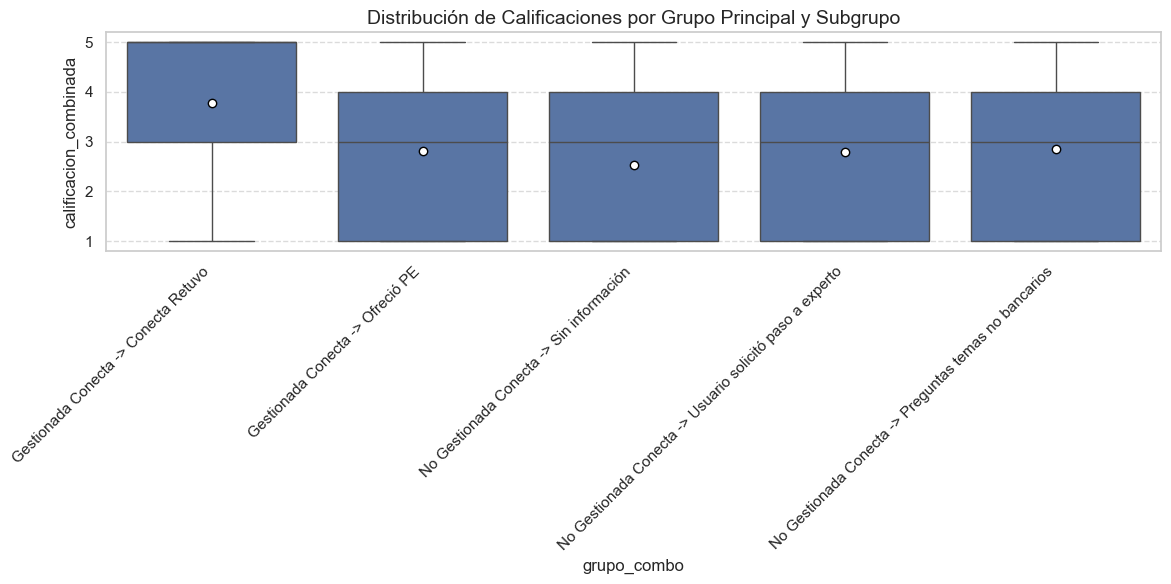

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\2274809849.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


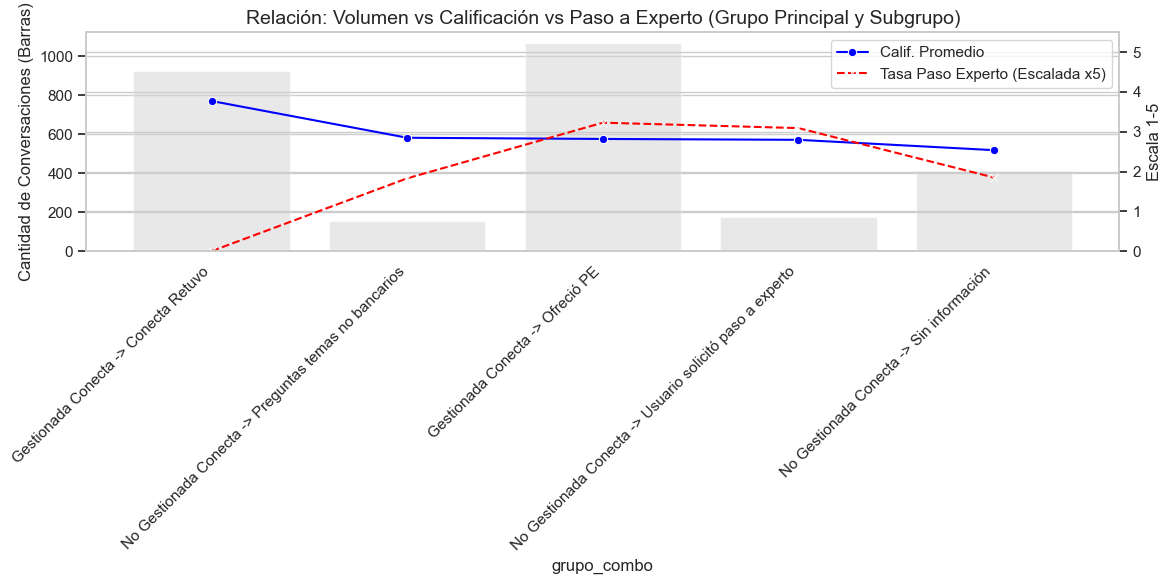


TOP CASOS CRÍTICOS (Calif <= 2 y NO se pasó a experto)
Se encontraron 655 conversaciones críticas sin experto.


,conversation_id,grupo_combo,calificacion_combinada,motivo_experto_count
18659,37603,Gestionada Conecta -> Ofreció PE,1.0,1.0
92,17999,Gestionada Conecta -> Ofreció PE,1.0,1.0
94,18001,Gestionada Conecta -> Ofreció PE,1.0,1.0
105,18012,Gestionada Conecta -> Conecta Retuvo,1.0,0.0
121,18028,Gestionada Conecta -> Ofreció PE,1.0,1.0
122,18029,Gestionada Conecta -> Ofreció PE,1.0,1.0
127,18034,Gestionada Conecta -> Ofreció PE,1.0,1.0
149,18057,Gestionada Conecta -> Conecta Retuvo,1.0,0.0
160,18069,Gestionada Conecta -> Ofreció PE,1.0,1.0
161,18070,Gestionada Conecta -> Ofreció PE,1.0,1.0


In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================================================
# ANÁLISIS ESTADÍSTICO Y VISUAL DE CALIFICACIONES (AMPLIADO)
# ==============================================================================

print("\n" + "="*80)
print("ANÁLISIS DETALLADO DE 'CALIFICACION_COMBINADA' CON MÉTRICAS DE EXPERTO")
print("="*80)

# 1. PREPARACIÓN DE DATOS
# ------------------------------------------------------------------------------
df_calif = df_analisis_final.dropna(subset=['calificacion_combinada']).copy()
df_calif['calificacion_combinada'] = pd.to_numeric(df_calif['calificacion_combinada'], errors='coerce')

# Aseguramos que las banderas de experto sean numéricas para poder sumarlas/promediarlas
df_calif['motivo_experto_count'] = pd.to_numeric(df_calif['motivo_experto_count'], errors='coerce').fillna(0)
df_calif['flg_experto_flag'] = pd.to_numeric(df_calif['flg_experto_flag'], errors='coerce').fillna(0)

# Creamos una columna combinada para el análisis detallado (Grupo + Subgrupo)
df_calif['grupo_combo'] = df_calif['grupo_principal'] + " -> " + df_calif['subgrupo']

df_calif = df_calif.dropna(subset=['calificacion_combinada'])

print(f"Total de registros con calificación válida para analizar: {len(df_calif)}")

# Configuración de estilo visual
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------------------------
# 2. DISTRIBUCIÓN GLOBAL
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.title('Distribución Global de Calificaciones Combinadas', fontsize=14)
sns.histplot(data=df_calif, x='calificacion_combinada', kde=True, bins=10, color='skyblue')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

print("\n--- Estadísticas Globales ---")
print(df_calif['calificacion_combinada'].describe().round(2))

# ------------------------------------------------------------------------------
# 3. FUNCIÓN DE ANÁLISIS INTEGRAL (Calificación + Experto)
# ------------------------------------------------------------------------------
def analizar_integral(df, columna_agrupacion, titulo):
    print("\n" + "#"*80)
    print(f"ANÁLISIS POR: {titulo.upper()}")
    print("#"*80)
    
    # A. TABLA RESUMEN ENRIQUECIDA
    # Agrupamos para obtener estadísticas de calificación Y métricas de experto
    stats = df.groupby(columna_agrupacion).agg({
        'calificacion_combinada': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'motivo_experto_count': ['sum', 'mean'], # Suma total y promedio (tasa de oferta)
        'flg_experto_flag': ['sum', 'mean']      # Suma total y promedio (tasa de confirmación)
    }).reset_index()
    
    # Aplanamos los nombres de columnas para que sea una tabla limpia
    stats.columns = [
        columna_agrupacion, 
        'N_Conversaciones', 'Calif_Promedio', 'Calif_Mediana', 'Calif_Std', 'Calif_Min', 'Calif_Max',
        'Total_Oferta_Experto', 'Tasa_Oferta_Experto', 
        'Total_Paso_Experto', 'Tasa_Paso_Experto'
    ]
    
    # Ordenamos por Calificación Promedio descendente
    stats = stats.sort_values(by='Calif_Promedio', ascending=False)
    
    print(f"\nTabla Estadística Detallada ({titulo}):")
    print("Nota: 'Tasa_Oferta_Experto' indica el promedio de veces que se ofreció (o % si es 0/1).")
    display(stats.round(3))

    # B. VISUALIZACIÓN: BOXPLOT (Distribución de Calificaciones)
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=columna_agrupacion, y='calificacion_combinada', 
                showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
    plt.title(f'Distribución de Calificaciones por {titulo}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # C. VISUALIZACIÓN: COMPARATIVA CALIFICACIÓN VS TASA PASO EXPERTO (Scatter/Barra)
    # Creamos un gráfico dual simple para ver si pasar a experto influye en la nota
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Barra: Cantidad de conversaciones
    sns.barplot(data=stats, x=columna_agrupacion, y='N_Conversaciones', color='lightgray', alpha=0.5, ax=ax1)
    ax1.set_ylabel('Cantidad de Conversaciones (Barras)')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Línea 1: Calificación Promedio
    ax2 = ax1.twinx()
    sns.lineplot(data=stats, x=columna_agrupacion, y='Calif_Promedio', marker='o', color='blue', label='Calif. Promedio', ax=ax2)
    
    # Línea 2: Tasa de Paso a Experto
    # Escalamos la tasa (0-1) a (1-5) visualmente o usamos otro eje, 
    # pero para simplicidad graficamos la tasa multiplicada por 5 para ver correlación visual
    stats['Tasa_Paso_Escalada'] = stats['Tasa_Paso_Experto'] * 5
    sns.lineplot(data=stats, x=columna_agrupacion, y='Tasa_Paso_Escalada', marker='x', color='red', linestyle='--', label='Tasa Paso Experto (Escalada x5)', ax=ax2)
    
    ax2.set_ylabel('Escala 1-5')
    ax2.set_ylim(0, 5.5)
    plt.title(f'Relación: Volumen vs Calificación vs Paso a Experto ({titulo})', fontsize=14)
    
    # Leyenda manual
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 4. EJECUCIÓN DE LOS ANÁLISIS
# ------------------------------------------------------------------------------

# A. NIVEL 1: GRUPO PRINCIPAL
analizar_integral(df_calif, 'grupo_principal', 'Grupo Principal')

# B. NIVEL 2: COMBINACIÓN GRUPO + SUBGRUPO
# Filtramos combinaciones con muy pocos datos (<3) para limpiar gráfico
conteo_combo = df_calif['grupo_combo'].value_counts()
combos_validos = conteo_combo[conteo_combo > 2].index.tolist()
df_calif_combo = df_calif[df_calif['grupo_combo'].isin(combos_validos)]

analizar_integral(df_calif_combo, 'grupo_combo', 'Grupo Principal y Subgrupo')

# ------------------------------------------------------------------------------
# 5. REVISIÓN RÁPIDA DE BAJAS CALIFICACIONES
# ------------------------------------------------------------------------------
print("\n" + "="*60)
print("TOP CASOS CRÍTICOS (Calif <= 2 y NO se pasó a experto)")
print("="*60)
# Buscamos casos donde el usuario reprobó y no hubo intervención humana
criticos = df_calif[
    (df_calif['calificacion_combinada'] <= 2) & 
    (df_calif['flg_experto_flag'] == 0)
].sort_values('calificacion_combinada')

if not criticos.empty:
    print(f"Se encontraron {len(criticos)} conversaciones críticas sin experto.")
    cols_ver = ['conversation_id', 'grupo_combo', 'calificacion_combinada', 'motivo_experto_count']
    display(criticos[cols_ver].head(10))
else:
    print("No se encontraron casos críticos bajo estos criterios.")

ANÁLISIS ESTRATÉGICO: EFICACIA DE LA RETENCIÓN AUTOMÁTICA
(Grupo: Gestionada Conecta -> Subgrupo: Conecta Retuvo)

1. VISIÓN MACRO: RENDIMIENTO GLOBAL DEL GRUPO
------------------------------------------------------------
Total Conversaciones Analizadas: 927
Promedio de Calificación: 3.77
Mediana de Calificación:  5.00


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\2867638187.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_retuvo, x='calificacion_combinada', palette='viridis')


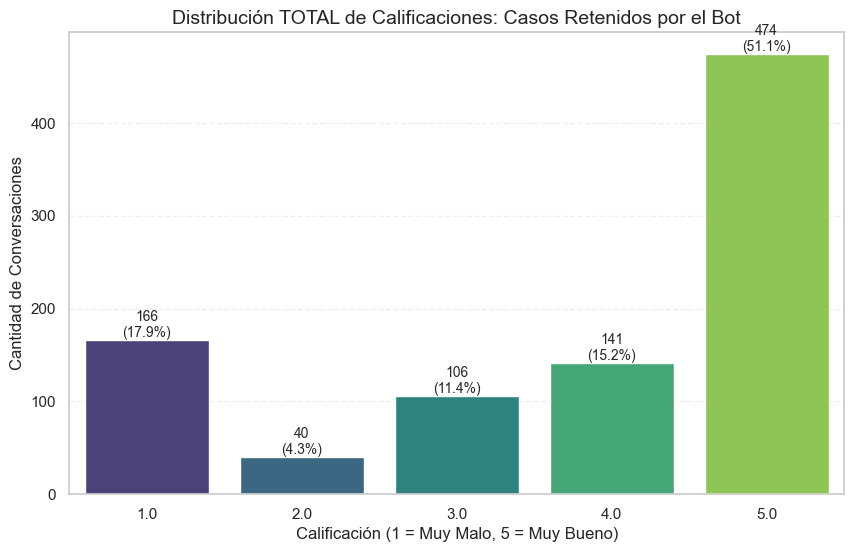

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\2867638187.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(data=df_criticos, x='calificacion_combinada', palette='Reds_r')


CONCLUSIÓN MACRO: El 66.3% de las veces, la retención es exitosa (Calif 4 o 5).
Esto valida que la base de conocimiento del bot es correcta para la mayoría de los casos.

2. VISIÓN MICRO: ANÁLISIS DE LA INSATISFACCIÓN (El 'Punto Ciego')
MÉTRICAS DE FRICCIÓN:
➤ Conversaciones con Calificación Baja (<= 3): 312
➤ Tasa de 'Falso Éxito': 33.66%
   (El Bot creyó resolver, pero 312 usuarios no estuvieron de acuerdo)


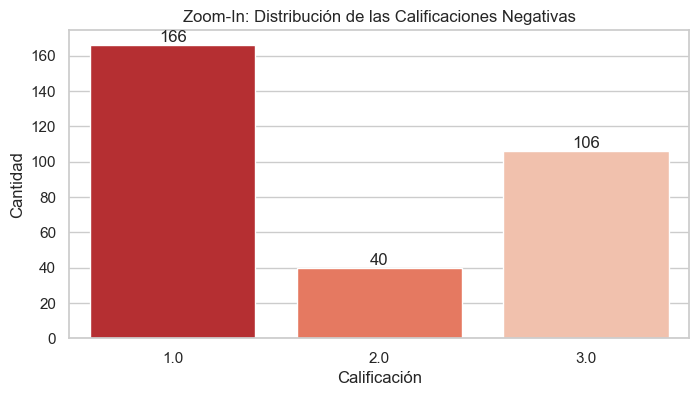


3. DIAGNÓSTICO DE TEMAS: ¿QUÉ ESTABAN PREGUNTANDO?
------------------------------------------------------------
TOP 15 PALABRAS CLAVE EN CONVERSACIONES FALLIDAS:
Estas palabras indican los temas donde el bot es 'terco' (retiene pero no satisface).
--------------------------------------------------
PALABRA              | FRECUENCIA
--------------------------------------------------
cuenta               | 48        
credito              | 26        
pago                 | 21        
davivienda           | 19        
formato              | 18        
cliente              | 18        
cómo                 | 18        
tarjeta              | 17        
portal               | 13        
simulador            | 13        
debito               | 13        
empresarial          | 12        
consulta             | 11        
radicar              | 11        
donde                | 10        
--------------------------------------------------


In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re

# ==============================================================================
# ANÁLISIS EN PROFUNDIDAD: GESTIONADA CONECTA -> CONECTA RETUVO
# ==============================================================================

print("="*80)
print("ANÁLISIS ESTRATÉGICO: EFICACIA DE LA RETENCIÓN AUTOMÁTICA")
print("(Grupo: Gestionada Conecta -> Subgrupo: Conecta Retuvo)")
print("="*80)

# 1. PREPARACIÓN Y LIMPIEZA DE DATOS
# ------------------------------------------------------------------------------
df_retuvo = df_analisis_final[
    (df_analisis_final['grupo_principal'] == 'Gestionada Conecta') & 
    (df_analisis_final['subgrupo'] == 'Conecta Retuvo')
].copy()

# Asegurar numéricos
df_retuvo['calificacion_combinada'] = pd.to_numeric(df_retuvo['calificacion_combinada'], errors='coerce')
df_retuvo = df_retuvo.dropna(subset=['calificacion_combinada'])

total_casos = len(df_retuvo)

# ==============================================================================
# PARTE 1: VISIÓN MACRO (El Panorama General)
# ==============================================================================
print(f"\n1. VISIÓN MACRO: RENDIMIENTO GLOBAL DEL GRUPO")
print(f"-"*60)
print(f"Total Conversaciones Analizadas: {total_casos}")
print(f"Promedio de Calificación: {df_retuvo['calificacion_combinada'].mean():.2f}")
print(f"Mediana de Calificación:  {df_retuvo['calificacion_combinada'].median():.2f}")

# Gráfico 1: Distribución TOTAL
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_retuvo, x='calificacion_combinada', palette='viridis')
plt.title('Distribución TOTAL de Calificaciones: Casos Retenidos por el Bot', fontsize=14)
plt.xlabel('Calificación (1 = Muy Malo, 5 = Muy Bueno)')
plt.ylabel('Cantidad de Conversaciones')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Añadir porcentajes sobre las barras
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_casos)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{int(y)}\n({percentage})', (x, y), ha='center', va='bottom', fontsize=10)

plt.show()

# Interpretación automática simple
pct_exito = len(df_retuvo[df_retuvo['calificacion_combinada'] >= 4]) / total_casos * 100
print(f"CONCLUSIÓN MACRO: El {pct_exito:.1f}% de las veces, la retención es exitosa (Calif 4 o 5).")
print(f"Esto valida que la base de conocimiento del bot es correcta para la mayoría de los casos.")

# ==============================================================================
# PARTE 2: VISIÓN MICRO (El Análisis de la Fricción)
# ==============================================================================
print(f"\n" + "="*80)
print(f"2. VISIÓN MICRO: ANÁLISIS DE LA INSATISFACCIÓN (El 'Punto Ciego')")
print(f"="*80)

# Filtramos los casos negativos (Calif <= 3)
df_criticos = df_retuvo[df_retuvo['calificacion_combinada'] <= 3].copy()
total_criticos = len(df_criticos)
pct_friccion = (total_criticos / total_casos) * 100

print(f"MÉTRICAS DE FRICCIÓN:")
print(f"➤ Conversaciones con Calificación Baja (<= 3): {total_criticos}")
print(f"➤ Tasa de 'Falso Éxito': {pct_friccion:.2f}%")
print(f"   (El Bot creyó resolver, pero {total_criticos} usuarios no estuvieron de acuerdo)")

if total_criticos > 0:
    # Gráfico 2: Distribución solo de los CRÍTICOS
    plt.figure(figsize=(8, 4))
    ax2 = sns.countplot(data=df_criticos, x='calificacion_combinada', palette='Reds_r')
    plt.title('Zoom-In: Distribución de las Calificaciones Negativas', fontsize=12)
    plt.xlabel('Calificación')
    plt.ylabel('Cantidad')
    
    for p in ax2.patches:
        ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom')
    plt.show()

    # ==============================================================================
    # PARTE 3: ANÁLISIS SEMÁNTICO (¿De qué hablaban estos usuarios?)
    # ==============================================================================
    if 'df_merged_final' in locals():
        print(f"\n3. DIAGNÓSTICO DE TEMAS: ¿QUÉ ESTABAN PREGUNTANDO?")
        print(f"-"*60)
        
        ids_criticos = df_criticos['conversation_id'].unique()
        
        # Filtramos df maestro para obtener el texto
        df_txt = df_merged_final[df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_criticos)]
        
        # Concatenamos todas las preguntas
        textos = df_txt['pregunta'].astype(str).tolist()
        full_text = " ".join(textos).lower()
        
        # Limpieza básica
        palabras = re.findall(r'\w+', full_text)
        stopwords = set(['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'es', 'lo', 'al', 'como', 'mas', 'pero', 'sus', 'le', 'ya', 'o', 'porque', 'muy', 'sin', 'sobre', 'tambien', 'me', 'mi', 'yo', 'hola', 'buenos', 'dias', 'favor', 'gracias', 'necesito', 'quiero', 'puedo', 'esta', 'estoy', 'tengo'])
        
        palabras_clean = [p for p in palabras if p not in stopwords and len(p) > 3 and not p.isdigit()]
        
        top_words = Counter(palabras_clean).most_common(15)
        
        print("TOP 15 PALABRAS CLAVE EN CONVERSACIONES FALLIDAS:")
        print("Estas palabras indican los temas donde el bot es 'terco' (retiene pero no satisface).")
        print("-" * 50)
        print(f"{'PALABRA':<20} | {'FRECUENCIA':<10}")
        print("-" * 50)
        for word, freq in top_words:
            print(f"{word:<20} | {freq:<10}")
        print("-" * 50)
    else:
        print("\n⚠️ No se pudo ejecutar el análisis de texto (falta df_merged_final).")
else:
    print("\n✅ ¡Increíble! No hay casos con calificación <= 3 en este grupo.")

In [319]:
df_analisis_final[df_analisis_final.REGIONAL.isna()]
# ==============================================================================
# PASO 1: CORRECCIÓN DE DATOS FALTANTES EN df_analisis_final
# ==============================================================================
print("="*80)
print("INICIANDO CORRECCIÓN DE DATOS FALTANTES (REGIONAL, CORREO, ETC.)")
print("="*80)

# Identificar las filas con REGIONAL nulo
filas_a_corregir = df_analisis_final[df_analisis_final['REGIONAL'].isna()]
ids_a_corregir = filas_a_corregir['conversation_id'].unique()

print(f"Se encontraron {len(ids_a_corregir)} conversaciones con 'REGIONAL' faltante.")

if len(ids_a_corregir) > 0:
    # Crear un DataFrame de referencia desde df_merged_final para obtener los datos correctos
    # Agrupamos por conversación y tomamos el primer valor no nulo para cada campo.
    print("Creando mapa de referencia desde 'df_merged_final'...")
    df_referencia = df_merged_final[df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_a_corregir)].groupby('fk_tbl_conversaciones_conecta2').agg(
        REGIONAL=('REGIONAL', 'first'),
        correo=('correo', 'first'),
        filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'size'),
        flg_experto_flag=('flg_experto', 'max'),
        motivo_experto_flag=('motivo_experto', lambda x: x.notna().any().astype(int))
    ).reset_index()
    
    # Renombrar la columna de ID para que coincida
    df_referencia = df_referencia.rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})

    # Establecer 'conversation_id' como índice en ambos DataFrames para una actualización eficiente
    df_analisis_final_indexed = df_analisis_final.set_index('conversation_id')
    df_referencia_indexed = df_referencia.set_index('conversation_id')

    # Actualizar las columnas en df_analisis_final usando los datos de referencia
    # El método update modifica el DataFrame in-place.
    print("Actualizando valores nulos...")
    df_analisis_final_indexed.update(df_referencia_indexed)
    
    # Resetear el índice para devolver el DataFrame a su estado original
    df_analisis_final = df_analisis_final_indexed.reset_index()
        
    # Verificación final
    nulos_restantes = df_analisis_final['REGIONAL'].isna().sum()
    print(f"\n✅ Corrección completada. Nulos restantes en 'REGIONAL': {nulos_restantes}")
    if nulos_restantes > 0:
        print("   -> Algunos IDs no se encontraron en 'df_merged_final'.")
else:
    print("✅ No se encontraron filas con 'REGIONAL' faltante. No se requiere corrección.")

# Mostrar una muestra de las filas que antes tenían nulos para verificar
df_analisis_final[df_analisis_final['conversation_id'].isin(ids_a_corregir)].head()

INICIANDO CORRECCIÓN DE DATOS FALTANTES (REGIONAL, CORREO, ETC.)
Se encontraron 0 conversaciones con 'REGIONAL' faltante.
✅ No se encontraron filas con 'REGIONAL' faltante. No se requiere corrección.


,conversation_id,grupo_principal,subgrupo,flg_experto_flag,motivo_experto_flag,motivo_experto_unicos,REGIONAL,calificacion_pregunta_1_mean,calificacion_pregunta_2_mean,fecha,filas_por_conversacion,correo,calificacion_pregunta_10_mean,motivo_experto_count,calificacion_combinada


In [349]:
import textwrap

# ==============================================================================
# LECTOR DE CONVERSACIONES: CASOS CRÍTICOS (Retenidos con Mala Nota)
# ==============================================================================

print("="*80)
print("TRANSCRIPCIÓN DE CONVERSACIONES: 'CONECTA RETUVO' + CALIFICACIÓN BAJA (1-2)")
print("="*80)

# 1. OBTENER LOS IDs DE LAS CONVERSACIONES "QUEJONAS"
# ------------------------------------------------------------------------------
# Filtramos: Gestionada -> Retuvo -> Calif <= 2 (Detractores fuertes)
# df_quejas = df_analisis_final[
    # (df_analisis_final['grupo_principal'] == 'Gestionada Conecta') & 
    # (df_analisis_final['subgrupo'] == 'Conecta Retuvo') & 
    # (df_analisis_final['calificacion_combinada'] <= 5)
# ].copy()

df_quejas = df_analisis_final.copy()

ids_quejas = df_quejas['conversation_id'].unique()
cantidad = len(ids_quejas)

print(f"Se encontraron {cantidad} conversaciones críticas para leer.")
print("Mostrando una muestra de las primeras 10...\n")
# ==============================================================================
# EXPORTACIÓN DE CONVERSACIONES CRÍTICAS A CSV
# ==============================================================================
print("\n" + "="*80)
print("INICIANDO EXPORTACIÓN DE CONVERSACIONES CRÍTICAS A CSV")
print("="*80)

# Usamos el df_quejas que ya contiene las conversaciones críticas
if 'df_merged_final' in locals() and 'df_quejas' in locals() and not df_quejas.empty:
    
    ids_criticas = df_quejas['conversation_id'].unique()
    print(f"Se exportarán {len(ids_criticas)} conversaciones críticas.")

    # 1. Función para consolidar el diálogo de una conversación con el nuevo formato
    def consolidar_dialogo(grupo):
        dialogo_completo = []
        # Ordenar por fecha para asegurar el orden cronológico
        grupo = grupo.sort_values(by='fecha_hora_inicio', ascending=True)
        for _, row in grupo.iterrows():
            pregunta = str(row.get('pregunta', '[sin pregunta]')).strip()
            respuesta = str(row.get('respuesta', '[sin respuesta]')).strip()
            calificacion = row.get('calificacion')

            # Determinar el ícono de calificación
            icono_calif = ""
            # Usar pd.notna() para verificar si el valor no es nulo antes de comparar
            if pd.notna(calificacion):
                if calificacion == 'Bien':
                    icono_calif = "👍"
                elif calificacion == 'Mal':
                    icono_calif = "👎"
            
            # Construir la línea del agente con o sin calificación
            linea_agente = "🤖 Conecta+"
            if icono_calif:
                linea_agente += f" (Calificación: {icono_calif}):"
            else:
                linea_agente += ":"

            # Nuevo formato de exportación
            dialogo_completo.append(f"👤 USUARIO: {pregunta}\n\n{linea_agente} {respuesta}")
        return "\n\n---\n\n".join(dialogo_completo)


    # 2. Calcular métricas adicionales por conversación (Duración, Bien/Mal)
    print("Calculando métricas adicionales (Duración, Calificaciones Bien/Mal)...")
    df_metricas = df_merged_final[df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_criticas)].groupby('fk_tbl_conversaciones_conecta2').agg(
        fecha_inicio_conv=('fecha_hora_inicio', 'min'),
        fecha_fin_conv=('fecha_hora_fin', 'max'),
        interacciones_bien=('calificacion', lambda x: (x == 'Bien').sum()),
        interacciones_mal=('calificacion', lambda x: (x == 'Mal').sum())
    ).reset_index()
    
    # Calcular duración
    df_metricas['duracion_conversacion'] = df_metricas['fecha_fin_conv'] - df_metricas['fecha_inicio_conv']
    print("✅ Métricas adicionales calculadas.")

    # 3. Filtrar y agrupar solo las interacciones de las conversaciones críticas
    print("Consolidando diálogos de conversaciones críticas...")
    df_dialogos_criticos = (
        df_merged_final[df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_criticas)]
        .groupby('fk_tbl_conversaciones_conecta2')
        .apply(consolidar_dialogo)
        .reset_index(name='conversacion_texto')
    )
    print(f"✅ Se consolidaron {len(df_dialogos_criticos)} diálogos.")

    # 4. Unir los diálogos y las métricas con el DataFrame de quejas
    print("Uniendo diálogos y métricas con los metadatos de las quejas...")
    df_export = pd.merge(
        df_quejas,
        df_dialogos_criticos,
        left_on='conversation_id',
        right_on='fk_tbl_conversaciones_conecta2',
        how='inner'
    )
    df_export = pd.merge(
        df_export,
        df_metricas,
        left_on='conversation_id',
        right_on='fk_tbl_conversaciones_conecta2',
        how='left',
        suffixes=('', '_duplicado')
    )


    # 5. Seleccionar y renombrar las columnas finales
    columnas_requeridas = {
        'conversation_id': 'ID Conversacion',
        'fecha': 'Fecha',
        'duracion_conversacion': 'Duracion Conversacion',
        'conversacion_texto': 'Conversacion',
        'correo': 'Correo',
        'flg_experto_flag': 'Paso a Experto (Flag)',
        'motivo_experto_flag': 'Ofrecio Experto (Flag)',
        'grupo_principal': 'Grupo Principal',
        'subgrupo': 'Subgrupo',
        'REGIONAL': 'Regional',
        'calificacion_combinada': 'Calificacion Usuario',
        'filas_por_conversacion': 'Interacciones',
        'interacciones_bien': 'Interacciones Bien',
        'interacciones_mal': 'Interacciones Mal',
        'calificacion_pregunta_1': 'calificacion_pregunta_1',
        'calificacion_pregunta_2': 'calificacion_pregunta_2',
        'calificacion_pregunta_3': 'calificacion_pregunta_3',
        'calificacion_pregunta_4': 'calificacion_pregunta_4',
        'calificacion_pregunta_5': 'calificacion_pregunta_5',
        'calificacion_pregunta_6': 'calificacion_pregunta_6',
        'calificacion_pregunta_7': 'calificacion_pregunta_7',
        'calificacion_pregunta_8': 'calificacion_pregunta_8',
        'calificacion_pregunta_9': 'calificacion_pregunta_9',
        'calificacion_pregunta_10': 'calificacion_pregunta_10',
        'NRO_IP_USUARIO': 'NRO_IP_USUARIO',
        'ESTADO_INTERACCION': 'ESTADO_INTERACCION',
        'TRANSCRIPCION_CLIENTE': 'TRANSCRIPCION_CLIENTE',
        'TRANSCRIPCION_ASESOR': 'TRANSCRIPCION_ASESOR'
    }
    
    # Asegurarse de que todas las columnas existan en df_export antes de seleccionar
    columnas_existentes = [col for col in columnas_requeridas.keys() if col in df_export.columns]
    df_final_export = df_export[columnas_existentes].rename(columns=columnas_requeridas)

    # 6. Renombrar columnas de calificación con el texto de la pregunta
    print("Renombrando columnas de calificación...")
    if 'preguntas' in locals():
        id_to_pregunta = dict(zip(
            preguntas['id_tbl_preguntas_encuesta_chat_ia_conecta2'],
            preguntas['pregunta']
        ))
        nuevo_nombre = {}
        for i in range(1, 11):
            col_original = f'calificacion_pregunta_{i}'
            if col_original in df_final_export.columns:
                pregunta_texto = id_to_pregunta.get(i)
                if pregunta_texto:
                    nuevo_nombre[col_original] = pregunta_texto[:100]
        df_final_export = df_final_export.rename(columns=nuevo_nombre)
        print("✅ Columnas de calificación renombradas.")
    else:
        print("⚠️  Advertencia: El DataFrame 'preguntas' no fue encontrado. No se renombraron las columnas de calificación.")

    # 7. Guardar en CSV
    output_filename = 'exportacion_conversaciones_criticas.csv'
    df_final_export.to_csv(output_filename, index=False, sep=';', encoding='utf-8-sig')
    
    print("\n" + "="*80)
    print(f"✅ EXPORTACIÓN COMPLETADA: Se guardó el archivo '{output_filename}'")
    print(f"   Total de filas (conversaciones críticas) exportadas: {len(df_final_export)}")
    print("="*80)
    
    # Mostrar una muestra del resultado
    display(df_final_export.head())

elif 'df_quejas' not in locals() or df_quejas.empty:
    print("✅ No se encontraron conversaciones críticas para exportar.")
else:
    print("❌ ERROR: No se encontró el DataFrame 'df_merged_final' para la exportación.")

TRANSCRIPCIÓN DE CONVERSACIONES: 'CONECTA RETUVO' + CALIFICACIÓN BAJA (1-2)
Se encontraron 23691 conversaciones críticas para leer.
Mostrando una muestra de las primeras 10...


INICIANDO EXPORTACIÓN DE CONVERSACIONES CRÍTICAS A CSV
Se exportarán 23691 conversaciones críticas.
Calculando métricas adicionales (Duración, Calificaciones Bien/Mal)...
✅ Métricas adicionales calculadas.
Consolidando diálogos de conversaciones críticas...


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\2539230645.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(consolidar_dialogo)


✅ Se consolidaron 23687 diálogos.
Uniendo diálogos y métricas con los metadatos de las quejas...
Renombrando columnas de calificación...
✅ Columnas de calificación renombradas.

✅ EXPORTACIÓN COMPLETADA: Se guardó el archivo 'exportacion_conversaciones_criticas.csv'
   Total de filas (conversaciones críticas) exportadas: 23687


,ID Conversacion,Fecha,Duracion Conversacion,Conversacion,Correo,Paso a Experto (Flag),Ofrecio Experto (Flag),Grupo Principal,Subgrupo,Regional,Calificacion Usuario,Interacciones,Interacciones Bien,Interacciones Mal
0,17903,2025-10-20 00:00:00,0 days 00:10:30,👤 USUARIO: Me puedes ayudar por favor con una ...,mdlondon@proveedores.davivienda.com,0.0,1.0,Gestionada Conecta,Ofreció PE,CALL CENTER,NaN,4.0,0,0
1,17904,2025-10-20 00:00:00,2 days 04:09:25,👤 USUARIO: Si la tarjeta posee sobre cupo se p...,juan.montoyan@proveedores.davivienda.com,0.0,0.0,Gestionada Conecta,Conecta Retuvo,CALL CENTER,NaN,1.0,0,0
2,17905,2025-10-20 00:00:00,0 days 00:05:05,👤 USUARIO: como aplican los retos de exoneraci...,jeimmy.roncancio@davivienda.com,0.0,0.0,Gestionada Conecta,Conecta Retuvo,CALL CENTER,NaN,2.0,0,0
3,17906,2025-10-20 00:00:00,0 days 00:08:29,👤 USUARIO: donde consultar la vigencia de reto...,jeimmy.roncancio@davivienda.com,0.0,0.0,Gestionada Conecta,Conecta Retuvo,CALL CENTER,NaN,2.0,0,0
4,17907,2025-10-20 00:00:00,0 days 00:08:53,👤 USUARIO: cobis_13 que es\n\n🤖 Conecta+: Por ...,jeimmy.roncancio@davivienda.com,0.0,1.0,Gestionada Conecta,Ofreció PE,CALL CENTER,NaN,2.0,0,1


In [ ]:
# ===== MUESTRA DE 2000 CONVERSACIONES RECIENTES (>= 2025-10-13) =====
print("="*80)
print("PREPARANDO MUESTRA PARA AUDITORÍA CON IA")
print("="*80)

# 1. Asegurar que Fecha es datetime
if 'Fecha' in df_final_export.columns:
    df_final_export['Fecha'] = pd.to_datetime(df_final_export['Fecha'], errors='coerce')
    fecha_col = 'Fecha'
elif 'fecha_inicio_conv' in df_final_export.columns:
    df_final_export['fecha_inicio_conv'] = pd.to_datetime(df_final_export['fecha_inicio_conv'], errors='coerce')
    fecha_col = 'fecha_inicio_conv'
else:
    raise ValueError("No se encontró columna de fecha en df_final_export")

# 2. Filtrar por fecha >= 2025-10-13
fecha_corte = pd.Timestamp('2025-10-13')
df_recientes = df_final_export[df_final_export[fecha_col] >= fecha_corte].copy()

print(f"\n📊 Estadísticas pre-filtrado:")
print(f"   Total conversaciones en df_final_export: {len(df_final_export):,}")
print(f"   Conversaciones desde {fecha_corte.date()}: {len(df_recientes):,}")

if len(df_recientes) == 0:
    print(f"\n⚠️  WARNING: No hay conversaciones desde {fecha_corte.date()}")
    print(f"   Fecha más reciente disponible: {df_final_export[fecha_col].max()}")
    # Usar todas las conversaciones disponibles si no hay desde la fecha corte
    df_recientes = df_final_export.copy()
    print(f"   Usando todas las {len(df_recientes):,} conversaciones disponibles")

# 3. Tomar muestra de 2000 conversaciones (o todas si hay menos)
TAMAÑO_MUESTRA = 2000
n_muestra = min(TAMAÑO_MUESTRA, len(df_recientes))

df_muestra_auditoria = df_recientes.sample(n=n_muestra, random_state=42).reset_index(drop=True)

print(f"\n✅ Muestra generada:")
print(f"   Tamaño: {len(df_muestra_auditoria):,} conversaciones")
print(f"   Rango fechas: {df_muestra_auditoria[fecha_col].min().date()} → {df_muestra_auditoria[fecha_col].max().date()}")

# 4. Verificar que tienen conversación consolidada
sin_conversacion = df_muestra_auditoria['Conversacion'].isna().sum()
if sin_conversacion > 0:
    print(f"   ⚠️  Conversaciones sin texto: {sin_conversacion}")
    df_muestra_auditoria = df_muestra_auditoria[df_muestra_auditoria['Conversacion'].notna()]
    print(f"   Muestra ajustada: {len(df_muestra_auditoria):,} conversaciones")

# 5. Estadísticas adicionales
print(f"\n📋 Distribución por grupo:")
if 'Grupo Principal' in df_muestra_auditoria.columns:
    dist_grupo = df_muestra_auditoria['Grupo Principal'].value_counts()
    for grupo, count in dist_grupo.items():
        print(f"   {grupo}: {count:,} ({count/len(df_muestra_auditoria)*100:.1f}%)")

if 'Regional' in df_muestra_auditoria.columns:
    print(f"\n📋 Distribución por regional (top 5):")
    dist_regional = df_muestra_auditoria['Regional'].value_counts().head(5)
    for regional, count in dist_regional.items():
        print(f"   {regional}: {count:,} ({count/len(df_muestra_auditoria)*100:.1f}%)")

print("="*80)

# Mostrar primeras filas
display(df_muestra_auditoria[['ID Conversacion', fecha_col, 'Conversacion', 'Interacciones']].head())

In [ ]:
# ===== AUDITORÍA CON IA - PROCESAMIENTO INCREMENTAL =====
print("="*80)
print("EJECUTANDO AUDITORÍA CON IA")
print("="*80)

from datetime import datetime
import time

# Configuración
ARCHIVO_RESULTADOS = "auditoria_conversaciones_resultados.csv"
BATCH_SIZE = 20  # Guardar cada 20 conversaciones
DELAY_BETWEEN_CALLS = 0.3  # Segundos entre llamadas API

# 1. Cargar resultados previos si existen
if os.path.exists(ARCHIVO_RESULTADOS):
    df_resultados_previos = pd.read_csv(ARCHIVO_RESULTADOS)
    ids_procesados = set(df_resultados_previos['ID Conversacion'].unique())
    print(f"\n✅ Archivo de resultados encontrado: {ARCHIVO_RESULTADOS}")
    print(f"   Conversaciones ya procesadas: {len(ids_procesados):,}")
else:
    df_resultados_previos = pd.DataFrame()
    ids_procesados = set()
    print(f"\n📝 Nuevo archivo de resultados: {ARCHIVO_RESULTADOS}")
    print(f"   No hay conversaciones procesadas previamente")

# 2. Filtrar conversaciones pendientes de procesar
df_pendientes = df_muestra_auditoria[~df_muestra_auditoria['ID Conversacion'].isin(ids_procesados)].copy()

print(f"\n📊 Estado del procesamiento:")
print(f"   Total en muestra: {len(df_muestra_auditoria):,}")
print(f"   Ya procesadas: {len(ids_procesados):,}")
print(f"   Pendientes: {len(df_pendientes):,}")

if len(df_pendientes) == 0:
    print(f"\n🎉 ¡Todas las conversaciones ya fueron auditadas!")
else:
    print(f"\n🚀 Iniciando auditoría de {len(df_pendientes):,} conversaciones...")
    print(f"   Tiempo estimado: ~{(len(df_pendientes) * DELAY_BETWEEN_CALLS / 60):.1f} minutos")
    print("="*80)
    
    # 3. Buffer para acumular resultados
    buffer = []
    errores = 0
    inicio_proceso = datetime.now()
    
    # 4. Loop de auditoría
    for idx, (index, row) in enumerate(df_pendientes.iterrows(), 1):
        try:
            # Obtener conversación
            conversacion_texto = row['Conversacion']
            id_conversacion = row['ID Conversacion']
            
            # Auditar con IA
            resultado_auditoria = auditar_conversacion(conversacion_texto)
            
            # Agregar metadatos
            resultado_auditoria['ID Conversacion'] = id_conversacion
            resultado_auditoria['timestamp_auditoria'] = datetime.now().isoformat()
            
            # Agregar al buffer
            buffer.append(resultado_auditoria)
            
            # Progress tracking cada 10
            if idx % 10 == 0:
                progreso_pct = (idx / len(df_pendientes)) * 100
                tiempo_transcurrido = (datetime.now() - inicio_proceso).total_seconds()
                velocidad = idx / tiempo_transcurrido if tiempo_transcurrido > 0 else 0
                tiempo_restante = (len(df_pendientes) - idx) / velocidad if velocidad > 0 else 0
                
                print(f"   📈 Progreso: {idx}/{len(df_pendientes)} ({progreso_pct:.1f}%) | "
                      f"Velocidad: {velocidad:.1f} conv/s | "
                      f"Tiempo restante: {tiempo_restante/60:.1f} min | "
                      f"Errores: {errores}")
            
            # Guardar batch
            if len(buffer) >= BATCH_SIZE:
                df_batch = pd.DataFrame(buffer)
                
                if os.path.exists(ARCHIVO_RESULTADOS):
                    df_batch.to_csv(ARCHIVO_RESULTADOS, mode='a', header=False, index=False)
                else:
                    df_batch.to_csv(ARCHIVO_RESULTADOS, mode='w', header=True, index=False)
                
                print(f"   💾 Guardado batch de {len(buffer)} conversaciones")
                buffer = []
            
            # Delay para evitar rate limit
            time.sleep(DELAY_BETWEEN_CALLS)
            
        except Exception as e:
            errores += 1
            print(f"   ❌ Error en conversación {id_conversacion}: {str(e)[:100]}")
            continue
    
    # 5. Guardar remanente del buffer
    if buffer:
        df_batch = pd.DataFrame(buffer)
        
        if os.path.exists(ARCHIVO_RESULTADOS):
            df_batch.to_csv(ARCHIVO_RESULTADOS, mode='a', header=False, index=False)
        else:
            df_batch.to_csv(ARCHIVO_RESULTADOS, mode='w', header=True, index=False)
        
        print(f"\n💾 Guardado batch final de {len(buffer)} conversaciones")
    
    # 6. Resumen final
    tiempo_total = (datetime.now() - inicio_proceso).total_seconds()
    print("\n" + "="*80)
    print("✅ AUDITORÍA COMPLETADA")
    print("="*80)
    print(f"   Procesadas en esta ejecución: {len(df_pendientes) - errores:,}")
    print(f"   Errores: {errores}")
    print(f"   Tiempo total: {tiempo_total/60:.1f} minutos")
    print(f"   Velocidad promedio: {(len(df_pendientes) - errores) / tiempo_total:.2f} conv/s")
    print(f"   Archivo: {ARCHIVO_RESULTADOS}")
    print("="*80)

# 7. Cargar resultados completos
df_resultados_completos = pd.read_csv(ARCHIVO_RESULTADOS)
print(f"\n📊 Total conversaciones auditadas: {len(df_resultados_completos):,}")

# 8. Merge con datos originales
df_auditoria_final = df_muestra_auditoria.merge(
    df_resultados_completos,
    on='ID Conversacion',
    how='left'
)

print(f"   DataFrame final: {len(df_auditoria_final):,} filas")
print(f"   Con resultados IA: {df_auditoria_final['calidad_pregunta_score'].notna().sum():,}")

display(df_auditoria_final.head())

In [324]:
# Convertir los correos únicos a un DataFrame y exportarlo a CSV
pd.DataFrame(df_final_export['Correo'].unique(), columns=['Correo']).to_csv('correos_unicos_criticos.csv', index=False)

print("Archivo 'correos_unicos_criticos.csv' generado con los correos únicos.")

Archivo 'correos_unicos_criticos.csv' generado con los correos únicos.


In [ ]:
def auditar_conversacion(texto_conversacion, retry_count=0):
    """
    Analiza una conversación bancaria con criterios mejorados y métricas numéricas.
    Formato esperado: Consolidado con 👤 USUARIO, 🤖 Conecta+, y calificaciones 👍👎
    
    CORRECCIÓN: Maneja si la IA devuelve una lista en lugar de un dict.
    """
    
    prompt = f"""
Eres un Auditor de Calidad Bancario Senior. Analiza la conversación entre un Funcionario y el Bot 'Conecta+'.

FORMATO DE CONVERSACIÓN:
- 👤 USUARIO: pregunta del funcionario
- 🤖 Conecta+: respuesta del bot
- Calificaciones: 👍 (Bien) o 👎 (Mal)
- Separador: ---

TRANSCRIPCIÓN:
'''
{texto_conversacion}
'''

Evalúa las 3 DIMENSIONES siguientes con CRITERIOS ESPECÍFICOS:

═══════════════════════════════════════════════════════════════
DIMENSIÓN 1: CALIDAD DE LA PREGUNTA DEL USUARIO
═══════════════════════════════════════════════════════════════

CRITERIOS NUMÉRICOS (calidad_pregunta_score):

1.0 (EXCELENTE) - Debe cumplir TODOS estos criterios:
  ✓ Verbo de acción claro (consultar, activar, bloquear, solicitar, etc.)
  ✓ Objeto específico mencionado (tarjeta X, crédito Y, cliente Z)
  ✓ Contexto suficiente (fechas, montos, identificadores si aplica)
  ✓ Sin ambigüedades gramaticales
  Ejemplo: "¿Cómo puedo consultar el saldo disponible de la tarjeta de crédito del cliente con cédula 123456789?"

0.7 (BUENA) - Cumple 3 de 4 criterios:
  ✓ Verbo presente pero genérico
  ✓ Objeto mencionado pero sin detalles
  ✓ Contexto parcial
  Ejemplo: "¿Cómo consulto el saldo de una tarjeta?"

0.5 (REGULAR) - Cumple 2 de 4 criterios:
  ✓ Acción implícita (no explícita)
  ✓ Objeto ambiguo o genérico
  Ejemplo: "¿Qué pasa con las tarjetas bloqueadas?"

0.3 (DEFICIENTE) - Cumple 1 de 4 criterios:
  ✓ Solo menciona tema sin acción clara
  Ejemplo: "Información sobre créditos"

0.0 (MAL) - No cumple ningún criterio:
  ✗ Pregunta incoherente, fuera de contexto bancario, o vacía
  Ejemplo: "Hola", "???", "No entiendo nada"

═══════════════════════════════════════════════════════════════
DIMENSIÓN 2: INTENCIÓN DEL USUARIO (intencion_usuario_bool)
═══════════════════════════════════════════════════════════════

TRUE (Intención Clara) - TODOS estos elementos:
  ✓ Estructura: [ACCIÓN] + [OBJETO BANCARIO]
  ✓ Acción: verbo imperativo o interrogativo claro
  ✓ Objeto: producto/servicio bancario específico
  Ejemplos TRUE:
    - "Activar tarjeta de débito"
    - "¿Cómo bloqueo la tarjeta?"
    - "Consultar saldo del crédito"

FALSE (Intención Ambigua) - Falta alguno:
  ✗ Sin verbo de acción identificable
  ✗ Objeto bancario no especificado o ambiguo
  ✗ Pregunta exploratoria sin objetivo claro
  Ejemplos FALSE:
    - "¿Qué hay de nuevo?" (sin objeto)
    - "Tarjetas" (sin acción)
    - "No me funciona" (sin especificar qué)

═══════════════════════════════════════════════════════════════
DIMENSIÓN 3: CALIDAD RESPUESTA CONECTA+ (intencion_respuesta_bool)
═══════════════════════════════════════════════════════════════

TRUE (Respuesta Efectiva) - TODOS estos criterios:
  ✓ Datos concretos: números, pasos, links funcionales, fechas
  ✓ Directamente relacionado con la pregunta
  ✓ Sin rodeos genéricos
  ✓ Sin indicios de error (links rotos, disculpas, "no puedo ayudarte")
  Ejemplos TRUE:
    - "El saldo actual es $150.000"
    - "Para activar: 1) Llama al 123, 2) Marca opción 2"
    - "El plazo es 36 meses con tasa del 1.2% mensual"

FALSE (Respuesta Genérica/Inefectiva) - Cualquiera:
  ✗ Respuesta genérica sin datos específicos
  ✗ Link que no funciona (menciona error 404, "página no encontrada")
  ✗ Alucinación (inventa datos sin base)
  ✗ Redirige a experto sin intentar resolver
  ✗ Respuesta que no corresponde a la pregunta
  Ejemplos FALSE:
    - "Puedes consultar en nuestra app" (sin especificar cómo)
    - "Lo siento, no encuentro esa información"
    - Link con error 404
    - Datos inventados que contradicen políticas

═══════════════════════════════════════════════════════════════
INDICADORES ADICIONALES A CONSIDERAR:
═══════════════════════════════════════════════════════════════

• Calificaciones del usuario (👍👎): Si todas son 👎, probablemente intencion_respuesta_bool = FALSE
• Cantidad de interacciones: >5 puede indicar problema en resolución
• Escalamiento: Si termina en experto, evaluar si era evitable

═══════════════════════════════════════════════════════════════
FORMATO JSON DE SALIDA (ÚNICO OBJETO, NO LISTA):
═══════════════════════════════════════════════════════════════

{{
    "calidad_pregunta_score": <float entre 0.0 y 1.0>,
    "calidad_pregunta_razon": "<Explicación breve justificando el score: qué criterios cumple/no cumple>",
    "intencion_usuario_bool": <true o false>,
    "intencion_usuario_comentario": "<Identificar: [ACCIÓN] + [OBJETO] si TRUE, o qué falta si FALSE>",
    "intencion_respuesta_bool": <true o false>,
    "intencion_respuesta_comentario": "<Si TRUE: qué dato concreto entregó. Si FALSE: por qué falló (genérica/error/alucinación)>",
    "num_interacciones": <int: contar bloques separados por --->,
    "tiene_calificaciones_negativas": <bool: hay algún 👎?>,
    "escalamiento_a_experto": <bool: se detecta frase como 'paso a experto', 'comunicar con asesor'?>
}}

IMPORTANTE: Retorna un ÚNICO objeto JSON, NO una lista. Evalúa TODO el diálogo completo, no solo la primera interacción.
"""

    # Estructura de error por defecto
    error_response = {
        "calidad_pregunta_score": 0.0,
        "calidad_pregunta_razon": "Error API",
        "intencion_usuario_bool": False,
        "intencion_usuario_comentario": "Error",
        "intencion_respuesta_bool": False,
        "intencion_respuesta_comentario": "Error",
        "num_interacciones": 0,
        "tiene_calificaciones_negativas": False,
        "escalamiento_a_experto": False
    }

    try:
        response = model.generate_content(
            prompt,
            generation_config={"response_mime_type": "application/json"}
        )
        
        # Parsear JSON
        resultado = json.loads(response.text)
        
        # --- CORRECCIÓN DEL ERROR ---
        # Si la IA devuelve una lista [{...}], tomamos el primer elemento.
        if isinstance(resultado, list):
            if len(resultado) > 0:
                return resultado[0]
            else:
                return error_response
        
        # Si es un diccionario, lo devolvemos tal cual
        if isinstance(resultado, dict):
            return resultado
            
        return error_response

    except Exception as e:
        if "429" in str(e) and retry_count < 3:
            time.sleep(2 ** retry_count)
            return auditar_conversacion(texto_conversacion, retry_count + 1)
        else:
            error_response['calidad_pregunta_razon'] = f"Error: {str(e)[:50]}"
            return error_response

In [342]:
# ==============================================================================
# VISUALIZADOR DE RESULTADOS: MUESTRA ALEATORIA
# ==============================================================================

print("\n" + "="*80)
print("🔎 VALIDACIÓN DE RESULTADOS: 10 CONVERSACIONES AL AZAR")
print("="*80)

if 'df_analisis_completo' in locals() and not df_analisis_completo.empty:
    
    # 1. Configurar muestra
    total_disponible = len(df_analisis_completo)
    n_muestras = min(10, total_disponible)
    
    # Tomamos la muestra aleatoria
    df_sample = df_analisis_completo.sample(n=n_muestras)
    
    print(f"Mostrando {n_muestras} casos de un total de {total_disponible} analizados.\n")

    # 2. Iterar e imprimir formato ficha
    for i, (idx, row) in enumerate(df_sample.iterrows(), 1):
        
        # Variables de ayuda visual
        score = row.get('calidad_pregunta_score', 0)
        emoji_score = "⭐ Excel" if score == 1.0 else ("😐 Reg" if score == 0.5 else "💀 Mal")
        
        intencion_user = row.get('intencion_usuario_bool', False)
        str_intencion = "✅ Clara" if intencion_user else "❌ Ambigua"
        
        resp_bot = row.get('intencion_respuesta_bool', False)
        str_resp = "✅ Útil" if resp_bot else "❌ Inútil/Error"
        
        # Cabecera del caso
        print(f"╔{'═'*78}╗")
        print(f"║ CASO #{i:<2} | ID: {row['ID Conversacion']:<15} | CALIFICACIÓN USUARIO: {row['Calificacion Usuario']}/5 ║")
        print(f"╚{'═'*78}╝")
        
        # Sección A: El veredicto de la IA
        print("\n🤖 VEREDICTO DEL AUDITOR IA:")
        print(f"   1. Calidad Pregunta:   {score} ({emoji_score})")
        print(f"      ➔ Razón: {row.get('calidad_pregunta_razon', 'N/A')}")
        
        print(f"   2. Intención Usuario:  {str_intencion}")
        print(f"      ➔ Comentario: {row.get('intencion_usuario_comentario', 'N/A')}")
        
        print(f"   3. Respuesta Conecta+: {str_resp}")
        print(f"      ➔ Crítica: {row.get('intencion_respuesta_comentario', 'N/A')}")
        
        # Sección B: La evidencia (El chat)
        print("\n📝 TRANSCRIPCIÓN ORIGINAL:")
        print("-" * 80)
        
        texto_chat = str(row['Conversacion']).strip()
        print(texto_chat)
        
        print("-" * 80)
        print("\n") # Espacio entre casos

else:
    print("❌ No se encontró el DataFrame 'df_analisis_completo' o está vacío.")
    print("   Asegúrate de ejecutar el bloque de análisis anterior primero.")


🔎 VALIDACIÓN DE RESULTADOS: 10 CONVERSACIONES AL AZAR
Mostrando 10 casos de un total de 205 analizados.

╔══════════════════════════════════════════════════════════════════════════════╗
║ CASO #1  | ID: 29388           | CALIFICACIÓN USUARIO: 1.0/5 ║
╚══════════════════════════════════════════════════════════════════════════════╝

🤖 VEREDICTO DEL AUDITOR IA:
   1. Calidad Pregunta:   0.5 (😐 Reg)
      ➔ Razón: La pregunta es entendible pero le falta detalle/contexto. No especifica si es persona natural o juridica, ni el tipo de bloqueo.
   2. Intención Usuario:  ✅ Clara
      ➔ Comentario: El usuario quiere saber sobre un bloqueo por vinculación.
   3. Respuesta Conecta+: ❌ Inútil/Error
      ➔ Crítica: La respuesta de Conecta+ es genérica, solicitando al usuario reformular su inquietud con opciones predefinidas.

📝 TRANSCRIPCIÓN ORIGINAL:
--------------------------------------------------------------------------------
👤 USUARIO: BLOQUEO POR VINCULACION

🤖 Conecta+: Por favor, reformu

ANALIZANDO RESULTADOS PARA MEJORA CONTINUA


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1793466437.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo.values, y=conteo.index, palette=palette)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1793466437.py:63: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1793466437.py:63: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1793466437.py:63: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gabrieva\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Ari

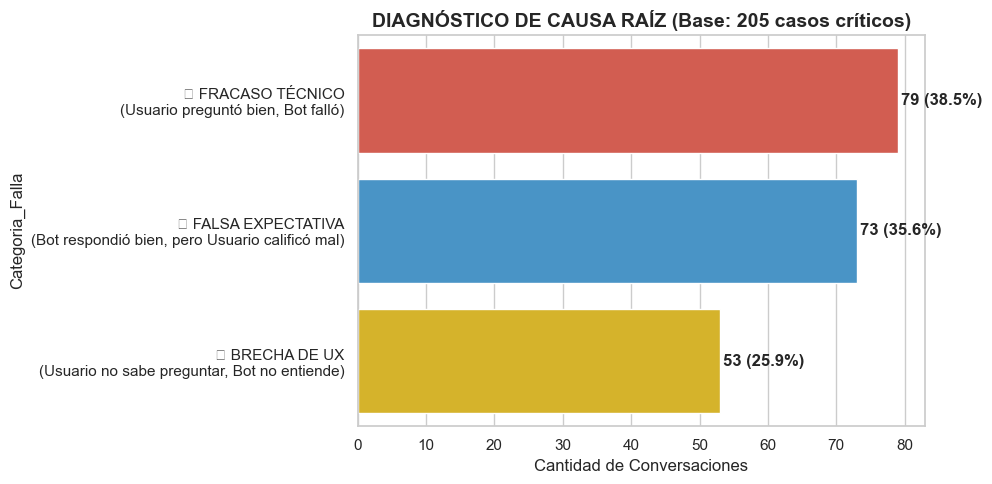

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1793466437.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tasa_exito.index, y=tasa_exito.values, palette='Blues')



💡 INSIGHT PRINCIPAL:
🚨 PRIORIDAD ALTA: EL BOT NECESITA ENTRENAMIENTO.
   La mayoría de usuarios preguntan bien, pero el bot no tiene la respuesta o la lógica correcta.
   Acción: Revisar base de conocimiento y flujos de los temas top.

TOP RAZONES DE FALLA TÉCNICA (Cuando la pregunta fue válida)
Analizando 79 fallos técnicos puros. Patrones detectados:
CONCEPTO             | FRECUENCIA
-----------------------------------
pregunta             | 58        
conecta              | 58        
entrega              | 48        
dato                 | 40        
sino                 | 35        
reformular           | 29        
directamente         | 28        
exacto               | 27        
solicitado           | 26        
información          | 25        

📖 GLOSARIO DE ERRORES COMUNES:
- 'genérica': El bot dio una definición en lugar de un dato.
- 'enlace/link': El bot mandó a la web en lugar de responder ahí.
- 'contexto': El bot no mantuvo el hilo de la conversación.

SENSIBILIDAD: 

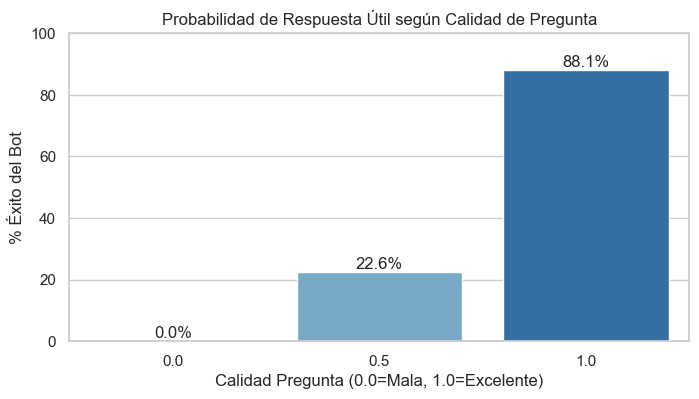

DATO CLAVE: Si logramos que el usuario pregunte bien (1.0) en lugar de mal (0.0),
la efectividad del bot aumenta un +88.1 puntos porcentuales.


In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# ==============================================================================
# DASHBOARD ESTRATÉGICO: DIAGNÓSTICO DE CAUSA RAÍZ
# ==============================================================================

print("="*80)
print("ANALIZANDO RESULTADOS PARA MEJORA CONTINUA")
print("="*80)

if 'df_analisis_completo' in locals():
    
    # 1. PREPARACIÓN DE DATOS
    df = df_analisis_completo.copy()
    
    # Definimos umbral de "Buena Pregunta" (0.5 = Regular, 1.0 = Excelente)
    # Si el score es > 0, el usuario intentó preguntar algo. Si es 0, fue ruido.
    df['Usuario_Claro'] = df['calidad_pregunta_score'] >= 0.5
    
    # Definimos éxito del Bot
    df['Bot_Util'] = df['intencion_respuesta_bool']

    # 2. CREACIÓN DE LA MATRIZ DE DIAGNÓSTICO (SEGMENTACIÓN)
    def diagnosticar(row):
        if row['Usuario_Claro'] and not row['Bot_Util']:
            return "🔴 FRACASO TÉCNICO\n(Usuario preguntó bien, Bot falló)"
        elif not row['Usuario_Claro'] and not row['Bot_Util']:
            return "🟡 BRECHA DE UX\n(Usuario no sabe preguntar, Bot no entiende)"
        elif not row['Usuario_Claro'] and row['Bot_Util']:
            return "🟢 'SUERTE' DEL BOT\n(Pregunta mala, pero Bot acertó)"
        elif row['Usuario_Claro'] and row['Bot_Util']:
            return "🔵 FALSA EXPECTATIVA\n(Bot respondió bien, pero Usuario calificó mal)"
        return "Otro"

    df['Categoria_Falla'] = df.apply(diagnosticar, axis=1)

    # ==============================================================================
    # INSIGHT 1: ¿DE QUIÉN ES LA CULPA? (Gráfico de Barras)
    # ==============================================================================
    conteo = df['Categoria_Falla'].value_counts()
    total_casos = len(df)
    
    plt.figure(figsize=(10, 5))
    # Paleta semafórica: Rojo (Urgent), Amarillo (Warning), Verde (Good), Azul (Info)
    colores = {'🔴': '#e74c3c', '🟡': '#f1c40f', '🟢': '#2ecc71', '🔵': '#3498db'}
    palette = [colores.get(x[0], 'gray') for x in conteo.index]
    
    ax = sns.barplot(x=conteo.values, y=conteo.index, palette=palette)
    
    plt.title(f'DIAGNÓSTICO DE CAUSA RAÍZ (Base: {total_casos} casos críticos)', fontsize=14, fontweight='bold')
    plt.xlabel('Cantidad de Conversaciones')
    
    # Etiquetas
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.5, p.get_y() + p.get_height()/2, 
                 f'{int(width)} ({width/total_casos*100:.1f}%)', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación Automática
    top_causa = conteo.idxmax()
    print(f"\n💡 INSIGHT PRINCIPAL:")
    if "FRACASO TÉCNICO" in top_causa:
        print("🚨 PRIORIDAD ALTA: EL BOT NECESITA ENTRENAMIENTO.")
        print("   La mayoría de usuarios preguntan bien, pero el bot no tiene la respuesta o la lógica correcta.")
        print("   Acción: Revisar base de conocimiento y flujos de los temas top.")
    elif "BRECHA DE UX" in top_causa:
        print("⚠️ PRIORIDAD UX: EL USUARIO ESTÁ PERDIDO.")
        print("   Los usuarios no saben cómo formular sus dudas.")
        print("   Acción: Implementar botones, autocompletado o menú de inicio más claro.")
    elif "FALSA EXPECTATIVA" in top_causa:
        print("ℹ️ GESTIÓN DE EXPECTATIVAS.")
        print("   El bot funciona técnicamente, pero la respuesta no satisface al humano (quizás por tono o política del banco).")

    # ==============================================================================
    # INSIGHT 2: ¿POR QUÉ FALLA EL BOT CUANDO DEBERÍA FUNCIONAR? (Análisis de Texto)
    # ==============================================================================
    print(f"\n{'='*60}")
    print("TOP RAZONES DE FALLA TÉCNICA (Cuando la pregunta fue válida)")
    print(f"{'='*60}")
    
    # Filtramos solo los casos donde el usuario hizo su trabajo bien pero el bot falló
    errores_tecnicos = df[df['Categoria_Falla'].str.contains("FRACASO TÉCNICO")]
    
    if not errores_tecnicos.empty:
        # Unimos los comentarios de la IA sobre la respuesta
        textos = " ".join(errores_tecnicos['intencion_respuesta_comentario'].astype(str)).lower()
        
        # Limpieza básica
        palabras = re.findall(r'\w+', textos)
        stopwords = ['el', 'la', 'que', 'de', 'no', 'en', 'a', 'y', 'es', 'un', 'una', 'pero', 'del', 'se', 'por', 'para', 'con', 'respuesta', 'usuario', 'bot', 'informacion', 'sobre', 'dio']
        palabras_clave = [p for p in palabras if p not in stopwords and len(p) > 3]
        
        top_razones = Counter(palabras_clave).most_common(10)
        
        print(f"Analizando {len(errores_tecnicos)} fallos técnicos puros. Patrones detectados:")
        print(f"{'CONCEPTO':<20} | {'FRECUENCIA':<10}")
        print("-" * 35)
        for word, freq in top_razones:
            print(f"{word:<20} | {freq:<10}")
            
        print("\n📖 GLOSARIO DE ERRORES COMUNES:")
        print("- 'genérica': El bot dio una definición en lugar de un dato.")
        print("- 'enlace/link': El bot mandó a la web en lugar de responder ahí.")
        print("- 'contexto': El bot no mantuvo el hilo de la conversación.")
    else:
        print("✅ No se encontraron fallas técnicas puras significativas.")

    # ==============================================================================
    # INSIGHT 3: EFICIENCIA SEGÚN CALIDAD DE INPUT
    # ==============================================================================
    print(f"\n{'='*60}")
    print("SENSIBILIDAD: ¿QUÉ TANTO MEJORA EL BOT SI EL USUARIO MEJORA?")
    print(f"{'='*60}")
    
    # Tasa de éxito según calidad de pregunta
    tasa_exito = df.groupby('calidad_pregunta_score')['Bot_Util'].mean() * 100
    
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=tasa_exito.index, y=tasa_exito.values, palette='Blues')
    plt.title('Probabilidad de Respuesta Útil según Calidad de Pregunta')
    plt.xlabel('Calidad Pregunta (0.0=Mala, 1.0=Excelente)')
    plt.ylabel('% Éxito del Bot')
    plt.ylim(0, 100)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom')
    plt.show()
    
    diff = tasa_exito.get(1.0, 0) - tasa_exito.get(0.0, 0)
    print(f"DATO CLAVE: Si logramos que el usuario pregunte bien (1.0) en lugar de mal (0.0),")
    print(f"la efectividad del bot aumenta un +{diff:.1f} puntos porcentuales.")

else:
    print("❌ Error: No se encontró 'df_analisis_completo'. Ejecuta la auditoría primero.")

In [350]:
import pandas as pd
import numpy as np

def generar_muestra_realista(df, n_objetivo=385):
    print(f"📊 Generando matriz de análisis (Objetivo: {n_objetivo} por segmento)...")
    
    # 1. Limpieza previa
    # Aseguramos que los nulos sean identificables
    df['Calificacion Usuario'] = df['Calificacion Usuario'].fillna(-1) # -1 será nuestra marca de "Sin Calificación"
    
    # 2. Definición de Universos
    # Retención (Bot puro)
    retencion = df[df['Ofrecio Experto (Flag)'] == 0]
    
    # Atención Humana (Confirmada)
    humanos = df[df['Paso a Experto (Flag)'] == 1]
    
    # 3. Definición de los 5 Segmentos
    grupos = {
        # --- EXTREMOS (Lo que ya tenías) ---
        "1_Bot_Exitoso": retencion[retencion['Calificacion Usuario'] >= 4],
        "2_Bot_Fallido": retencion[(retencion['Calificacion Usuario'] >= 1) & (retencion['Calificacion Usuario'] <= 3)],
        
        "3_Humano_Exitoso": humanos[humanos['Calificacion Usuario'] >= 4],
        "4_Humano_Fallido": humanos[(humanos['Calificacion Usuario'] >= 1) & (humanos['Calificacion Usuario'] <= 3)],
        
        # --- LA MAYORÍA SILENCIOSA (Nuevo) ---
        "5_Bot_Silencioso": retencion[retencion['Calificacion Usuario'] == -1]
    }
    
    muestras_finales = []
    
    print("\n📋 REPORTE DE DISPONIBILIDAD DE DATOS:")
    print(f"{'SEGMENTO':<20} | {'TOTAL REAL':<10} | {'ACCIÓN':<15}")
    print("-" * 50)
    
    for nombre, dframe in grupos.items():
        total = len(dframe)
        
        # Si hay menos datos que el objetivo, tomamos todo lo que haya
        tomar = min(n_objetivo, total)
        accion = "Muestreo" if total > n_objetivo else "Tomar Todo"
        
        print(f"{nombre:<20} | {total:<10} | {accion:<15} -> {tomar} registros")
        
        if total > 0:
            muestra = dframe.sample(n=tomar, random_state=42).copy()
            muestra['Segmento_Analisis'] = nombre
            muestras_finales.append(muestra)

    # Unir todo
    if muestras_finales:
        df_final = pd.concat(muestras_finales)
        print("-" * 50)
        print(f"✅ Muestra total a auditar: {len(df_final)} conversaciones")
        return df_final
    else:
        print("❌ No se encontraron datos para segmentar.")
        return pd.DataFrame()

# --- EJECUCIÓN ---
if 'df_final_export' in locals():
    df_para_auditar = generar_muestra_realista(df_final_export, n_objetivo=385)
    
    # Validar si tenemos suficientes datos
    if not df_para_auditar.empty:
        print("\nResumen final de la muestra:")
        print(df_para_auditar['Segmento_Analisis'].value_counts())
else:
    print("❌ Carga df_final_export primero")

📊 Generando matriz de análisis (Objetivo: 385 por segmento)...

📋 REPORTE DE DISPONIBILIDAD DE DATOS:
SEGMENTO             | TOTAL REAL | ACCIÓN         
--------------------------------------------------
1_Bot_Exitoso        | 683        | Muestreo        -> 385 registros
2_Bot_Fallido        | 422        | Muestreo        -> 385 registros
3_Humano_Exitoso     | 418        | Muestreo        -> 385 registros
4_Humano_Fallido     | 588        | Muestreo        -> 385 registros
5_Bot_Silencioso     | 16136      | Muestreo        -> 385 registros
--------------------------------------------------
✅ Muestra total a auditar: 1925 conversaciones

Resumen final de la muestra:
Segmento_Analisis
1_Bot_Exitoso       385
2_Bot_Fallido       385
3_Humano_Exitoso    385
4_Humano_Fallido    385
5_Bot_Silencioso    385
Name: count, dtype: int64


* Bot Exitoso (Retuvo + Calif 4-5)
* Bot Fallido (Retuvo + Calif 1-3)
* Bot Silencioso (Retuvo + Sin Calif) 
* Humano Exitoso (Pasó + Calif 4-5)
* Humano Fallido (Pasó + Calif 1-3)

In [379]:
df_para_auditar[df_para_auditar.Segmento_Analisis == '1_Bot_Exitoso'].to_csv('muestra_bot_exitoso.csv', index=False)

In [377]:
# ...existing code...
df_para_auditar[df_para_auditar.Segmento_Analisis == '1_Bot_Exitoso'].Correo.unique()

# Obtener los correos únicos
correos_bot_exitoso = df_para_auditar[df_para_auditar.Segmento_Analisis == '1_Bot_Exitoso'].Correo.unique()

# Convertir a DataFrame para una fácil exportación
df_correos_exportar = pd.DataFrame(correos_bot_exitoso, columns=['Correo'])

# Definir el nombre del archivo de salida
nombre_archivo_salida = 'correos_bot_exitoso.csv'

# Exportar a CSV
df_correos_exportar.to_csv(nombre_archivo_salida, index=False)

print(f"Se han exportado {len(df_correos_exportar)} correos únicos a '{nombre_archivo_salida}'.")

Se han exportado 232 correos únicos a 'correos_bot_exitoso.csv'.


In [344]:
df_analisis_completo.to_csv("analisis_completo_auditoria_ia.csv", index=False)

In [352]:
# ==============================================================================
# 3. PROCESAMIENTO ROBUSTO DE LA MUESTRA
# ==============================================================================

NOMBRE_ARCHIVO_SALIDA = "auditoria_final_completa.csv"

if 'df_para_auditar' in locals() and not df_para_auditar.empty:
    
    print("\n" + "="*80)
    print(f"🚀 INICIANDO AUDITORÍA DE {len(df_para_auditar)} CONVERSACIONES")
    print(f"   Segmentos incluidos: {df_para_auditar['Segmento_Analisis'].unique()}")
    print("="*80)

    # 1. Lógica de Reanudación (Resume)
    # Si el script se cae, leemos lo que ya se guardó para no repetir (y no gastar dinero)
    ids_procesados = []
    if os.path.exists(NOMBRE_ARCHIVO_SALIDA):
        try:
            df_existente = pd.read_csv(NOMBRE_ARCHIVO_SALIDA)
            if 'ID Conversacion' in df_existente.columns:
                ids_procesados = df_existente['ID Conversacion'].astype(str).tolist()
            print(f"📂 Se encontró un archivo parcial con {len(ids_procesados)} registros procesados. Continuando...")
        except:
            print("⚠️ Archivo de salida corrupto o vacío, iniciando desde cero.")

    resultados_buffer = []
    contador = 0
    total = len(df_para_auditar)

    # 2. Bucle Principal
    for idx, row in df_para_auditar.iterrows():
        id_conv = str(row['ID Conversacion'])
        
        # Saltar si ya está hecho
        if id_conv in ids_procesados:
            continue
            
        contador += 1
        if contador % 10 == 0: 
            print(f"   ⏳ Procesando... ({len(ids_procesados) + contador}/{total})")

        # Llamada a la IA
        analisis = auditar_conversacion(str(row['Conversacion']))
        
        # Agregar metadatos clave para el análisis posterior
        analisis['ID Conversacion'] = id_conv
        analisis['Segmento_Analisis'] = row['Segmento_Analisis'] # ¡Vital para comparar grupos!
        
        resultados_buffer.append(analisis)
        
        # 3. Guardado Incremental (Cada 20 registros)
        if len(resultados_buffer) >= 20:
            df_temp = pd.DataFrame(resultados_buffer)
            # Si el archivo no existe, escribe header. Si existe, no.
            escribir_header = not os.path.exists(NOMBRE_ARCHIVO_SALIDA)
            df_temp.to_csv(NOMBRE_ARCHIVO_SALIDA, mode='a', header=escribir_header, index=False)
            
            # Limpiar buffer y actualizar lista de procesados para no repetir en memoria
            ids_procesados.extend([r['ID Conversacion'] for r in resultados_buffer])
            resultados_buffer = []
            print("   💾 Progreso guardado en CSV.")
            
        # Pausa anti-bloqueo (Rate Limit)
        time.sleep(0.3)

    # 4. Guardar remanentes al final
    if resultados_buffer:
        df_temp = pd.DataFrame(resultados_buffer)
        escribir_header = not os.path.exists(NOMBRE_ARCHIVO_SALIDA)
        df_temp.to_csv(NOMBRE_ARCHIVO_SALIDA, mode='a', header=escribir_header, index=False)
        print("   💾 Guardado final completado.")

    print("\n✅ AUDITORÍA FINALIZADA.")
    
    # ==============================================================================
    # 4. CARGA Y CRUCE FINAL
    # ==============================================================================
    print("\n🔄 Generando DataFrame consolidado...")
    
    # Leemos el archivo CSV completo generado
    df_auditoria_raw = pd.read_csv(NOMBRE_ARCHIVO_SALIDA)
    
    # Hacemos merge con df_para_auditar para recuperar columnas originales (Región, Fecha, etc.)
    # Convertimos ID a string en ambos para evitar problemas de tipo
    df_para_auditar['ID Conversacion'] = df_para_auditar['ID Conversacion'].astype(str)
    df_auditoria_raw['ID Conversacion'] = df_auditoria_raw['ID Conversacion'].astype(str)
    
    df_auditoria_final = pd.merge(df_para_auditar, df_auditoria_raw, on=['ID Conversacion', 'Segmento_Analisis'], how='inner')
    
    print(f"📊 DataFrame 'df_auditoria_final' listo con {len(df_auditoria_final)} registros y métricas de IA.")
    print("   Usa este DataFrame para tus gráficos comparativos.")

else:
    print("❌ Error: No se encontró 'df_para_auditar'. Ejecuta el código de muestreo primero.")


🚀 INICIANDO AUDITORÍA DE 1925 CONVERSACIONES
   Segmentos incluidos: ['1_Bot_Exitoso' '2_Bot_Fallido' '3_Humano_Exitoso' '4_Humano_Fallido'
 '5_Bot_Silencioso']
📂 Se encontró un archivo parcial con 220 registros procesados. Continuando...
   ⏳ Procesando... (230/1925)
   ⏳ Procesando... (240/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (270/1925)
   ⏳ Procesando... (280/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (310/1925)
   ⏳ Procesando... (320/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (350/1925)
   ⏳ Procesando... (360/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (390/1925)
   ⏳ Procesando... (400/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (430/1925)
   ⏳ Procesando... (440/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (470/1925)
   ⏳ Procesando... (480/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (510/1925)
   ⏳ Procesando... (520/1925)
   💾 Progreso guardado en CSV.
   ⏳ Procesando... (550/1925)
  

KeyboardInterrupt: 

In [354]:

# ==============================================================================
# COMPLETAR AUDITORÍA (Filtro de Faltantes)
# ==============================================================================

NOMBRE_ARCHIVO = "auditoria_final_completa.csv"

# 1. Cargar lo que ya tenemos seguro
if os.path.exists(NOMBRE_ARCHIVO):
    df_hecho = pd.read_csv(NOMBRE_ARCHIVO)
    ids_hechos = df_hecho['ID Conversacion'].astype(str).unique().tolist()
    print(f"✅ Tenemos {len(ids_hechos)} conversaciones únicas ya auditadas.")
else:
    ids_hechos = []

# 2. Identificar lo que falta del plan original
# Aseguramos que df_para_auditar tenga los IDs como string
df_para_auditar['ID Conversacion'] = df_para_auditar['ID Conversacion'].astype(str)

# FILTRO CRUCIAL: Dejamos solo lo que NO está en el CSV
df_faltante = df_para_auditar[~df_para_auditar['ID Conversacion'].isin(ids_hechos)].copy()

print(f"🚨 FALTAN POR PROCESAR: {len(df_faltante)} conversaciones.")
print(f"   Segmentos pendientes: {df_faltante['Segmento_Analisis'].unique()}")

# 3. Ejecutar auditoría SOLO si hay faltantes
if len(df_faltante) > 0:
    print("\n🚀 Iniciando procesamiento de faltantes...")
    
    # --- CONFIGURACIÓN VERTEX (Tu bloque estándar) ---
    SERVICE_ACCOUNT_FILE = 'comusoporte-desarrollo-319e345bb885.json'
    PROJECT_ID = 'tu-project-id'
    LOCATION = 'us-central1'
    MODEL_ID = 'gemini-2.0-flash-001'
    
    try:
        credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
        with open(SERVICE_ACCOUNT_FILE, 'r') as f:
             pid = json.load(f).get('project_id')
        vertexai.init(project=pid, location=LOCATION, credentials=credentials)
        model = GenerativeModel(MODEL_ID)
    except:
        print("⚠️ Error config. Asumiendo modelo ya cargado en memoria.")

    # --- FUNCIÓN AUDITOR (La misma) ---
    def auditar_conversacion(texto, retry=0):
        prompt = f"""
        Actúa como Auditor Bancario. Evalúa transcripción: '''{texto}'''
        JSON único:
        {{ "calidad_pregunta_score": <float>, "calidad_pregunta_razon": "<str>", 
           "intencion_usuario_bool": <bool>, "intencion_usuario_comentario": "<str>",
           "intencion_respuesta_bool": <bool>, "intencion_respuesta_comentario": "<str>" }}
        """
        try:
            res = model.generate_content(prompt, generation_config={"response_mime_type": "application/json"})
            return json.loads(res.text)[0] if isinstance(json.loads(res.text), list) else json.loads(res.text)
        except Exception as e:
            if retry < 3: time.sleep(1); return auditar_conversacion(texto, retry+1)
            return {"calidad_pregunta_score": 0.0}

    # --- BUCLE DE COMPLETADO ---
    buffer = []
    for idx, row in df_faltante.iterrows():
        try:
            res = auditar_conversacion(str(row['Conversacion']))
            res['ID Conversacion'] = row['ID Conversacion']
            res['Segmento_Analisis'] = row['Segmento_Analisis']
            buffer.append(res)
            
            print(f"   Procesando faltante {len(buffer)}/{len(df_faltante)}")
            
            if len(buffer) % 10 == 0:
                pd.DataFrame(buffer).to_csv(NOMBRE_ARCHIVO, mode='a', header=False, index=False)
                buffer = []
                
            time.sleep(0.2)
        except:
            continue

    if buffer:
        pd.DataFrame(buffer).to_csv(NOMBRE_ARCHIVO, mode='a', header=False, index=False)
    
    print("\n✅ ¡AHORA SÍ! Auditoría completa.")
else:
    print("🎉 ¡Felicidades! Ya tienes el 100% de la muestra procesada.")

✅ Tenemos 1320 conversaciones únicas ya auditadas.
🚨 FALTAN POR PROCESAR: 605 conversaciones.
   Segmentos pendientes: ['4_Humano_Fallido' '5_Bot_Silencioso']

🚀 Iniciando procesamiento de faltantes...


c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


   Procesando faltante 1/605
   Procesando faltante 2/605
   Procesando faltante 3/605
   Procesando faltante 4/605
   Procesando faltante 5/605
   Procesando faltante 6/605
   Procesando faltante 7/605
   Procesando faltante 8/605
   Procesando faltante 9/605
   Procesando faltante 10/605
   Procesando faltante 1/605
   Procesando faltante 2/605
   Procesando faltante 3/605
   Procesando faltante 4/605
   Procesando faltante 5/605
   Procesando faltante 6/605
   Procesando faltante 7/605
   Procesando faltante 8/605
   Procesando faltante 9/605
   Procesando faltante 10/605
   Procesando faltante 1/605
   Procesando faltante 2/605
   Procesando faltante 3/605
   Procesando faltante 4/605
   Procesando faltante 5/605
   Procesando faltante 6/605
   Procesando faltante 7/605
   Procesando faltante 8/605
   Procesando faltante 9/605
   Procesando faltante 10/605
   Procesando faltante 1/605
   Procesando faltante 2/605
   Procesando faltante 3/605
   Procesando faltante 4/605
   Procesan

In [355]:
print("="*80)
print("CARGANDO RESULTADOS PARCIALES DE LA AUDITORÍA")
print("="*80)

NOMBRE_ARCHIVO = "auditoria_final_completa.csv"

try:
    # 1. Cargar resultados de la IA
    df_ia = pd.read_csv(NOMBRE_ARCHIVO)
    
    # Limpieza de duplicados (Vital por si el script escribió varias veces)
    df_ia = df_ia.drop_duplicates(subset=['ID Conversacion'])
    
    # 2. Preparar DF Original para el cruce
    # Necesitamos recuperar la Calificación, Regional y Flag de Experto
    cols_necesarias = ['ID Conversacion', 'Calificacion Usuario', 'Regional', 'Ofrecio Experto (Flag)']
    df_base = df_final_export[cols_necesarias].copy()
    
    # Asegurar tipos de datos iguales para el cruce
    df_ia['ID Conversacion'] = df_ia['ID Conversacion'].astype(str)
    df_base['ID Conversacion'] = df_base['ID Conversacion'].astype(str)
    
    # 3. Merge (Unir)
    df_resultados = pd.merge(df_ia, df_base, on='ID Conversacion', how='inner')
    
    print(f"✅ Datos recuperados exitosamente.")
    print(f"📊 Total conversaciones analizadas: {len(df_resultados)}")
    print("\nDistribución por Segmento analizado:")
    print(df_resultados['Segmento_Analisis'].value_counts())

except FileNotFoundError:
    print("❌ No se encontró el archivo CSV. Verifica que se haya creado.")
except Exception as e:
    print(f"❌ Error cargando datos: {e}")

CARGANDO RESULTADOS PARCIALES DE LA AUDITORÍA
✅ Datos recuperados exitosamente.
📊 Total conversaciones analizadas: 1924

Distribución por Segmento analizado:
Segmento_Analisis
1_Bot_Exitoso       385
2_Bot_Fallido       385
3_Humano_Exitoso    385
5_Bot_Silencioso    385
4_Humano_Fallido    384
Name: count, dtype: int64


TABLERO DE MANDO: DIAGNÓSTICO INTEGRAL

1. TABLA DE RENDIMIENTO POR SEGMENTO:


,Segmento_Analisis,Calidad Usuario (%),Efectividad Respuesta (%)
4,5_Bot_Silencioso,84.0,83.6
0,1_Bot_Exitoso,69.7,76.6
3,4_Humano_Fallido,71.5,58.6
2,3_Humano_Exitoso,56.4,46.8
1,2_Bot_Fallido,53.2,33.8


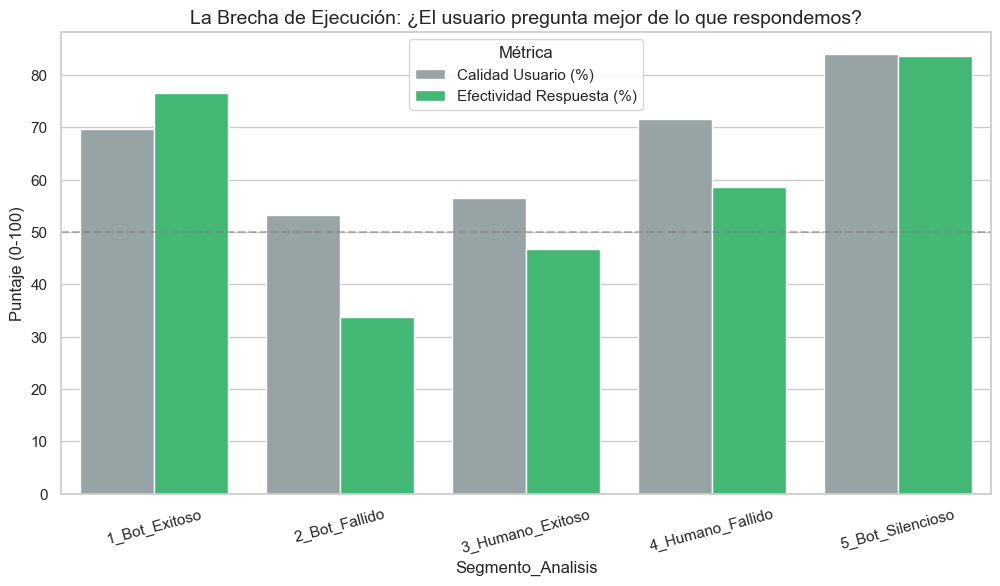

💡 INSIGHT 1:
- Si la barra GRIS es alta y la VERDE baja en 'Bot_Fallido': Es DEUDA TÉCNICA (El bot falla).
- Si ambas son bajas: Es DEUDA DE UX (El usuario no entiende el producto).

2. AUTOPSIA: ¿POR QUÉ FALLA EL BOT CUANDO EL USUARIO SE QUEJA?


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\952997542.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo.values, y=conteo.index, palette=['#e74c3c', '#f1c40f', '#3498db'])
C:\Users\gabrieva\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\gabrieva\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\gabrieva\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


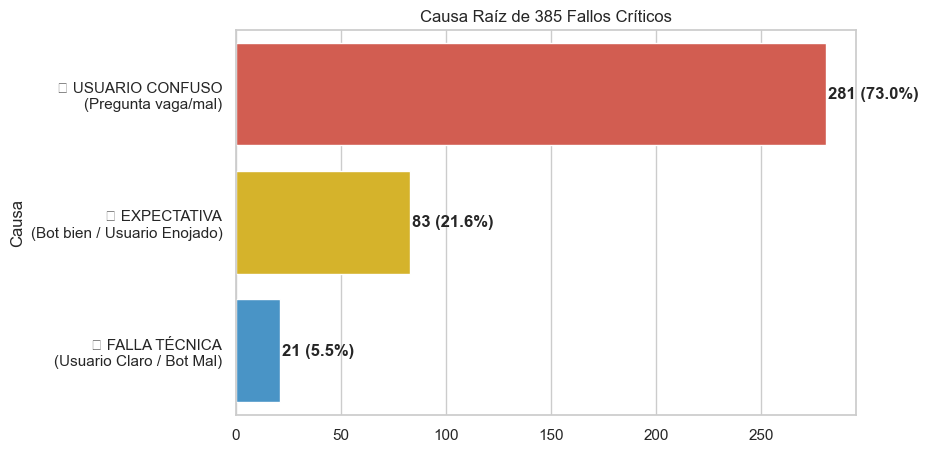


3. DETECTIVE REGIONAL: ¿QUÉ PASA EN EL CARIBE?


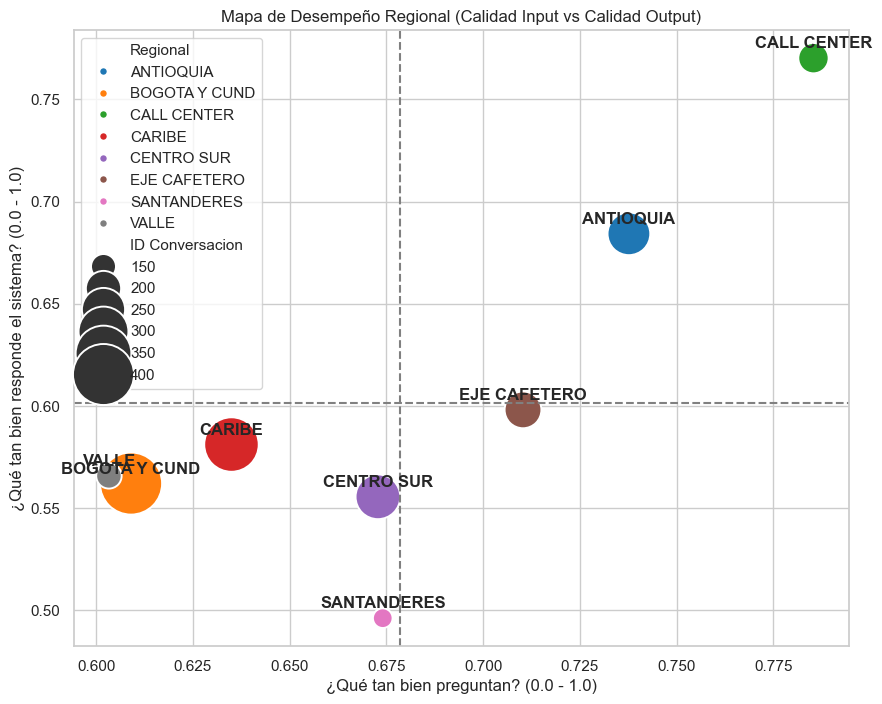

🔎 LECTURA PARA CARIBE:
-> Si Caribe está a la IZQUIERDA del promedio: Problema Cultural (Formulación).
-> Si Caribe está ABAJO del promedio: Problema Técnico (Infraestructura/Temas Locales).
-> Si Caribe está ARRIBA A LA DERECHA pero tiene baja autogestión: PREFERENCIA PURA.


In [360]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración estética
sns.set_theme(style="whitegrid")

if 'df_resultados' in locals():
    
    print("="*80)
    print("TABLERO DE MANDO: DIAGNÓSTICO INTEGRAL")
    print("="*80)

    # ==========================================================================
    # 1. VISIÓN MACRO: COMPARATIVA DE RENDIMIENTO
    # ==========================================================================
    # Agrupamos por Segmento para ver quién gana y quién pierde
    kpis = df_resultados.groupby('Segmento_Analisis').agg({
        'calidad_pregunta_score': 'mean',   # ¿El usuario lo hizo bien?
        'intencion_respuesta_bool': 'mean', # ¿El bot/humano lo hizo bien?
        'ID Conversacion': 'count'          # Volumen
    }).reset_index()
    
    # Convertimos a porcentaje para facilitar lectura
    kpis['Calidad Usuario (%)'] = (kpis['calidad_pregunta_score'] * 100).round(1)
    kpis['Efectividad Respuesta (%)'] = (kpis['intencion_respuesta_bool'] * 100).round(1)
    
    print("\n1. TABLA DE RENDIMIENTO POR SEGMENTO:")
    display(kpis[['Segmento_Analisis', 'Calidad Usuario (%)', 'Efectividad Respuesta (%)']].sort_values('Efectividad Respuesta (%)', ascending=False))

    # Gráfico de Brechas
    df_melt = kpis.melt(id_vars='Segmento_Analisis', value_vars=['Calidad Usuario (%)', 'Efectividad Respuesta (%)'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Segmento_Analisis', y='value', hue='variable', palette=['#95a5a6', '#2ecc71'])
    plt.title("La Brecha de Ejecución: ¿El usuario pregunta mejor de lo que respondemos?", fontsize=14)
    plt.ylabel("Puntaje (0-100)")
    plt.axhline(50, color='gray', linestyle='--', alpha=0.5)
    plt.xticks(rotation=15)
    plt.legend(title="Métrica")
    plt.show()
    
    print("💡 INSIGHT 1:")
    print("- Si la barra GRIS es alta y la VERDE baja en 'Bot_Fallido': Es DEUDA TÉCNICA (El bot falla).")
    print("- Si ambas son bajas: Es DEUDA DE UX (El usuario no entiende el producto).")

    # ==========================================================================
    # 2. DIAGNÓSTICO DE CAUSA RAÍZ (Solo Bot Fallido)
    # ==========================================================================
    print(f"\n{'='*60}")
    print("2. AUTOPSIA: ¿POR QUÉ FALLA EL BOT CUANDO EL USUARIO SE QUEJA?")
    print(f"{'='*60}")
    
    # Filtramos el segmento doloroso
    df_fail = df_resultados[df_resultados['Segmento_Analisis'].str.contains('Bot_Fallido')].copy()
    
    if not df_fail.empty:
        def clasificar_culpa(row):
            if row['calidad_pregunta_score'] >= 0.6 and not row['intencion_respuesta_bool']:
                return "🔴 FALLA TÉCNICA\n(Usuario Claro / Bot Mal)"
            elif row['calidad_pregunta_score'] < 0.6:
                return "🟡 USUARIO CONFUSO\n(Pregunta vaga/mal)"
            else:
                return "🔵 EXPECTATIVA\n(Bot bien / Usuario Enojado)"
        
        df_fail['Causa'] = df_fail.apply(clasificar_culpa, axis=1)
        conteo = df_fail['Causa'].value_counts()
        
        plt.figure(figsize=(8, 5))
        sns.barplot(x=conteo.values, y=conteo.index, palette=['#e74c3c', '#f1c40f', '#3498db'])
        plt.title(f"Causa Raíz de {len(df_fail)} Fallos Críticos")
        
        # Etiquetas
        for i, v in enumerate(conteo.values):
            plt.text(v + 1, i, f"{v} ({v/len(df_fail)*100:.1f}%)", va='center', fontweight='bold')
            
        plt.show()
    else:
        print("No hay suficientes datos de Bot_Fallido.")

    # ==========================================================================
    # 3. ZOOM REGIONAL: CARIBE VS EL RESTO
    # ==========================================================================
    print(f"\n{'='*60}")
    print("3. DETECTIVE REGIONAL: ¿QUÉ PASA EN EL CARIBE?")
    print(f"{'='*60}")
    
    # Agrupamos por Regional
    regional_metrics = df_resultados.groupby('Regional').agg({
        'calidad_pregunta_score': 'mean',
        'intencion_respuesta_bool': 'mean',
        'ID Conversacion': 'count'
    }).reset_index()
    
    # Filtramos regionales con poca muestra para limpiar el gráfico
    regional_metrics = regional_metrics[regional_metrics['ID Conversacion'] > 20]
    
    plt.figure(figsize=(10, 8))
    
    # Scatter Plot
    sns.scatterplot(data=regional_metrics, x='calidad_pregunta_score', y='intencion_respuesta_bool', 
                    size='ID Conversacion', sizes=(200, 2000), hue='Regional', palette='tab10')
    
    # Etiquetas
    for i, row in regional_metrics.iterrows():
        plt.text(row['calidad_pregunta_score'], row['intencion_respuesta_bool']+0.005, 
                 row['Regional'], ha='center', fontweight='bold')
        
    # Líneas promedio
    plt.axvline(regional_metrics['calidad_pregunta_score'].mean(), color='gray', linestyle='--')
    plt.axhline(regional_metrics['intencion_respuesta_bool'].mean(), color='gray', linestyle='--')
    
    plt.title("Mapa de Desempeño Regional (Calidad Input vs Calidad Output)")
    plt.xlabel("¿Qué tan bien preguntan? (0.0 - 1.0)")
    plt.ylabel("¿Qué tan bien responde el sistema? (0.0 - 1.0)")
    plt.show()
    
    print("🔎 LECTURA PARA CARIBE:")
    print("-> Si Caribe está a la IZQUIERDA del promedio: Problema Cultural (Formulación).")
    print("-> Si Caribe está ABAJO del promedio: Problema Técnico (Infraestructura/Temas Locales).")
    print("-> Si Caribe está ARRIBA A LA DERECHA pero tiene baja autogestión: PREFERENCIA PURA.")

else:
    print("❌ Error: No se encuentra 'df_resultados'. Carga los datos primero.")

In [368]:

# Ajuste para poder leer todo el texto del chat
pd.set_option('display.max_colwidth', None)

print("BUSCANDO LAS 21 'FALLAS TÉCNICAS' EN DATOS REALES...")
print("="*80)

# 1. FILTRO DIRECTO (Usando tus columnas reales)
df_falla_tecnica = df_analisis_completo[
    (df_analisis_completo['Paso a Experto (Flag)'] == 0) &      # Bot retuvo (no pasó a humano)
    (df_analisis_completo['Calificacion Usuario'] >= 1) &       # Calificación válida
    (df_analisis_completo['Calificacion Usuario'] <= 3) &       # Calificación mala
    (df_analisis_completo['calidad_pregunta_score'] >= 0.6) &   # Usuario preguntó bien
    (df_analisis_completo['intencion_respuesta_bool'] == False) # Bot no sirvió
].copy()

print(f"🔍 TOTAL CASOS ENCONTRADOS: {len(df_falla_tecnica)}")

# 2. IMPRIMIR LA EVIDENCIA
if not df_falla_tecnica.empty:
    print("Estos son los chats donde el usuario preguntó claro, el bot no entendió, y el usuario calificó mal.")
    print("="*80)
    
    for index, row in df_falla_tecnica.iterrows():
        print(f"\n🔴 ID CASO: {row['ID Conversacion']} | 📍 Regional: {row['Regional']}")
        print(f"⭐ Calif: {row['Calificacion Usuario']} | 🧠 Score Usuario: {row['calidad_pregunta_score']:.2f}")
        
        print(f"🧐 DIAGNÓSTICO PREGUNTA (IA):")
        print(f"   -> {row['calidad_pregunta_razon']}")
        
        print(f"🤖 DIAGNÓSTICO ERROR (IA):")
        print(f"   -> {row['intencion_respuesta_comentario']}")
        
        print(f"📝 CHAT REAL (Extracto):")
        print("-" * 20)
        # Imprimimos hasta 800 caracteres para asegurar contexto
        print(str(row['Conversacion'])[:800]) 
        print("-" * 20)
        print("👇 ACCIÓN RECOMENDADA: Copiar la frase del usuario y agregarla al Intent.")
        print("."*80)

else:
    print("⚠️ Curioso. No salieron registros con este filtro estricto.")
    print("Prueba bajando un poco el score de calidad (ej. 0.5) o revisando si los flags de experto son correctos.")

BUSCANDO LAS 21 'FALLAS TÉCNICAS' EN DATOS REALES...
🔍 TOTAL CASOS ENCONTRADOS: 7
Estos son los chats donde el usuario preguntó claro, el bot no entendió, y el usuario calificó mal.

🔴 ID CASO: 17986 | 📍 Regional: EJE CAFETERO
⭐ Calif: 1.0 | 🧠 Score Usuario: 1.00
🧐 DIAGNÓSTICO PREGUNTA (IA):
   -> La pregunta es clara, específica y completa, permitiendo entender fácilmente la necesidad del usuario.
🤖 DIAGNÓSTICO ERROR (IA):
   -> La respuesta no entrega el dato exacto solicitado, sino que explica el concepto de sobrecupo y cómo modificarlo, lo cual no responde directamente a la pregunta de cómo validar el tope transaccional existente.
📝 CHAT REAL (Extracto):
--------------------
👤 USUARIO: como valido si las tarjetas de credito tienen un tope transaccional

🤖 Conecta+ (Calificación: 👎): El tope transaccional en las tarjetas de crédito está relacionado con el concepto de sobrecupo. El sobrecupo es un porcentaje adicional al cupo que tiene el cliente y que el banco puede autorizar para c

In [ ]:
# TASA DE ABANDONO DEL USUARIO: IA CONTRA PREGUNTA Y EL USUARIO NO RESPONDE. 
# ==============================================================================
# Analizar los comentarios. (Hernan indicar donde encontrarlo)

In [ ]:
# --- PREPARACIÓN INICIAL (Tu código original) ---
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
df_resultados.calificacion_pregunta_10_mean = df_resultados.calificacion_pregunta_10_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no
df_resultados['calificacion_combinada'] = df_resultados['calificacion_pregunta_2_mean'].fillna(df_resultados['calificacion_pregunta_10_mean'])


total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)
# 1. PRIMERA CLASIFICACIÓN (Sin cambios)
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    
    calif_validas = aud_sub['calificacion_combinada'].dropna()
    total_calificadas = calif_validas.shape[0]
    
    # <-- REQUERIMIENTO: Añadir Mediana
    if total_calificadas > 0:
        promedio_calif = calif_validas.mean()
        mediana_calif = calif_validas.median()
        stats_string = f"Promedio (Media): {promedio_calif:.2f} | Mediana: {mediana_calif:.2f}"
    else:
        stats_string = "Sin calificaciones"

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | {stats_string}"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)]
    
    calif_validas = pd.to_numeric(aud_sub['calificacion_combinada'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]

    # <-- REQUERIMIENTO: Añadir Mediana
    if total_calificadas > 0:
        promedio_calif = calif_validas.mean()
        mediana_calif = calif_validas.median()
        stats_string = f"Promedio (Media): {promedio_calif:.2f} | Mediana: {mediana_calif:.2f}"
    else:
        stats_string = "Sin calificaciones"

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | {stats_string}"
    )
    
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")


print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])


ANÁLISIS SEMANAL (Lunes a Domingo)
Resumen de conversaciones por semana:
Semana 13/10 al 19/10/2025: Gestionadas: 4891 | No Gestionadas: 42 | Total: 4933 | Tasa de Gestión: 99.15%
Semana 20/10 al 26/10/2025: Gestionadas: 2921 | No Gestionadas: 769 | Total: 3690 | Tasa de Gestión: 79.16%
Semana 27/10 al 02/11/2025: Gestionadas: 4184 | No Gestionadas: 1158 | Total: 5342 | Tasa de Gestión: 78.32%
Semana 03/11 al 09/11/2025: Gestionadas: 2764 | No Gestionadas: 906 | Total: 3670 | Tasa de Gestión: 75.31%
Semana 10/11 al 16/11/2025: Gestionadas: 3404 | No Gestionadas: 1173 | Total: 4577 | Tasa de Gestión: 74.37%
Semana 17/11 al 23/11/2025: Gestionadas: 1078 | No Gestionadas: 403 | Total: 1481 | Tasa de Gestión: 72.79%

Generando gráficos...


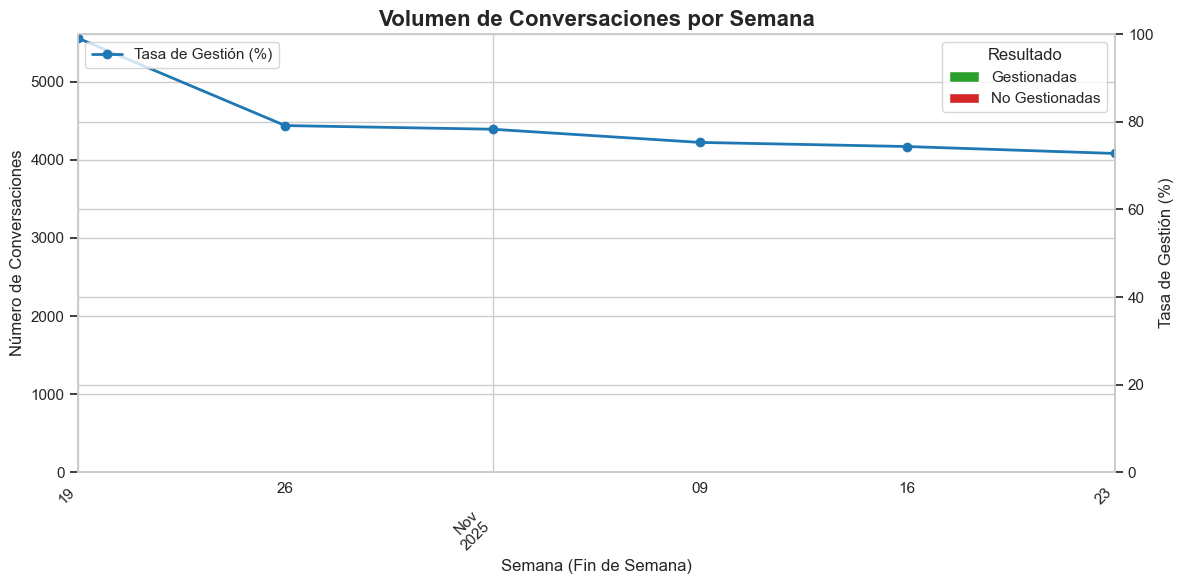

In [ ]:
# ===== REQUERIMIENTO 2: ANÁLISIS SEMANAL (Lunes a Domingo) CON GRÁFICOS =====
print("\n" + "="*60)
print("ANÁLISIS SEMANAL (Lunes a Domingo)")
print("="*60)

# --- SOLUCIÓN AL SettingWithCopyWarning ---
# Este warning suele aparecer si 'df_resultados' fue creado como una porción (slice) de otro DataFrame.
# La mejor solución es asegurarse de que, cuando se creó 'df_resultados', se usó .copy()
# Ejemplo: df_resultados = df_original[df_original['alguna_condicion'] == True].copy()
# Al hacer esto, te aseguras de trabajar sobre una copia independiente y el warning desaparece.

try:
    # Asegúrate de que la columna de fecha esté en formato datetime
    # Usamos .loc para asegurar que estamos modificando el DataFrame original y no una copia.
    df_resultados.loc[:, 'fecha'] = pd.to_datetime(df_resultados['fecha'])

    # Agrupar por semana (que termina en domingo) y por el grupo principal
    analisis_semanal = df_resultados.groupby([
        pd.Grouper(key='fecha', freq='W-SUN'), 
        'grupo_principal'
    ]).agg(
        conversaciones=('conversation_id', 'nunique')
    ).unstack(fill_value=0)

    # Limpiar los nombres de las columnas
    analisis_semanal.columns = analisis_semanal.columns.droplevel(0)
    analisis_semanal.columns.name = None
    analisis_semanal = analisis_semanal.rename(columns={
        'Gestionada Conecta': 'Gestionadas',
        'No Gestionada Conecta': 'No Gestionadas'
    })
    
    # Asegurarse de que ambas columnas existan, si no, crearlas con 0
    if 'Gestionadas' not in analisis_semanal:
        analisis_semanal['Gestionadas'] = 0
    if 'No Gestionadas' not in analisis_semanal:
        analisis_semanal['No Gestionadas'] = 0

    # Calcular totales y porcentajes
    analisis_semanal['Total'] = analisis_semanal['Gestionadas'] + analisis_semanal['No Gestionadas']
    analisis_semanal['% Gestionadas'] = (analisis_semanal['Gestionadas'] / analisis_semanal['Total'] * 100).fillna(0)

    # --- IMPRESIÓN DE RESULTADOS ---
    print("Resumen de conversaciones por semana:")
    for fecha_fin, row in analisis_semanal.iterrows():
        # Calcular la fecha de inicio de la semana (Lunes)
        fecha_ini = fecha_fin - pd.Timedelta(days=6)
        print(
            f"Semana {fecha_ini.strftime('%d/%m')} al {fecha_fin.strftime('%d/%m/%Y')}: "
            f"Gestionadas: {int(row['Gestionadas'])} | "
            f"No Gestionadas: {int(row['No Gestionadas'])} | "
            f"Total: {int(row['Total'])} | "
            f"Tasa de Gestión: {row['% Gestionadas']:.2f}%"
        )
        
    # --- GENERACIÓN DE GRÁFICOS ---
    if not analisis_semanal.empty:
        print("\nGenerando gráficos...")
        
        # Configurar estilo de los gráficos
        sns.set_theme(style="whitegrid")
        
        # Formatear las fechas del índice para que se vean bien en el eje X
        xticklabels = [f"{idx.strftime('%d/%m')}" for idx in analisis_semanal.index]

        # 1. GRÁFICO DE BARRAS APILADAS: Volumen de conversaciones
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        analisis_semanal[['Gestionadas', 'No Gestionadas']].plot(
            kind='bar', 
            stacked=True, 
            ax=ax1,
            color=['#2ca02c', '#d62728'] # Verde para gestionadas, Rojo para no gestionadas
        )
        
        ax1.set_title('Volumen de Conversaciones por Semana', fontsize=16, weight='bold')
        ax1.set_ylabel('Número de Conversaciones')
        ax1.set_xlabel('Semana (Fin de Semana)')
        ax1.set_xticklabels(xticklabels, rotation=45, ha='right')
        ax1.legend(title='Resultado')

        # 2. GRÁFICO DE LÍNEA: Tasa de Gestión (%)
        ax2 = ax1.twinx() # Crear un segundo eje Y que comparte el eje X
        
        analisis_semanal['% Gestionadas'].plot(
            kind='line',
            ax=ax2,
            color='#1f77b4', # Azul
            marker='o',
            linewidth=2,
            label='Tasa de Gestión (%)'
        )
        
        ax2.set_ylabel('Tasa de Gestión (%)')
        ax2.set_ylim(0, 100) # El eje Y del porcentaje siempre va de 0 a 100
        ax2.legend(loc='upper left')

        plt.tight_layout() # Ajusta el layout para que no se solapen los elementos
        plt.show()

except KeyError:
    print("❌ ERROR: La columna 'fecha' no se encontró en 'df_resultados'.")
    print("   Por favor, asegúrate de que el nombre de la columna de fecha sea correcto.")
except Exception as e:
    print(f"❌ Ocurrió un error durante el análisis semanal: {e}")

In [ ]:
RUTA_CONECTA1 = "Resumen de Chat Comunidad_Conecta 2.0 - Historico consultas 1.0 (6).csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')
consultas_conecta_1_sin_dups = consultas_conecta_1.drop_duplicates(subset='idtbl_busqueda_usuario')

In [ ]:
consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_7992\3941628246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)


In [ ]:
import pandas as pd

# --- Prepara los DataFrames ---
# Asegura que las fechas sean datetime y los correos estén normalizados
df_resultados_copia['fecha'] = pd.to_datetime(df_resultados_copia['fecha'])
df_resultados_copia['correo'] = df_resultados_copia['correo'].str.strip().str.lower()
consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()

# --- Define semanas y regionales habilitadas ---
semanas = {
    36: ['ANTIOQUIA'],
    37: ['ANTIOQUIA'],
    38: ['ANTIOQUIA'],
    39: ['ANTIOQUIA'],
    40: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    41: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    42: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE'],
    43: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE', 'SANTANDERES'],
    44: None  # Todas las regionales habilitadas
}

# --- Agrega columna de semana ISO ---
df_resultados_copia['semana'] = df_resultados_copia['fecha'].dt.isocalendar().week
consultas_conecta_1_sin_dups['semana'] = consultas_conecta_1_sin_dups['Fecha'].dt.isocalendar().week

# --- Función para filtrar por regionales habilitadas ---
def filtra_regionales(df, semana, regional_col='REGIONAL'):
    if semanas[semana] is None:
        return df
    return df[df[regional_col].isin(semanas[semana])]

# --- Resultado final ---
resumen = []

for semana in range(36, 44 + 1):
    # Filtra por semana y regional
    df2_sem = df_resultados_copia[df_resultados_copia['semana'] == semana]
    df1_sem = consultas_conecta_1_sin_dups[consultas_conecta_1_sin_dups['semana'] == semana]
    df2_sem = filtra_regionales(df2_sem, semana, 'REGIONAL')
    df1_sem = filtra_regionales(df1_sem, semana, 'REGIONAL') if 'REGIONAL' in df1_sem.columns else df1_sem

    correos_2 = set(df2_sem['correo'].dropna())
    correos_1 = set(df1_sem['correo'].dropna())

    ambos = correos_1 & correos_2
    solo_1 = correos_1 - ambos
    solo_2 = correos_2 - ambos

    total = len(ambos) + len(solo_1) + len(solo_2)
    if total == 0:
        pct_ambos = pct_1 = pct_2 = 0
    else:
        pct_ambos = len(ambos) / total * 100
        pct_1 = len(solo_1) / total * 100
        pct_2 = len(solo_2) / total * 100

    resumen.append({
        'semana': semana,
        'Conecta 1': pct_1,
        'Conecta 2': pct_2,
        'Ambos': pct_ambos,
        'total_correos': total,
        'n_Conecta1': len(solo_1),
        'n_Conecta2': len(solo_2),
        'n_Ambos': len(ambos)
    })

df_resumen = pd.DataFrame(resumen)
df_resumen[['semana', 'Conecta 1', 'Conecta 2', 'Ambos', 'total_correos', 'n_Conecta1', 'n_Conecta2', 'n_Ambos']]

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_7992\2837652951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_7992\2837652951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_7992\2837652951.py:25: SettingWithCop

,semana,Conecta 1,Conecta 2,Ambos,total_correos,n_Conecta1,n_Conecta2,n_Ambos
0,36,74.285714,8.669951,17.044335,1015,754,88,173
1,37,82.231405,3.512397,14.256198,968,796,34,138
2,38,71.867008,6.393862,21.739130,391,281,25,85
3,39,88.419913,2.922078,8.658009,924,817,27,80
4,40,50.590219,9.865093,39.544688,1186,600,117,469
5,41,35.123523,34.371643,30.504834,931,327,320,284
6,42,62.685895,10.139703,27.174403,2219,1391,225,603
7,43,75.254866,6.549274,18.195860,3237,2436,212,589
8,44,56.752537,9.914130,33.333333,3843,2181,381,1281


---

# 📊 Análisis Regional: ¿Por qué Caribe tiene baja autogestión?

## Contexto

La regional **Caribe** presenta la tasa más baja de autogestión (mayor cantidad de pasos a experto humano).

## Hipótesis a validar:

1. ❓ **Calidad de preguntas**: ¿Los usuarios formulan preguntas más ambiguas o mal redactadas?
2. ❓ **Temas específicos**: ¿Consultan sobre temas no cubiertos en la base de conocimiento?
3. ❓ **Complejidad**: ¿Las preguntas son más complejas o requieren contexto específico?
4. ❓ **Cobertura**: ¿Hay gaps en la base de conocimiento para temas que Caribe consulta?

## Metodología:

- **Muestra**: 200 preguntas de Caribe (100 con paso a experto + 100 autogestionadas) vs 200 de otras regionales
- **Herramienta**: Gemini API para clasificación temática y análisis de calidad
- **Base de conocimiento**: 2,444 preguntas del knowledge base
- **Métricas**: Cobertura, distribución temática, calidad, complejidad

In [86]:
# ===== 1. CARGAR BASE DE CONOCIMIENTO =====
print("="*80)
print("CARGANDO BASE DE CONOCIMIENTO")
print("="*80)

import zipfile
import json

ZIP_BC = '_tbl_subrespuesta__PRD_baseconocimientosdb_202511201112.zip'

with zipfile.ZipFile(ZIP_BC, 'r') as z:
    with z.open('tbl_preguntas_conecta2_PRD_baseconocimientosdb_202511201113.json') as f:
        data_bc = json.load(f)
        
        # Estructura: {"SELECT * FROM tabla": [{...}]}
        records_bc = list(data_bc.values())[0]
        df_base_conocimiento = pd.DataFrame(records_bc)
        df_base_conocimiento = df_base_conocimiento.replace({None: pd.NA, 'null': pd.NA, 'NULL': pd.NA})

print(f"\n✅ Base de conocimiento cargada:")
print(f"   {len(df_base_conocimiento):,} preguntas disponibles")
print(f"   Campos: {list(df_base_conocimiento.columns[:8])}")

# Ver distribución
print(f"\n📊 Distribución por producto (top 5):")
if 'id_producto' in df_base_conocimiento.columns:
    top_productos = df_base_conocimiento['id_producto'].value_counts().head()
    for prod_id, count in top_productos.items():
        print(f"   Producto {prod_id}: {count:,} preguntas")

# Ver ejemplo de pregunta
print(f"\n📋 Ejemplo de pregunta en base de conocimiento:")
ejemplo_bc = df_base_conocimiento[df_base_conocimiento['titulo'].notna()].iloc[0]
print(f"   Título: {ejemplo_bc['titulo'][:100]}...")
print(f"   Respuesta (primeros 200 chars): {str(ejemplo_bc['respuesta'])[:200]}...")
print(f"   Keywords: {ejemplo_bc.get('keywords_rag', 'N/A')}")

CARGANDO BASE DE CONOCIMIENTO

✅ Base de conocimiento cargada:
   2,444 preguntas disponibles
   Campos: ['idtbl_pregunta', 'titulo', 'respuesta', 'id_usuario_creador', 'fecha_creacion', 'id_usuario_ultima_modificacion', 'fecha_ultima_modificacion', 'id_producto']

📊 Distribución por producto (top 5):
   Producto 465: 182 preguntas
   Producto 398: 123 preguntas
   Producto 466: 113 preguntas
   Producto 287: 91 preguntas
   Producto 332: 83 preguntas

📋 Ejemplo de pregunta en base de conocimiento:
   Título: ¿Qué transacciones se pueden realizar desde DaviPlata?...
   Respuesta (primeros 200 chars): Dentro del menú de la App DaviPlata se encuentran las opciones básicas como:

- Sacar plata.
- Pasar plata.
- Meter plata.

**¿Cómo sacar plata en DaviPlata?**

Opciones de retiro:  
- Cajeros Davivie...
   Keywords: daviplata, funcionalidades, servicios


In [88]:
# ===== 2. EXTRAER MUESTRAS POR CONVERSACIÓN (no por pregunta individual) =====
print("="*80)
print("EXTRAYENDO MUESTRAS DE CONVERSACIONES POR REGIONAL")
print("="*80)

# Verificar que tenemos los datos necesarios
if 'df_merged_final' not in globals():
    print("⚠️  ERROR: df_merged_final no está disponible. Ejecuta las celdas anteriores primero.")
else:
    # Preparar dataframe agrupado por CONVERSACIÓN
    df_conv = df_merged_final.copy()
    
    # Agrupar por conversación para consolidar todas las preguntas/respuestas
    def consolidar_conversacion(grupo):
        """Consolida todas las interacciones de una conversación en un texto único"""
        interacciones = []
        for idx, row in grupo.iterrows():
            pregunta = str(row['pregunta']).strip() if pd.notna(row['pregunta']) else ''
            respuesta = str(row['respuesta']).strip() if pd.notna(row['respuesta']) else ''
            if pregunta:
                interacciones.append(f"Usuario: {pregunta}")
            if respuesta:
                interacciones.append(f"Agente: {respuesta}")
        
        return {
            'conversacion_completa': '\n'.join(interacciones),
            'num_interacciones': len(grupo),
            'escalado_experto': (grupo['flg_experto'] == 1).any(),  # Si alguna interacción escaló
            'motivo_experto': grupo['motivo_experto'].dropna().iloc[0] if grupo['motivo_experto'].notna().any() else None,
            'REGIONAL': grupo['REGIONAL'].iloc[0] if 'REGIONAL' in grupo.columns else None,
            'fecha_hora_inicio': grupo['fecha_hora_inicio'].min() if 'fecha_hora_inicio' in grupo.columns else None,
            'primera_pregunta': grupo['pregunta'].dropna().iloc[0] if grupo['pregunta'].notna().any() else None
        }
    
    print(f"\n🔄 Consolidando conversaciones...")
    df_conversaciones = (
        df_conv.groupby('fk_tbl_conversaciones_conecta2')
        .apply(consolidar_conversacion)
        .apply(pd.Series)
        .reset_index()
    )
    
    # Renombrar columna para claridad
    df_conversaciones = df_conversaciones.rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    
    # Filtrar conversaciones con contenido válido
    df_conversaciones = df_conversaciones[df_conversaciones['conversacion_completa'].str.len() > 10]
    
    print(f"\n📊 Distribución general de CONVERSACIONES:")
    print(f"   Total conversaciones: {len(df_conversaciones):,}")
    print(f"   Con regional: {df_conversaciones['REGIONAL'].notna().sum():,}")
    print(f"   Escaladas a experto: {df_conversaciones['escalado_experto'].sum():,} ({df_conversaciones['escalado_experto'].sum()/len(df_conversaciones)*100:.1f}%)")
    print(f"   Promedio de interacciones por conversación: {df_conversaciones['num_interacciones'].mean():.1f}")
    
    # Distribución por regional
    print(f"\n📋 Distribución por REGIONAL (a nivel conversación):")
    dist_regional = df_conversaciones.groupby('REGIONAL').agg({
        'conversation_id': 'count',
        'escalado_experto': 'sum',
        'num_interacciones': 'mean'
    }).rename(columns={
        'conversation_id': 'total_conversaciones',
        'escalado_experto': 'escaladas_experto',
        'num_interacciones': 'promedio_interacciones'
    })
    dist_regional['%_escaladas'] = (dist_regional['escaladas_experto'] / dist_regional['total_conversaciones'] * 100).round(1)
    dist_regional = dist_regional.sort_values('%_escaladas', ascending=False)
    dist_regional['promedio_interacciones'] = dist_regional['promedio_interacciones'].round(1)
    
    print(dist_regional.to_string())
    
    # Extraer muestras a nivel CONVERSACIÓN
    print(f"\n🔍 Extrayendo muestras de conversaciones...")
    
    # CARIBE: 100 conversaciones escaladas + 100 autogestionadas
    caribe_escaladas = df_conversaciones[
        (df_conversaciones['REGIONAL'] == 'CARIBE') & 
        (df_conversaciones['escalado_experto'] == True)
    ]
    n_caribe_esc = min(1000, len(caribe_escaladas))
    caribe_escaladas = caribe_escaladas.sample(n=n_caribe_esc, random_state=42)
    
    caribe_autogest = df_conversaciones[
        (df_conversaciones['REGIONAL'] == 'CARIBE') & 
        (df_conversaciones['escalado_experto'] == False)
    ]
    n_caribe_auto = min(1000, len(caribe_autogest))
    caribe_autogest = caribe_autogest.sample(n=n_caribe_auto, random_state=42)
    
    muestra_caribe = pd.concat([caribe_escaladas, caribe_autogest])
    
    # OTRAS REGIONALES: 100 conversaciones escaladas + 100 autogestionadas (mezcladas)
    otras_escaladas = df_conversaciones[
        (df_conversaciones['REGIONAL'] != 'CARIBE') & 
        (df_conversaciones['REGIONAL'].notna()) &
        (df_conversaciones['escalado_experto'] == True)
    ]
    n_otras_esc = min(1000, len(otras_escaladas))
    otras_escaladas = otras_escaladas.sample(n=n_otras_esc, random_state=42)
    
    otras_autogest = df_conversaciones[
        (df_conversaciones['REGIONAL'] != 'CARIBE') & 
        (df_conversaciones['REGIONAL'].notna()) &
        (df_conversaciones['escalado_experto'] == False)
    ]
    n_otras_auto = min(1000, len(otras_autogest))
    otras_autogest = otras_autogest.sample(n=n_otras_auto, random_state=42)
    
    muestra_otras = pd.concat([otras_escaladas, otras_autogest])
    
    print(f"\n✅ Muestras de CONVERSACIONES extraídas:")
    print(f"   Caribe: {len(muestra_caribe):,} conversaciones ({len(caribe_escaladas)} escaladas + {len(caribe_autogest)} autogestionadas)")
    print(f"   Otras regionales: {len(muestra_otras):,} conversaciones ({len(otras_escaladas)} escaladas + {len(otras_autogest)} autogestionadas)")
    
    # Crear DataFrame consolidado para análisis
    muestra_caribe['grupo_analisis'] = 'Caribe'
    muestra_otras['grupo_analisis'] = 'Otras'
    
    df_analisis = pd.concat([muestra_caribe, muestra_otras])
    
    print(f"\n📦 Dataset para análisis IA:")
    print(f"   Total: {len(df_analisis):,} conversaciones completas")
    print(f"   Total interacciones: {df_analisis['num_interacciones'].sum():,.0f}")
    print(f"   Promedio interacciones/conversación: {df_analisis['num_interacciones'].mean():.1f}")
    print(f"   Columnas clave: conversation_id, conversacion_completa, escalado_experto, REGIONAL, grupo_analisis")
    
    # Mostrar ejemplos de CONVERSACIONES
    print(f"\n📋 Ejemplos de conversaciones completas:")
    print(f"\n   CARIBE (escalada a experto):")
    if len(caribe_escaladas) > 0:
        ejemplo = caribe_escaladas.iloc[0]
        print(f"   Conversation ID: {ejemplo['conversation_id']}")
        print(f"   Interacciones: {ejemplo['num_interacciones']}")
        print(f"   Motivo experto: {ejemplo['motivo_experto']}")
        print(f"   Texto (primeros 200 chars):\n   {ejemplo['conversacion_completa'][:200]}...")
    
    print(f"\n   OTRAS REGIONALES (escalada a experto):")
    if len(otras_escaladas) > 0:
        ejemplo = otras_escaladas.iloc[0]
        print(f"   Conversation ID: {ejemplo['conversation_id']}")
        print(f"   Interacciones: {ejemplo['num_interacciones']}")
        print(f"   Motivo experto: {ejemplo['motivo_experto']}")
        print(f"   Texto (primeros 200 chars):\n   {ejemplo['conversacion_completa'][:200]}...")
    
    print(f"\n💡 NOTA: Ahora el análisis se hará sobre CONVERSACIONES COMPLETAS, no preguntas individuales.")
    print(f"   Esto permite capturar el contexto completo del flujo de interacción.")

EXTRAYENDO MUESTRAS DE CONVERSACIONES POR REGIONAL

🔄 Consolidando conversaciones...


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\3444676809.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(consolidar_conversacion)



📊 Distribución general de CONVERSACIONES:
   Total conversaciones: 23,687
   Con regional: 23,687
   Escaladas a experto: 2,919 (12.3%)
   Promedio de interacciones por conversación: 1.7

📋 Distribución por REGIONAL (a nivel conversación):
               total_conversaciones  escaladas_experto  promedio_interacciones  %_escaladas
REGIONAL                                                                                   
CARIBE                         3936                774                     1.8         19.7
ANTIOQUIA                      2749                491                     1.7         17.9
CENTRO SUR                     3179                537                     1.8         16.9
SANTANDERES                    1429                235                     1.8         16.4
EJE CAFETERO                   2950                407                     1.7         13.8
VALLE                          1293                151                     1.8         11.7
BOGOTA Y CUND          

In [89]:
# ===== 3. CONFIGURAR GEMINI API =====
print("="*80)
print("CONFIGURANDO GEMINI API")
print("="*80)

import os
import json
from dotenv import load_dotenv
import time

# Cargar variables de entorno
load_dotenv()

# Determinar método de autenticación
USE_SERVICE_ACCOUNT = True  # Cambiar a True para usar Service Account con Vertex AI

if USE_SERVICE_ACCOUNT:
    # ===== OPCIÓN 1: Service Account con Vertex AI =====
    print("🔐 Usando Service Account con Vertex AI")
    
    from google.oauth2 import service_account
    import vertexai
    from vertexai.generative_models import GenerativeModel
    
    # Archivo de cuenta de servicio
    SERVICE_ACCOUNT_FILE = 'comusoporte-desarrollo-319e345bb885.json'
    
    try:
        # Cargar credenciales
        credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
        print(f"✅ Credenciales cargadas desde: {SERVICE_ACCOUNT_FILE}")
        
        # Extraer project_id del archivo JSON
        with open(SERVICE_ACCOUNT_FILE, 'r') as f:
            project_id = json.load(f).get('project_id')
        
        if not project_id:
            raise RuntimeError("El 'project_id' no se encontró en el archivo de la cuenta de servicio.")
        
        # Región de Google Cloud
        GCP_REGION = 'us-central1'
        
        # Inicializar Vertex AI
        vertexai.init(project=project_id, location=GCP_REGION, credentials=credentials)
        print(f"✅ Vertex AI inicializado: proyecto '{project_id}', región '{GCP_REGION}'")
        
        # Crear modelo (Vertex AI usa nombres diferentes)
        MODEL_ID = 'gemini-2.0-flash-001'
        model = GenerativeModel(MODEL_ID)
        print(f"✅ Modelo configurado: {MODEL_ID} (Vertex AI)")
        
    except FileNotFoundError:
        print(f"❌ ERROR: Archivo '{SERVICE_ACCOUNT_FILE}' no encontrado")
        print("   Revirtiendo a API Key...")
        USE_SERVICE_ACCOUNT = False
    except Exception as e:
        print(f"❌ ERROR configurando Service Account: {e}")
        print("   Revirtiendo a API Key...")
        USE_SERVICE_ACCOUNT = False

if not USE_SERVICE_ACCOUNT:
    # ===== OPCIÓN 2: API Key con google.generativeai =====
    print("🔑 Usando API Key con google.generativeai")
    
    import google.generativeai as genai
    
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    
    if not GOOGLE_API_KEY:
        print("❌ ERROR: GOOGLE_API_KEY no encontrado en .env")
        print("   Por favor configura tu API key en el archivo .env")
    else:
        genai.configure(api_key=GOOGLE_API_KEY)
        print(f"✅ API Key configurada (longitud: {len(GOOGLE_API_KEY)} caracteres)")
        
        # Usar modelo Gemini 2.0 Flash Exp
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        print(f"✅ Modelo configurado: gemini-2.0-flash-exp")

print(f"\n📋 Método de autenticación: {'Vertex AI + Service Account' if USE_SERVICE_ACCOUNT else 'Gemini API + API Key'}")

# Definir categorías temáticas
CATEGORIAS_TEMATICAS = [
    "Productos y Servicios (tarjetas, cuentas, créditos)",
    "Canales Digitales (app, portal web, cajeros)",
    "Transacciones y Pagos",
    "Bloqueos y Seguridad",
    "Reclamos y Quejas",
    "Información Personal y Documentos",
    "Otros"
]

print(f"\n📋 Categorías temáticas definidas:")
for i, cat in enumerate(CATEGORIAS_TEMATICAS, 1):
    print(f"   {i}. {cat}")

# Función para clasificar pregunta con rate limiting
def clasificar_pregunta_gemini(pregunta, retry_count=0, max_retries=3):
    """
    Clasifica una pregunta en categorías temáticas usando Gemini.
    Incluye rate limiting y retry logic.
    """
    try:
        prompt = f"""Analiza la siguiente pregunta de un usuario de banca y clasifícala en UNA de estas categorías:

{chr(10).join([f'{i}. {cat}' for i, cat in enumerate(CATEGORIAS_TEMATICAS, 1)])}

Pregunta: "{pregunta}"

Responde SOLO con el número de la categoría (1-{len(CATEGORIAS_TEMATICAS)}) y el nombre de la categoría separados por coma.
Formato: "3, Transacciones y Pagos"
"""
        
        response = model.generate_content(prompt)
        resultado = response.text.strip()
        
        # Parsear resultado
        if ',' in resultado:
            num, categoria = resultado.split(',', 1)
            return categoria.strip()
        else:
            return resultado
            
    except Exception as e:
        if "429" in str(e) or "quota" in str(e).lower():
            # Rate limit - esperar y reintentar
            if retry_count < max_retries:
                wait_time = (2 ** retry_count) * 5  # Exponential backoff: 5s, 10s, 20s
                print(f"  ⏱️  Rate limit alcanzado, esperando {wait_time}s...")
                time.sleep(wait_time)
                return clasificar_pregunta_gemini(pregunta, retry_count + 1, max_retries)
            else:
                return "Error: Rate limit excedido"
        else:
            print(f"  ❌ Error clasificando: {str(e)[:100]}")
            return "Error: " + str(e)[:50]

# Función para análisis de calidad
def analizar_calidad_gemini(pregunta, retry_count=0, max_retries=3):
    """
    Analiza la calidad de una pregunta: claridad, especificidad, complejidad.
    Retorna un score de 1-5 y comentarios.
    """
    try:
        prompt = f"""Analiza la calidad de esta pregunta bancaria en términos de:
1. Claridad (¿se entiende qué pregunta?)
2. Especificidad (¿tiene detalles suficientes?)
3. Complejidad (¿qué tan compleja es la consulta?)

Pregunta: "{pregunta}"

Responde en este formato EXACTO (una línea, separado por pipes):
SCORE|CLARIDAD|ESPECIFICIDAD|COMPLEJIDAD|COMENTARIO

Donde:
- SCORE: número del 1 (muy mala) al 5 (excelente)
- CLARIDAD: Alta/Media/Baja
- ESPECIFICIDAD: Alta/Media/Baja
- COMPLEJIDAD: Alta/Media/Baja
- COMENTARIO: Una frase corta (máximo 50 caracteres)

Ejemplo: "3|Media|Baja|Media|Pregunta ambigua sin contexto"
"""
        
        response = model.generate_content(prompt)
        resultado = response.text.strip()
        
        # Parsear resultado
        if '|' in resultado:
            parts = resultado.split('|')
            if len(parts) >= 5:
                return {
                    'score': int(parts[0]) if parts[0].isdigit() else 3,
                    'claridad': parts[1],
                    'especificidad': parts[2],
                    'complejidad': parts[3],
                    'comentario': parts[4]
                }
        
        return {
            'score': 3,
            'claridad': 'Media',
            'especificidad': 'Media',
            'complejidad': 'Media',
            'comentario': 'Análisis no disponible'
        }
            
    except Exception as e:
        if "429" in str(e) or "quota" in str(e).lower():
            if retry_count < max_retries:
                wait_time = (2 ** retry_count) * 5
                print(f"  ⏱️  Rate limit alcanzado, esperando {wait_time}s...")
                time.sleep(wait_time)
                return analizar_calidad_gemini(pregunta, retry_count + 1, max_retries)
            else:
                return {'score': 0, 'claridad': 'Error', 'especificidad': 'Error', 'complejidad': 'Error', 'comentario': 'Rate limit'}
        else:
            return {'score': 0, 'claridad': 'Error', 'especificidad': 'Error', 'complejidad': 'Error', 'comentario': str(e)[:30]}

print(f"\n✅ Funciones de análisis IA configuradas:")
print(f"   - clasificar_pregunta_gemini() → Categoría temática")
print(f"   - analizar_calidad_gemini() → Score + métricas de calidad")
print(f"\n⚠️  IMPORTANTE: Las llamadas a la API tienen rate limiting.")
print(f"   Se procesarán en lotes pequeños con delays para evitar errores 429.")
print(f"\n💡 Para cambiar el método de autenticación:")
print(f"   - USE_SERVICE_ACCOUNT = False → Gemini API con API Key (.env)")
print(f"   - USE_SERVICE_ACCOUNT = True  → Vertex AI con Service Account (JSON file)")

CONFIGURANDO GEMINI API
🔐 Usando Service Account con Vertex AI
✅ Credenciales cargadas desde: comusoporte-desarrollo-319e345bb885.json
✅ Vertex AI inicializado: proyecto 'comusoporte-desarrollo', región 'us-central1'
✅ Modelo configurado: gemini-2.0-flash-001 (Vertex AI)

📋 Método de autenticación: Vertex AI + Service Account

📋 Categorías temáticas definidas:
   1. Productos y Servicios (tarjetas, cuentas, créditos)
   2. Canales Digitales (app, portal web, cajeros)
   3. Transacciones y Pagos
   4. Bloqueos y Seguridad
   5. Reclamos y Quejas
   6. Información Personal y Documentos
   7. Otros

✅ Funciones de análisis IA configuradas:
   - clasificar_pregunta_gemini() → Categoría temática
   - analizar_calidad_gemini() → Score + métricas de calidad

⚠️  IMPORTANTE: Las llamadas a la API tienen rate limiting.
   Se procesarán en lotes pequeños con delays para evitar errores 429.

💡 Para cambiar el método de autenticación:
   - USE_SERVICE_ACCOUNT = False → Gemini API con API Key (.env

c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [90]:
# ===== 4. CLASIFICACIÓN Y ANÁLISIS PARALELO CON THREADPOOLEXECUTOR =====
print("="*80)
print("EJECUTANDO ANÁLISIS IA EN PARALELO SOBRE CONVERSACIONES")
print("="*80)

if 'df_analisis' not in globals() or 'model' not in globals():
    print("❌ ERROR: Variables necesarias no disponibles.")
    print("   Ejecuta las celdas anteriores primero.")
else:
    import time
    from concurrent.futures import ThreadPoolExecutor
    from tqdm import tqdm
    import pandas as pd

    # --- 1. FUNCIÓN WORKER: Procesa una única conversación ---
    def procesar_conversacion(conversacion):
        """
        Realiza la clasificación y análisis de calidad para una sola conversación.
        Esta es la función que cada "trabajador" del pool ejecutará.
        """
        try:
            # Limitar tamaño para evitar tokens excesivos y costos inesperados
            conversacion_truncada = str(conversacion)[:1500]
            
            # Llamada 1: Clasificación temática
            categoria = clasificar_pregunta_gemini(conversacion)
            
            # Llamada 2: Análisis de calidad
            calidad = analizar_calidad_gemini(conversacion)
            
            # Devolver un diccionario con todos los resultados
            return {
                'categoria_tematica': categoria,
                'calidad_score': calidad.get('score', 0),
                'claridad': calidad.get('claridad', 'Error'),
                'especificidad': calidad.get('especificidad', 'Error'),
                'complejidad': calidad.get('complejidad', 'Error'),
                'comentario_calidad': calidad.get('comentario', 'Análisis fallido')
            }
        except Exception as e:
            # Captura cualquier error inesperado durante el procesamiento de la fila
            return {
                'categoria_tematica': 'Error de Procesamiento',
                'calidad_score': 0, 'claridad': 'Error', 'especificidad': 'Error',
                'complejidad': 'Error', 'comentario_calidad': str(e)
            }

    # --- 2. CONFIGURACIÓN DEL PROCESAMIENTO ---
    MAX_WORKERS = 10  # Número de hilos paralelos. ¡AJUSTA ESTE VALOR! (Empieza con 5-10)
    LIMITE_MUESTRA = 4000 # Cambiar a len(df_analisis) para procesar todo
    
    df_procesamiento = df_analisis.head(LIMITE_MUESTRA).copy()
    
    print(f"\n📊 Configuración:")
    print(f"   Conversaciones a analizar: {len(df_procesamiento):,}")
    print(f"   Método: Paralelo con ThreadPoolExecutor")
    print(f"   Número de trabajadores (hilos): {MAX_WORKERS}")

    # Lista de conversaciones a procesar
    conversaciones_para_analizar = df_procesamiento['conversacion_completa'].tolist()

    print(f"\n🚀 Iniciando procesamiento en paralelo...")
    print(f"   ⚠️  El progreso se mostrará a continuación. Esto puede tomar tiempo.")

    # --- 3. EJECUCIÓN EN PARALELO ---
    resultados = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # 'map' aplica la función 'procesar_conversacion' a cada elemento de la lista
        # tqdm muestra una barra de progreso muy útil
        resultados = list(tqdm(executor.map(procesar_conversacion, conversaciones_para_analizar), total=len(conversaciones_para_analizar)))

    print(f"\n{'='*80}")
    print(f"✅ PROCESAMIENTO PARALELO COMPLETADO")
    print(f"{'='*80}")

    # --- 4. INTEGRACIÓN DE RESULTADOS ---
    # Convertir la lista de diccionarios de resultados en un DataFrame
    df_resultados_ia = pd.DataFrame(resultados)
    
    # Asegurar que el índice coincida para una unión correcta
    df_resultados_ia.index = df_procesamiento.index
    
    # Unir los resultados al DataFrame original
    df_analisis_ia = df_procesamiento.join(df_resultados_ia)
    
    # --- 5. MOSTRAR RESUMEN Y GUARDAR ---
    print(f"\n📊 Resumen de clasificación temática:")
    cat_dist = df_analisis_ia['categoria_tematica'].value_counts()
    for cat, count in cat_dist.head(10).items():
        print(f"   {cat}: {count} ({count/len(df_analisis_ia)*100:.1f}%)")
    
    print(f"\n📊 Resumen de calidad:")
    # Filtrar scores de error (0) antes de calcular la media para un resultado más preciso
    scores_validos = df_analisis_ia[df_analisis_ia['calidad_score'] > 0]['calidad_score']
    print(f"   Score promedio (sobre conversaciones válidas): {scores_validos.mean():.2f} / 5.0")
    print(f"   Claridad Alta: {(df_analisis_ia['claridad'] == 'Alta').sum()} ({(df_analisis_ia['claridad'] == 'Alta').sum()/len(df_analisis_ia)*100:.1f}%)")
    
    print(f"\n💾 Resultados guardados en el DataFrame: df_analisis_ia")

EJECUTANDO ANÁLISIS IA EN PARALELO SOBRE CONVERSACIONES

📊 Configuración:
   Conversaciones a analizar: 3,774
   Método: Paralelo con ThreadPoolExecutor
   Número de trabajadores (hilos): 10

🚀 Iniciando procesamiento en paralelo...
   ⚠️  El progreso se mostrará a continuación. Esto puede tomar tiempo.


100%|██████████| 3774/3774 [06:22<00:00,  9.87it/s]


✅ PROCESAMIENTO PARALELO COMPLETADO

📊 Resumen de clasificación temática:
   Transacciones y Pagos: 1123 (29.8%)
   Productos y Servicios (tarjetas, cuentas, créditos): 990 (26.2%)
   Productos y Servicios: 404 (10.7%)
   Bloqueos y Seguridad: 379 (10.0%)
   Otros: 364 (9.6%)
   Canales Digitales: 271 (7.2%)
   Reclamos y Quejas: 103 (2.7%)
   Información Personal y Documentos: 78 (2.1%)
   Canales Digitales (app, portal web, cajeros): 62 (1.6%)

📊 Resumen de calidad:
   Score promedio (sobre conversaciones válidas): 3.57 / 5.0
   Claridad Alta: 1711 (45.3%)

💾 Resultados guardados en el DataFrame: df_analisis_ia


COMPARATIVA REGIONAL: CARIBE VS RESTO (CORREGIDO)
Integrando calificación de usuario al análisis de IA...
Datos listos. Regionales detectadas: ['CARIBE' 'BOGOTA Y CUND' 'ANTIOQUIA' 'CENTRO SUR' 'EJE CAFETERO'
 'SANTANDERES' 'VALLE' 'CALL CENTER']

RANKING DE CALIDAD DE PREGUNTA (SCORE IA)


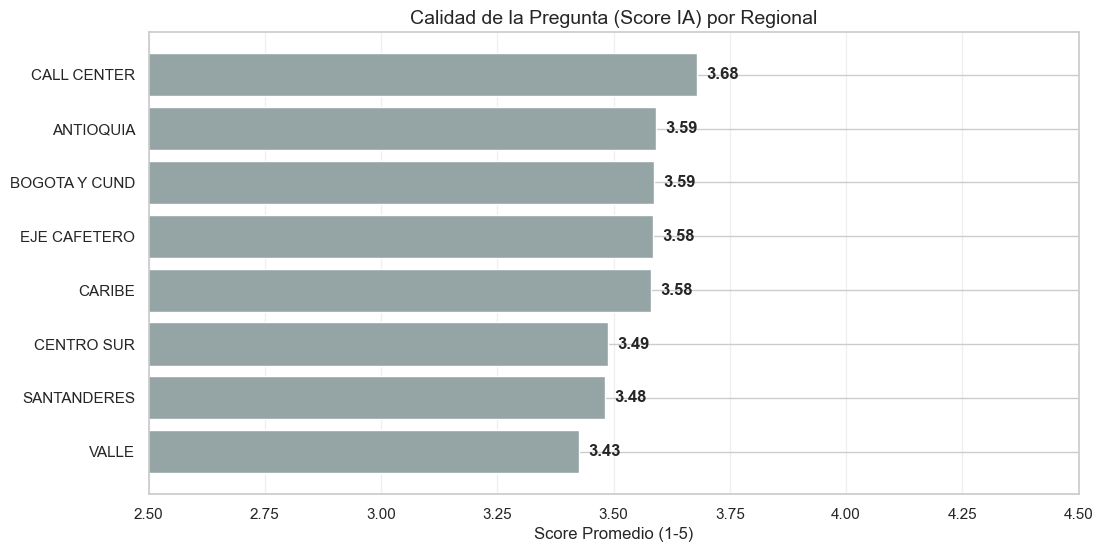


DISTRIBUCIÓN DE COMPLEJIDAD POR REGIONAL


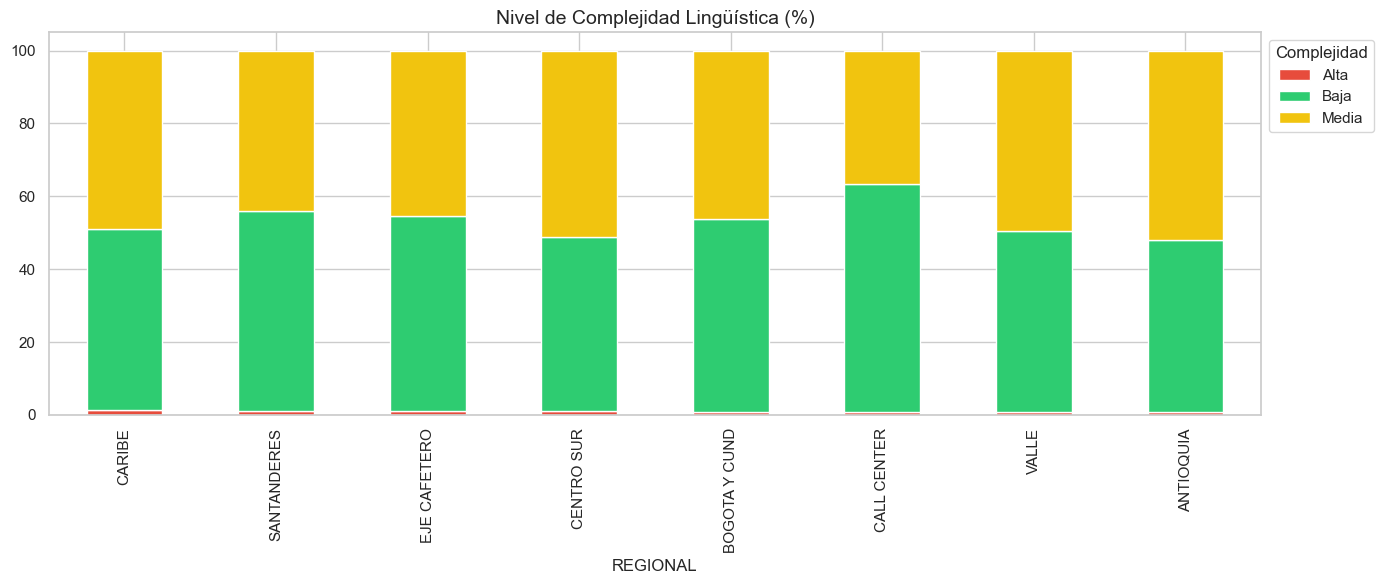


MATRIZ: CALIDAD DE PREGUNTA VS SATISFACCIÓN


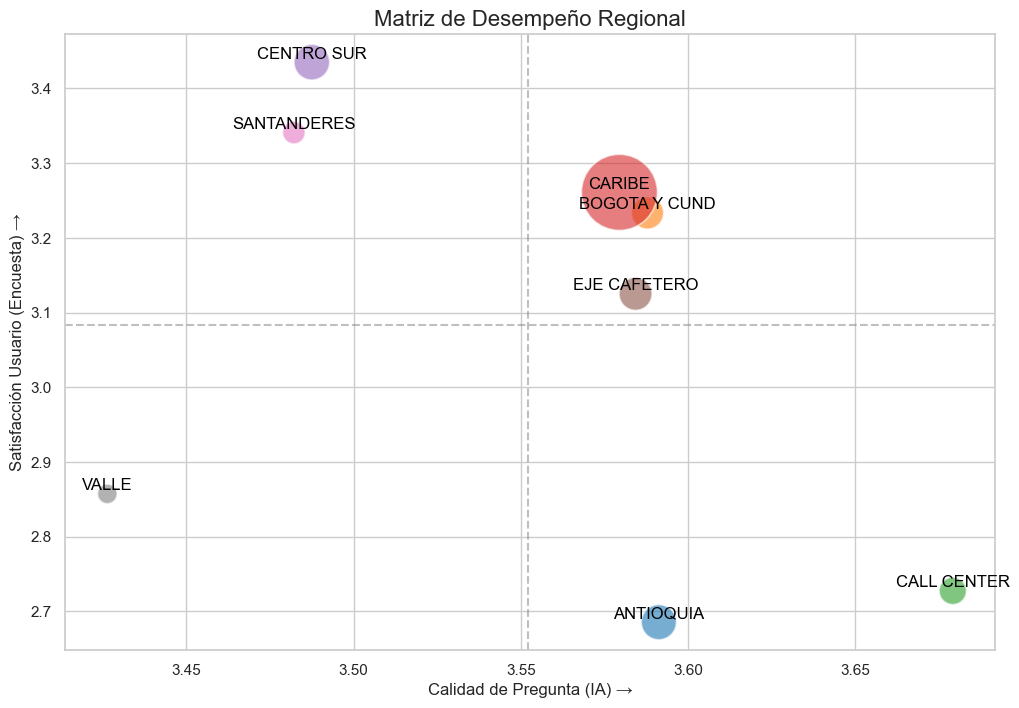

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================================================
# ANÁLISIS REGIONAL DETALLADO (FIX: Usando REGIONAL de df_analisis_ia)
# ==============================================================================

print("="*80)
print("COMPARATIVA REGIONAL: CARIBE VS RESTO (CORREGIDO)")
print("="*80)

if 'df_analisis_ia' in locals() and 'df_resultados_corregido' in locals():
    
    # 1. PREPARACIÓN DE DATOS (MERGE SIMPLIFICADO)
    # --------------------------------------------------------------------------
    print("Integrando calificación de usuario al análisis de IA...")
    
    # Del dataframe original solo necesitamos la CALIFICACIÓN
    df_scores = df_resultados_corregido[['conversation_id', 'calificacion_combinada']].copy()
    
    # Eliminamos duplicados por si acaso
    df_scores = df_scores.drop_duplicates(subset=['conversation_id'])
    
    # Hacemos el merge usando 'df_analisis_ia' como base (que ya tiene REGIONAL)
    df_full = pd.merge(df_analisis_ia, df_scores, on='conversation_id', how='inner')
    
    # Limpieza: Aseguramos que REGIONAL sea string y Score sea numérico
    df_full['REGIONAL'] = df_full['REGIONAL'].fillna('Desconocida').astype(str)
    df_full['calificacion_combinada'] = pd.to_numeric(df_full['calificacion_combinada'], errors='coerce')
    
    print(f"Datos listos. Regionales detectadas: {df_full['REGIONAL'].unique()}")

    # ==============================================================================
    # 2. RANKING: ¿QUIÉN PREGUNTA MEJOR? (IA Score)
    # ==============================================================================
    print(f"\n{'='*60}")
    print("RANKING DE CALIDAD DE PREGUNTA (SCORE IA)")
    print(f"{'='*60}")

    ranking = df_full.groupby('REGIONAL')['calidad_score'].agg(['mean', 'count']).reset_index()
    ranking = ranking.sort_values('mean', ascending=True)

    # Color: Caribe ROJO, Resto GRIS
    ranking['color'] = ranking['REGIONAL'].apply(lambda x: '#e74c3c' if 'Caribe' in x else '#95a5a6')

    plt.figure(figsize=(12, 6))
    bars = plt.barh(ranking['REGIONAL'], ranking['mean'], color=ranking['color'])
    
    plt.title('Calidad de la Pregunta (Score IA) por Regional', fontsize=14)
    plt.xlabel('Score Promedio (1-5)')
    plt.xlim(2.5, 4.5) # Zoom
    
    for bar in bars:
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                 f'{bar.get_width():.2f}', va='center', fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    # ==============================================================================
    # 3. COMPLEJIDAD LINGÜÍSTICA (¿Quién habla más difícil?)
    # ==============================================================================
    print(f"\n{'='*60}")
    print("DISTRIBUCIÓN DE COMPLEJIDAD POR REGIONAL")
    print(f"{'='*60}")
    
    ct = pd.crosstab(df_full['REGIONAL'], df_full['complejidad'], normalize='index') * 100
    
    if 'Alta' in ct.columns:
        ct = ct.sort_values('Alta', ascending=False)
        ct.plot(kind='bar', stacked=True, figsize=(14, 6),
                color={'Baja': '#2ecc71', 'Media': '#f1c40f', 'Alta': '#e74c3c'})
        
        plt.title('Nivel de Complejidad Lingüística (%)', fontsize=14)
        plt.legend(title='Complejidad', bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()

    # ==============================================================================
    # 4. MATRIZ ESTRATÉGICA (SCATTER PLOT)
    # ==============================================================================
    print(f"\n{'='*60}")
    print("MATRIZ: CALIDAD DE PREGUNTA VS SATISFACCIÓN")
    print(f"{'='*60}")
    
    scatter_data = df_full.groupby('REGIONAL').agg({
        'calidad_score': 'mean',
        'calificacion_combinada': 'mean',
        'conversation_id': 'count'
    }).reset_index()
    
    plt.figure(figsize=(12, 8))
    
    sns.scatterplot(
        data=scatter_data, 
        x='calidad_score', 
        y='calificacion_combinada', 
        size='conversation_id', 
        sizes=(200, 3000), 
        alpha=0.6, 
        hue='REGIONAL', 
        legend=False,
        palette='tab10'
    )
    
    # Líneas promedio
    plt.axvline(scatter_data['calidad_score'].mean(), color='gray', linestyle='--', alpha=0.5)
    plt.axhline(scatter_data['calificacion_combinada'].mean(), color='gray', linestyle='--', alpha=0.5)
    
    # Etiquetas
    for i, row in scatter_data.iterrows():
        is_caribe = 'Caribe' in str(row['REGIONAL'])
        color_txt = 'red' if is_caribe else 'black'
        weight_txt = 'bold' if is_caribe else 'normal'
        
        plt.text(row['calidad_score'], row['calificacion_combinada'] + 0.005, 
                 str(row['REGIONAL']), 
                 ha='center', color=color_txt, fontweight=weight_txt)

    plt.title('Matriz de Desempeño Regional', fontsize=16)
    plt.xlabel('Calidad de Pregunta (IA) →')
    plt.ylabel('Satisfacción Usuario (Encuesta) →')
    plt.show()

else:
    print("❌ Error: Asegúrate de haber cargado 'df_resultados_corregido' (con las calificaciones).")

INVESTIGACIÓN: PATRONES DE ESCALAMIENTO (CARIBE VS OTROS)


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\4254229167.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tasa_escalamiento, x='REGIONAL', y='flg_experto_flag', palette=colores)


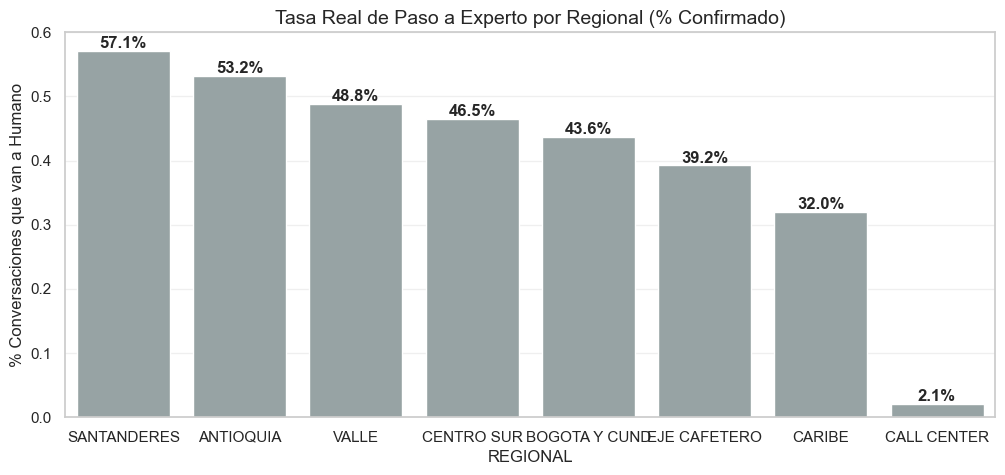

👆 ESTO CONFIRMA LA REALIDAD: Si la barra roja es la más alta, el dato es real.

HIPÓTESIS 1: COMPOSICIÓN TEMÁTICA (¿Qué preguntan?)


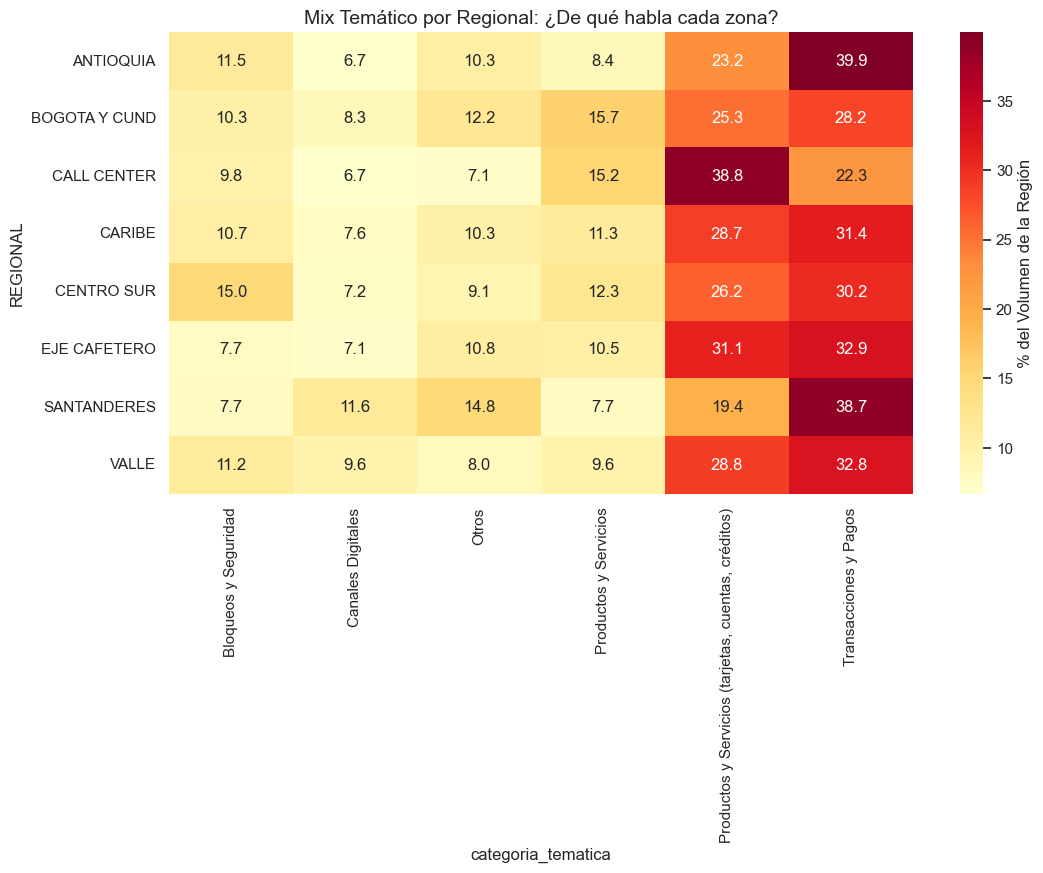

INTERPRETACIÓN: Busca columnas oscuras en la fila 'CARIBE'.
Si Caribe tiene 40% en un tema difícil (ej. Bloqueos) y los demás solo 10%,
¡Ahí está tu respuesta! Escalan porque tienen problemas más graves.

HIPÓTESIS 2: COMPORTAMIENTO (A igual problema, ¿quién escala más?)


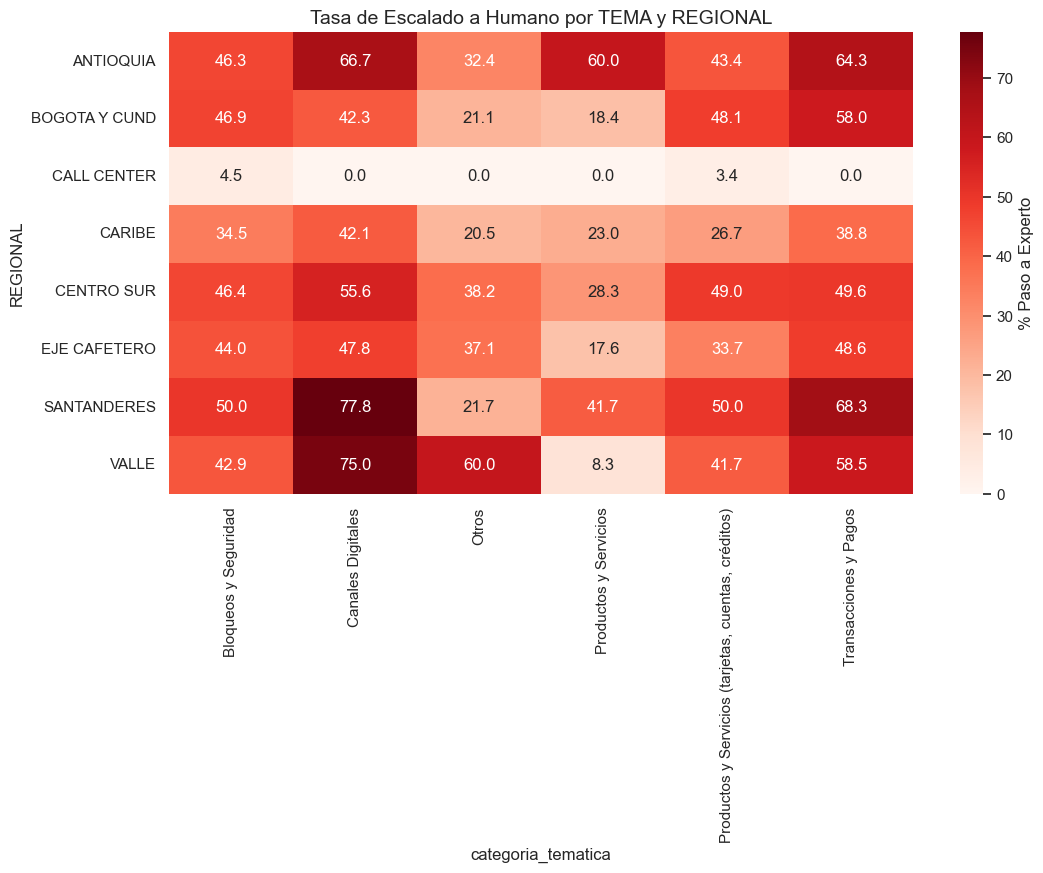

INTERPRETACIÓN CRUCIAL:
Compara la fila CARIBE contra ANTIOQUIA (o la mejor) en la MISMA COLUMNA.
Ejemplo: Tema 'Consultas de Saldo'.
- Si Caribe escala al 30% y Antioquia al 5% -> ES CULTURAL (Impaciencia).
- Si ambos escalan al 5% -> El bot funciona igual, el problema es que Caribe pregunta menos sobre Saldos.


In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==============================================================================
# ANÁLISIS DE CAUSA RAÍZ: ¿POR QUÉ CARIBE ESCALA TANTO?
# ==============================================================================

print("="*80)
print("INVESTIGACIÓN: PATRONES DE ESCALAMIENTO (CARIBE VS OTROS)")
print("="*80)

if 'df_analisis_ia' in locals() and 'df_resultados_corregido' in locals():
    
    # 1. PREPARAR DATOS (Merge con flag de experto real)
    # Necesitamos saber si realmente confirmaron el paso a experto
    df_base = pd.merge(
        df_analisis_ia[['conversation_id', 'REGIONAL', 'categoria_tematica']],
        df_resultados_corregido[['conversation_id', 'flg_experto_flag']], # 1 = Confirmó paso
        on='conversation_id', 
        how='inner'
    ).drop_duplicates(subset=['conversation_id'])
    
    # Llenar nulos en flag (0 = No pasó)
    df_base['flg_experto_flag'] = df_base['flg_experto_flag'].fillna(0)

    # 2. CONFIRMACIÓN DEL PROBLEMA (TASA DE ESCALAMIENTO)
    # --------------------------------------------------------------------------
    tasa_escalamiento = df_base.groupby('REGIONAL')['flg_experto_flag'].mean().reset_index()
    tasa_escalamiento = tasa_escalamiento.sort_values('flg_experto_flag', ascending=False)
    
    plt.figure(figsize=(12, 5))
    colores = ['#e74c3c' if 'Caribe' in x else '#95a5a6' for x in tasa_escalamiento['REGIONAL']]
    ax = sns.barplot(data=tasa_escalamiento, x='REGIONAL', y='flg_experto_flag', palette=colores)
    
    plt.title('Tasa Real de Paso a Experto por Regional (% Confirmado)', fontsize=14)
    plt.ylabel('% Conversaciones que van a Humano')
    plt.grid(axis='y', alpha=0.3)
    
    # Etiquetas
    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontweight='bold')
    plt.show()
    
    print("👆 ESTO CONFIRMA LA REALIDAD: Si la barra roja es la más alta, el dato es real.")

    # 3. HIPÓTESIS 1: ¿PREGUNTAN COSAS DISTINTAS? (MIX DE PRODUCTO)
    # --------------------------------------------------------------------------
    print(f"\n{'='*60}")
    print("HIPÓTESIS 1: COMPOSICIÓN TEMÁTICA (¿Qué preguntan?)")
    print(f"{'='*60}")
    
    # Top 5 temas globales para no saturar
    top_temas = df_base['categoria_tematica'].value_counts().head(6).index
    df_top_temas = df_base[df_base['categoria_tematica'].isin(top_temas)]
    
    # Tabla cruzada normalizada (Porcentajes dentro de cada región)
    ct_temas = pd.crosstab(df_top_temas['REGIONAL'], df_top_temas['categoria_tematica'], normalize='index') * 100
    
    # Filtramos solo Caribe y una regional de comparación (ej. Antioquia o Promedio)
    # Para simplificar, graficamos todo el Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(ct_temas, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': '% del Volumen de la Región'})
    plt.title('Mix Temático por Regional: ¿De qué habla cada zona?', fontsize=14)
    plt.show()
    
    print("INTERPRETACIÓN: Busca columnas oscuras en la fila 'CARIBE'.")
    print("Si Caribe tiene 40% en un tema difícil (ej. Bloqueos) y los demás solo 10%,")
    print("¡Ahí está tu respuesta! Escalan porque tienen problemas más graves.")

    # 4. HIPÓTESIS 2: ¿SON MÁS IMPACIENTES? (TASA DE FUGA POR Mismo TEMA)
    # --------------------------------------------------------------------------
    print(f"\n{'='*60}")
    print("HIPÓTESIS 2: COMPORTAMIENTO (A igual problema, ¿quién escala más?)")
    print(f"{'='*60}")
    
    # Calculamos la tasa de experto PROMEDIO por tema y regional
    pivot_fuga = df_top_temas.groupby(['REGIONAL', 'categoria_tematica'])['flg_experto_flag'].mean().unstack() * 100
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_fuga, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': '% Paso a Experto'})
    plt.title('Tasa de Escalado a Humano por TEMA y REGIONAL', fontsize=14)
    plt.show()
    
    print("INTERPRETACIÓN CRUCIAL:")
    print("Compara la fila CARIBE contra ANTIOQUIA (o la mejor) en la MISMA COLUMNA.")
    print("Ejemplo: Tema 'Consultas de Saldo'.")
    print("- Si Caribe escala al 30% y Antioquia al 5% -> ES CULTURAL (Impaciencia).")
    print("- Si ambos escalan al 5% -> El bot funciona igual, el problema es que Caribe pregunta menos sobre Saldos.")

else:
    print("❌ Faltan dataframes.")

COMPARACIÓN REGIONAL: CARIBE VS OTRAS

📊 Tamaños de muestra:
   Caribe: 1774 preguntas
   Otras: 2000 preguntas

1. COMPARACIÓN TEMÁTICA

📋 Top 5 categorías - CARIBE:
   Transacciones y Pagos: 521 (29.4%)
   Productos y Servicios (tarjetas, cuentas, créditos): 476 (26.8%)
   Productos y Servicios: 187 (10.5%)
   Bloqueos y Seguridad: 177 (10.0%)
   Otros: 171 (9.6%)

📋 Top 5 categorías - OTRAS:
   Transacciones y Pagos: 602 (30.1%)
   Productos y Servicios (tarjetas, cuentas, créditos): 514 (25.7%)
   Productos y Servicios: 217 (10.8%)
   Bloqueos y Seguridad: 202 (10.1%)
   Otros: 193 (9.7%)

2. COMPARACIÓN DE CALIDAD

📊 Score promedio de calidad:
   Caribe: 3.58 / 5.0
   Otras: 3.56 / 5.0
   Diferencia: +0.02

📊 Claridad:
   Caribe - Alta: 45.5%
   Otras - Alta: 45.1%

📊 Especificidad:
   Caribe - Alta: 25.5%
   Otras - Alta: 25.2%

📊 Complejidad:
   Caribe - Alta: 1.5%
   Otras - Alta: 0.9%

3. ESCALADAS VS AUTOGESTIONADAS

📊 CARIBE - Diferencias entre escaladas y autogestionadas:
 

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_2512\1179939130.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=scores_data, x='Regional', y='Score', ax=ax2, palette={'Caribe': '#e74c3c', 'Otras': '#3498db'})


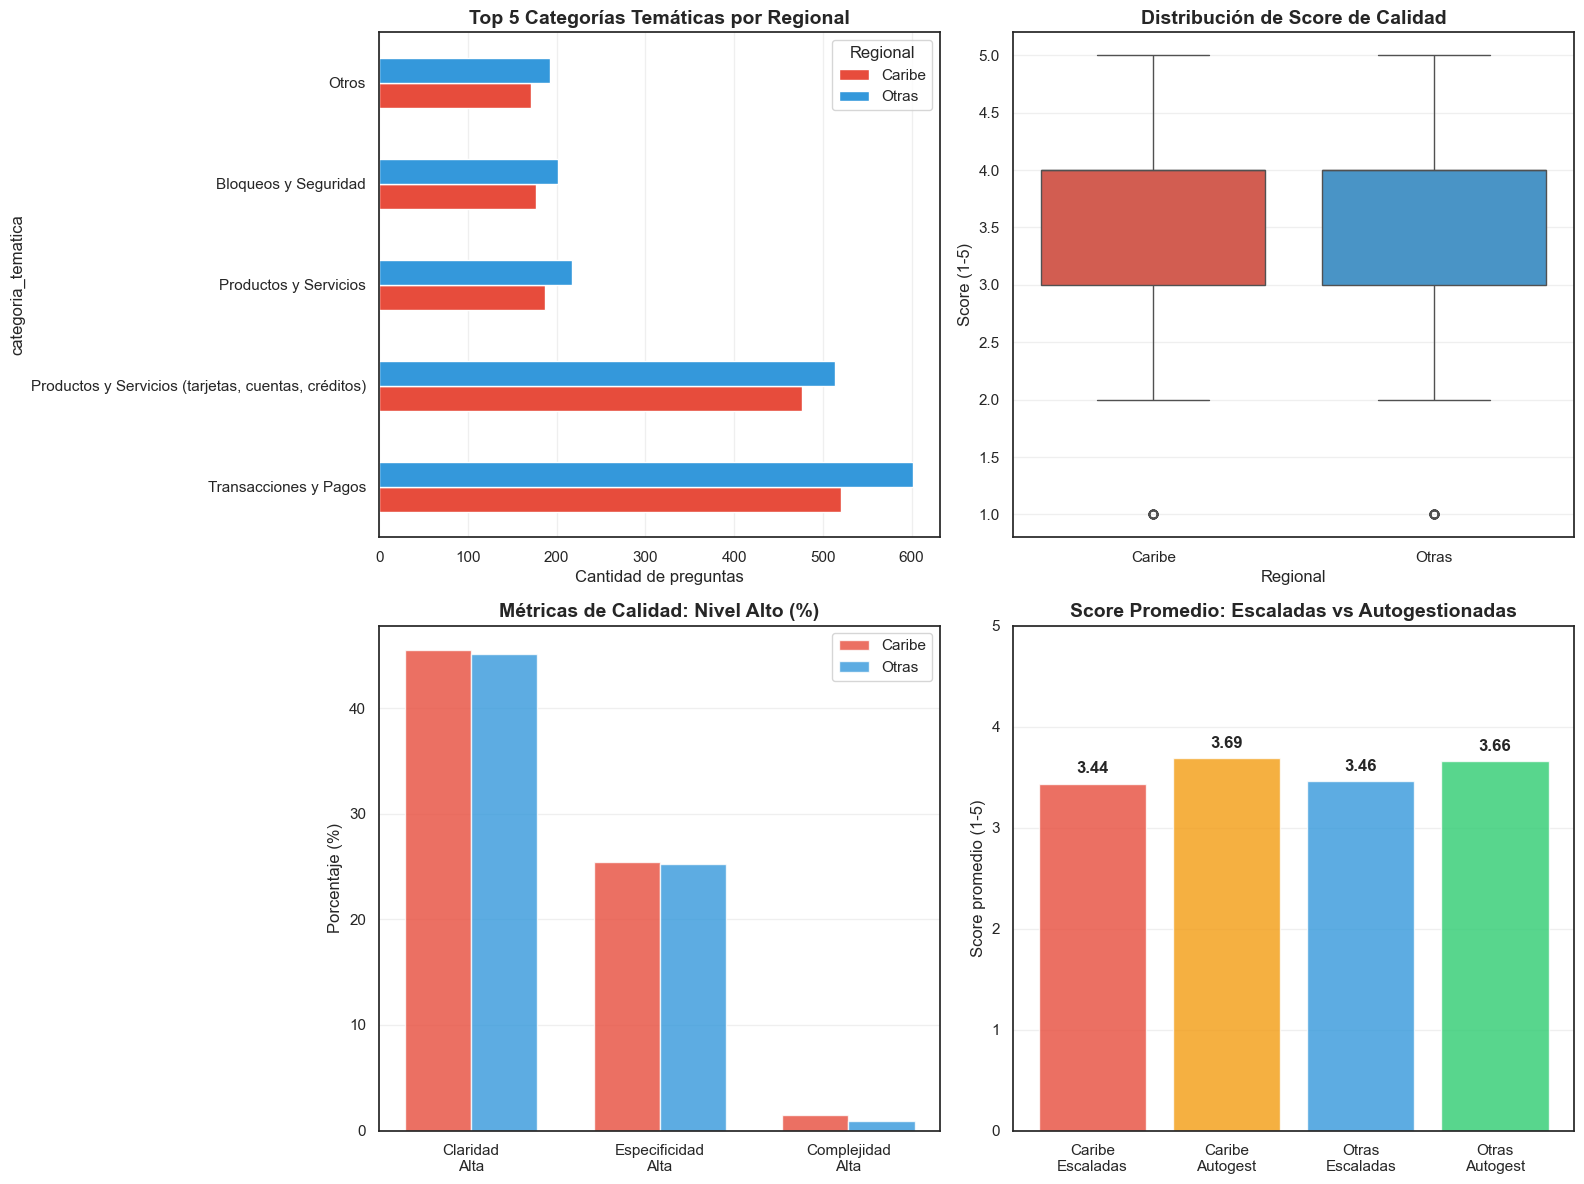


✅ Visualizaciones generadas


In [91]:
# ===== 5. COMPARACIÓN REGIONAL: CARIBE VS OTRAS =====
print("="*80)
print("COMPARACIÓN REGIONAL: CARIBE VS OTRAS")
print("="*80)

if 'df_analisis_ia' not in globals():
    print("❌ ERROR: df_analisis_ia no disponible. Ejecuta celda anterior primero.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Separar por grupo
    df_caribe = df_analisis_ia[df_analisis_ia['grupo_analisis'] == 'Caribe']
    df_otras = df_analisis_ia[df_analisis_ia['grupo_analisis'] == 'Otras']
    
    print(f"\n📊 Tamaños de muestra:")
    print(f"   Caribe: {len(df_caribe)} preguntas")
    print(f"   Otras: {len(df_otras)} preguntas")
    
    # ===== COMPARACIÓN 1: DISTRIBUCIÓN TEMÁTICA =====
    print(f"\n{'='*80}")
    print("1. COMPARACIÓN TEMÁTICA")
    print(f"{'='*80}")
    
    print(f"\n📋 Top 5 categorías - CARIBE:")
    caribe_temas = df_caribe['categoria_tematica'].value_counts().head(5)
    for tema, count in caribe_temas.items():
        print(f"   {tema}: {count} ({count/len(df_caribe)*100:.1f}%)")
    
    print(f"\n📋 Top 5 categorías - OTRAS:")
    otras_temas = df_otras['categoria_tematica'].value_counts().head(5)
    for tema, count in otras_temas.items():
        print(f"   {tema}: {count} ({count/len(df_otras)*100:.1f}%)")
    
    # ===== COMPARACIÓN 2: CALIDAD DE PREGUNTAS =====
    print(f"\n{'='*80}")
    print("2. COMPARACIÓN DE CALIDAD")
    print(f"{'='*80}")
    
    print(f"\n📊 Score promedio de calidad:")
    print(f"   Caribe: {df_caribe['calidad_score'].mean():.2f} / 5.0")
    print(f"   Otras: {df_otras['calidad_score'].mean():.2f} / 5.0")
    print(f"   Diferencia: {df_caribe['calidad_score'].mean() - df_otras['calidad_score'].mean():+.2f}")
    
    print(f"\n📊 Claridad:")
    print(f"   Caribe - Alta: {(df_caribe['claridad'] == 'Alta').sum()/len(df_caribe)*100:.1f}%")
    print(f"   Otras - Alta: {(df_otras['claridad'] == 'Alta').sum()/len(df_otras)*100:.1f}%")
    
    print(f"\n📊 Especificidad:")
    print(f"   Caribe - Alta: {(df_caribe['especificidad'] == 'Alta').sum()/len(df_caribe)*100:.1f}%")
    print(f"   Otras - Alta: {(df_otras['especificidad'] == 'Alta').sum()/len(df_otras)*100:.1f}%")
    
    print(f"\n📊 Complejidad:")
    print(f"   Caribe - Alta: {(df_caribe['complejidad'] == 'Alta').sum()/len(df_caribe)*100:.1f}%")
    print(f"   Otras - Alta: {(df_otras['complejidad'] == 'Alta').sum()/len(df_otras)*100:.1f}%")
    
    # ===== COMPARACIÓN 3: PREGUNTAS ESCALADAS VS AUTOGESTIONADAS =====
    print(f"\n{'='*80}")
    print("3. ESCALADAS VS AUTOGESTIONADAS")
    print(f"{'='*80}")
    
    print(f"\n📊 CARIBE - Diferencias entre escaladas y autogestionadas:")
    caribe_escaladas_df = df_caribe[df_caribe['escalado_experto'] == True]
    caribe_autogest_df = df_caribe[df_caribe['escalado_experto'] == False]
    
    if len(caribe_escaladas_df) > 0 and len(caribe_autogest_df) > 0:
        print(f"   Score escaladas: {caribe_escaladas_df['calidad_score'].mean():.2f}")
        print(f"   Score autogestionadas: {caribe_autogest_df['calidad_score'].mean():.2f}")
        print(f"   Diferencia: {caribe_escaladas_df['calidad_score'].mean() - caribe_autogest_df['calidad_score'].mean():+.2f}")
        
        print(f"\n   Top tema escaladas: {caribe_escaladas_df['categoria_tematica'].mode().values[0] if len(caribe_escaladas_df['categoria_tematica'].mode()) > 0 else 'N/A'}")
        print(f"   Top tema autogestionadas: {caribe_autogest_df['categoria_tematica'].mode().values[0] if len(caribe_autogest_df['categoria_tematica'].mode()) > 0 else 'N/A'}")
    
    print(f"\n📊 OTRAS - Diferencias entre escaladas y autogestionadas:")
    otras_escaladas_df = df_otras[df_otras['escalado_experto'] == True]
    otras_autogest_df = df_otras[df_otras['escalado_experto'] == False]
    
    if len(otras_escaladas_df) > 0 and len(otras_autogest_df) > 0:
        print(f"   Score escaladas: {otras_escaladas_df['calidad_score'].mean():.2f}")
        print(f"   Score autogestionadas: {otras_autogest_df['calidad_score'].mean():.2f}")
        print(f"   Diferencia: {otras_escaladas_df['calidad_score'].mean() - otras_autogest_df['calidad_score'].mean():+.2f}")
    
    # ===== VISUALIZACIONES =====
    print(f"\n{'='*80}")
    print("GENERANDO VISUALIZACIONES")
    print(f"{'='*80}")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico 1: Distribución de categorías temáticas
    ax1 = axes[0, 0]
    cat_comp = pd.DataFrame({
        'Caribe': df_caribe['categoria_tematica'].value_counts().head(5),
        'Otras': df_otras['categoria_tematica'].value_counts().head(5)
    }).fillna(0)
    
    cat_comp.plot(kind='barh', ax=ax1, color=['#e74c3c', '#3498db'])
    ax1.set_title('Top 5 Categorías Temáticas por Regional', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Cantidad de preguntas')
    ax1.legend(title='Regional')
    ax1.grid(axis='x', alpha=0.3)
    
    # Gráfico 2: Distribución de scores de calidad
    ax2 = axes[0, 1]
    scores_data = pd.DataFrame({
        'Regional': ['Caribe']*len(df_caribe) + ['Otras']*len(df_otras),
        'Score': list(df_caribe['calidad_score']) + list(df_otras['calidad_score'])
    })
    sns.boxplot(data=scores_data, x='Regional', y='Score', ax=ax2, palette={'Caribe': '#e74c3c', 'Otras': '#3498db'})
    ax2.set_title('Distribución de Score de Calidad', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score (1-5)')
    ax2.grid(axis='y', alpha=0.3)
    
    # Gráfico 3: Claridad, Especificidad, Complejidad
    ax3 = axes[1, 0]
    metricas_caribe = {
        'Claridad\nAlta': (df_caribe['claridad'] == 'Alta').sum()/len(df_caribe)*100,
        'Especificidad\nAlta': (df_caribe['especificidad'] == 'Alta').sum()/len(df_caribe)*100,
        'Complejidad\nAlta': (df_caribe['complejidad'] == 'Alta').sum()/len(df_caribe)*100
    }
    metricas_otras = {
        'Claridad\nAlta': (df_otras['claridad'] == 'Alta').sum()/len(df_otras)*100,
        'Especificidad\nAlta': (df_otras['especificidad'] == 'Alta').sum()/len(df_otras)*100,
        'Complejidad\nAlta': (df_otras['complejidad'] == 'Alta').sum()/len(df_otras)*100
    }
    
    x = np.arange(len(metricas_caribe))
    width = 0.35
    
    ax3.bar(x - width/2, list(metricas_caribe.values()), width, label='Caribe', color='#e74c3c', alpha=0.8)
    ax3.bar(x + width/2, list(metricas_otras.values()), width, label='Otras', color='#3498db', alpha=0.8)
    
    ax3.set_ylabel('Porcentaje (%)')
    ax3.set_title('Métricas de Calidad: Nivel Alto (%)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(list(metricas_caribe.keys()))
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Gráfico 4: Comparación escaladas vs autogestionadas
    ax4 = axes[1, 1]
    escaladas_data = pd.DataFrame({
        'Regional': ['Caribe\nEscaladas', 'Caribe\nAutogest', 'Otras\nEscaladas', 'Otras\nAutogest'],
        'Score': [
            caribe_escaladas_df['calidad_score'].mean() if len(caribe_escaladas_df) > 0 else 0,
            caribe_autogest_df['calidad_score'].mean() if len(caribe_autogest_df) > 0 else 0,
            otras_escaladas_df['calidad_score'].mean() if len(otras_escaladas_df) > 0 else 0,
            otras_autogest_df['calidad_score'].mean() if len(otras_autogest_df) > 0 else 0
        ]
    })
    
    colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
    ax4.bar(escaladas_data['Regional'], escaladas_data['Score'], color=colors, alpha=0.8)
    ax4.set_title('Score Promedio: Escaladas vs Autogestionadas', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Score promedio (1-5)')
    ax4.set_ylim(0, 5)
    ax4.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(escaladas_data['Score']):
        ax4.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Visualizaciones generadas")